In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import math
import missingno as msno

from scipy.stats import f_oneway
import pickle

from sklearn.impute import KNNImputer
from sklearn.ensemble import ExtraTreesRegressor, RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.pipeline import make_pipeline

from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import mean_squared_error

from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE

from matplotlib import pyplot

pd.set_option('display.max_columns', None)
plt.rcParams["figure.figsize"] = (100,100)
plt.rc('font', size=50)


# Getting Data

In [2]:
X_train_1 = pd.read_csv('Data/Pneumonia_Data_48h/24h-48h/For Clustering/Cluster_1_24h-48h_Mortality_SS_C.csv')
y_train_1 = np.load('Data/Pneumonia_Data_48h/24h-48h/For Clustering/Cluster_1_class_24h-48h_Mortality_SS_C.npy')

X_train_2 = pd.read_csv('Data/Pneumonia_Data_48h/24h-48h/For Clustering/Cluster_2_24h-48h_Mortality_SS_C.csv')
y_train_2 = np.load('Data/Pneumonia_Data_48h/24h-48h/For Clustering/Cluster_2_class_24h-48h_Mortality_SS_C.npy')

X_train_3 = pd.read_csv('Data/Pneumonia_Data_48h/24h-48h/For Clustering/Cluster_3_24h-48h_Mortality_SS_C.csv')
y_train_3 = np.load('Data/Pneumonia_Data_48h/24h-48h/For Clustering/Cluster_3_class_24h-48h_Mortality_SS_C.npy')

X_train_4 = pd.read_csv('Data/Pneumonia_Data_48h/24h-48h/For Clustering/Cluster_4_24h-48h_Mortality_SS_C.csv')
y_train_4 = np.load('Data/Pneumonia_Data_48h/24h-48h/For Clustering/Cluster_4_class_24h-48h_Mortality_SS_C.npy')

X_train_5 = pd.read_csv('Data/Pneumonia_Data_48h/24h-48h/For Clustering/Cluster_5_24h-48h_Mortality_SS_C.csv')
y_train_5 = np.load('Data/Pneumonia_Data_48h/24h-48h/For Clustering/Cluster_5_class_24h-48h_Mortality_SS_C.npy')

# ... can add more if needed

X_test = pd.read_csv('Data/Pneumonia_Data_48h/24h-48h/For Clustering/TEST_24h-48h_Mortality_SS_C_important_features.csv')
y_test = np.load('Data/Pneumonia_Data_48h/24h-48h/For Clustering/TEST_24h-48h_Mortality_SS_C_class.npy')

No_Model_List = np.load('Data/Pneumonia_Data_48h/24h-48h/For Clustering/No_Model_List_24h-48h_Mortality_SS_C.npy')

In [3]:
# Define list of cluster data
Clusters_Data = [(1, X_train_1, y_train_1), (2, X_train_2, y_train_2), (3, X_train_3, y_train_3), (4, X_train_4, y_train_4), (5, X_train_5, y_train_5)]

# Separate Test Data for each cluster or give weights

It's important to do this before the RFE, because the distances would not be comparable after elimination of some features in some clusters

In [4]:
# Get centroids of clusters

centroids = []

for n, X, y in Clusters_Data:

    centroid = X.mean().tolist()
    centroids.append(centroid)

In [5]:
# calculate distance between test and centroid

distances_all = []
weights_all = []
menbership_all = []

for index, row in X_test.iterrows():

    row = row.tolist()

    # calculate distances
    distances = []
    for c in centroids:
        # euclidean distance
        eu_dis = np.linalg.norm(np.array(row)-np.array(c))

        distances.append(eu_dis)

    # calculate weights
    diastances_sum = sum(distances)
    distances_sum_inv = sum([1/d for d in distances])
    weights = []

    for n in range(0,len(centroids)):
        # This is to calculate the weight via inverse distance weighting (IDW)
        n_weight = (1/distances[n])/distances_sum_inv
        weights.append(n_weight)

    # calculate menbership
    best_cluster = weights.index(max(weights)) + 1


    # Says what is the closest cluster
    menbership_all.append(best_cluster)
    # Distances between cluster centroid
    distances_all.append(distances)
    # Weights of menbership to clusters
    weights_all.append(weights)

In [6]:
print(distances_all)

[[5.995177089153452, 7.077031367489206, 4.269103339151919, 4.023009600647381, 2.8829656511639836], [5.921635797243694, 6.852872165436113, 3.9213083164252316, 3.677322353280137, 2.8070756714616696], [5.922493724534119, 6.97332323193436, 4.179829788427794, 3.8557511423210835, 3.048603020253186], [6.991891672827679, 7.678166093530498, 5.413543818145884, 3.7271046789503637, 4.432172132042265], [4.166717111468343, 8.837114804161432, 6.671761263970418, 6.891871726278466, 6.484634783419087], [6.992264240419311, 7.775454676871677, 5.272091509977048, 3.4563402624806248, 4.613028453845411], [6.437816048162491, 7.317465202091274, 4.652648010160107, 2.723886330397054, 3.904590436888255], [5.74540360793904, 6.86305201095361, 3.909618648554142, 3.469842635975233, 2.4482858412145565], [7.228515854141585, 7.978877982980615, 5.887311284996029, 3.8875641940519268, 4.8482975351102064], [5.767145094625339, 6.7893682504079385, 3.6865597395972136, 3.5979380755925354, 2.767229920484841], [6.454685032577416, 

# Eliminating Features via Logistic Regression RFE

Cluster 1


C:\Users\nunop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  UserWarning,


>2 0.7000 (0.2449)


C:\Users\nunop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  UserWarning,


>4 0.7000 (0.2449)
>6 0.7000 (0.2449)


C:\Users\nunop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  UserWarning,
C:\Users\nunop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  UserWarning,


>8 0.7000 (0.2449)
>10 0.7000 (0.2449)
>12 0.7000 (0.2449)


C:\Users\nunop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  UserWarning,
C:\Users\nunop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  UserWarning,
C:\Users\nunop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  UserWarning,


>14 0.6857 (0.2308)
>16 0.6857 (0.2308)
>18 0.6857 (0.2308)
>20 0.6857 (0.2308)

Number of features : 2
Score : 0.7



C:\Users\nunop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  UserWarning,
C:\Users\nunop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  UserWarning,
C:\Users\nunop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  UserWarning,


Index(['Age', 'HeartRate'], dtype='object')


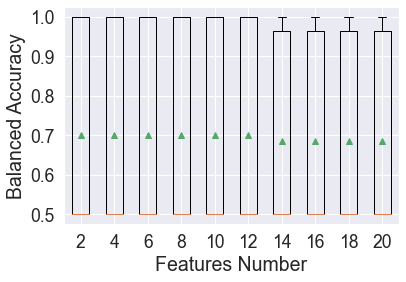

Cluster 2
>2 0.5500 (0.1675)
>4 0.5500 (0.3379)
>6 0.5917 (0.2485)
>8 0.6750 (0.1880)
>10 0.6167 (0.2048)
>12 0.6000 (0.2000)
>14 0.6583 (0.2341)
>16 0.6417 (0.2417)
>18 0.6417 (0.2417)
>20 0.6417 (0.2417)

Number of features : 8
Score : 0.675

Index(['HeartRate', 'TAD', 'Lactate', 'metHb', 'BE', 'DHL', 'Urea',
       'MultiorganD'],
      dtype='object')


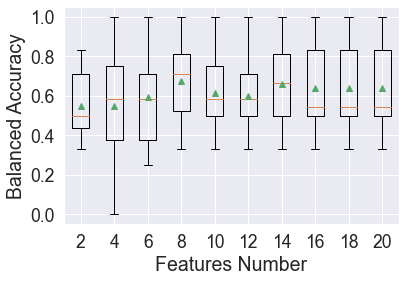

Cluster 3
>2 0.5653 (0.0701)
>4 0.6039 (0.0683)
>6 0.6269 (0.0899)
>8 0.6235 (0.0474)
>10 0.6388 (0.0699)
>12 0.6391 (0.0828)
>14 0.6337 (0.0786)
>16 0.6410 (0.0811)
>18 0.6427 (0.0775)
>20 0.6482 (0.0780)

Number of features : 20
Score : 0.648225677830941

Index(['Age', 'HeartRate', 'TAD', 'Lactate', 'PaCO2', 'metHb', 'BE', 'AST/TGO',
       'DHL', 'AlkalinePhosph', 'GGT', 'Lymphocytes', 'Platelets', 'Urea',
       'Glasgow', 'Pneumothorax', 'MultiorganD', 'PolyneuroMyopathy', 'Shock',
       'NIVUD'],
      dtype='object')


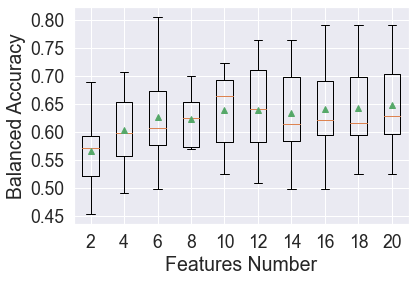

Cluster 4
>2 0.4969 (0.0062)
>4 0.5412 (0.1053)
>6 0.5521 (0.1078)
>8 0.5505 (0.0794)
>10 0.5490 (0.0808)
>12 0.5474 (0.0819)
>14 0.5474 (0.0819)
>16 0.5474 (0.0794)
>18 0.5458 (0.0805)
>20 0.5458 (0.0805)

Number of features : 6
Score : 0.5520833333333333

Index(['Age', 'PaCO2', 'metHb', 'BE', 'DHL', 'GGT'], dtype='object')


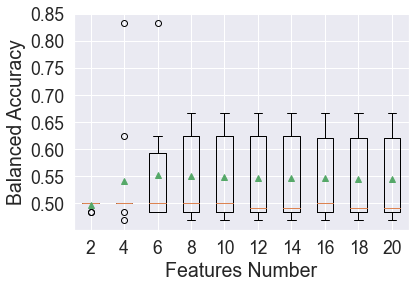

Cluster 5
>2 0.5050 (0.0143)
>4 0.5324 (0.0322)
>6 0.5449 (0.0325)
>8 0.5529 (0.0423)
>10 0.5576 (0.0352)
>12 0.5700 (0.0309)
>14 0.5890 (0.0272)
>16 0.5876 (0.0286)
>18 0.5943 (0.0372)
>20 0.5943 (0.0372)

Number of features : 18
Score : 0.5943084089823221

Index(['Age', 'HeartRate', 'TAD', 'Lactate', 'PaCO2', 'metHb', 'BE', 'AST/TGO',
       'DHL', 'AlkalinePhosph', 'GGT', 'Lymphocytes', 'Platelets', 'Urea',
       'Glasgow', 'PolyneuroMyopathy', 'Shock', 'NIVUD'],
      dtype='object')


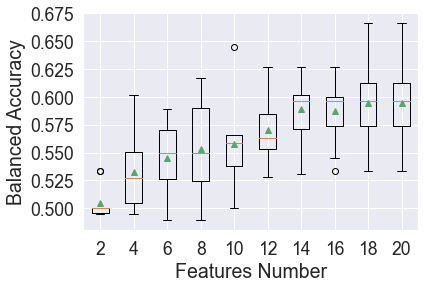

In [7]:
sns.set(rc={"figure.figsize":(9, 5)})

RFE_columns_List = []

for n, X, y in Clusters_Data:

   # Just to clusters with models
   if No_Model_List[n-1] == 0:
      print('Cluster', n)

      # get a list of models to evaluate
      models = dict()
      for i in [2,4,6,8,10,12,14,16,18,20]:
         # A machine learning model to selecting the features by eliminating the least important feature after recursively training
         rfe = RFE(estimator=LogisticRegression(max_iter=300), n_features_to_select=i)
         model = LogisticRegression(random_state = 0)
         models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])

      # evaluate the models and store results
      results, names = list(), list()
      results_mean = list()
      for name, model in models.items():
         # scoring='balanced_accuracy' because the data is unbalenced
         scores = cross_val_score(model, X, y, scoring='balanced_accuracy', cv=10, n_jobs=-1, error_score='raise')
         results.append(scores)
         results_mean.append(scores.mean())
         names.append(name)
         print('>%s %.4f (%.4f)' % (name, scores.mean(), scores.std()))

      
      # Chose the best number of features as dicovered from before
      # Here we will chose the best from a pull of the best 20 features

      best_score = max(results_mean)
      best_name = names[results_mean.index(max(results_mean))]

      print()
      print('Number of features :', best_name)
      print('Score :', best_score)
      print()

      # Change data to just the best features and show which are the best features

      rfe_selector = RFE(estimator=LogisticRegression(max_iter=300),n_features_to_select = int(best_name), step = 1)
      rfe_selector.fit(X, y)
      RFE_columns = X.columns[rfe_selector.get_support()]
      print(RFE_columns)

      # Store Columns to use for each cluster
      RFE_columns_List.append(RFE_columns)
      

      # plot model performance for comparison
      pyplot.boxplot(results, labels=names, showmeans=True)

      pyplot.ylabel('Balanced Accuracy', fontsize=19.5)
      pyplot.xlabel('Features Number', fontsize=19.5)
      pyplot.yticks(fontsize = 17.5)
      pyplot.xticks(fontsize = 17.5)

      #pyplot.savefig('RFE')
      pyplot.show()
   else:
      print('Cluster', n)
      print('No RFE')
      print()
      RFE_columns_List.append(X.columns)


# Penalty and Cross Validation

In [8]:
classifier_list = ['standard', 'none', 0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

# This function returns the mean accuracys of clusters in the order of classifier_list, 
# and all the accuracies results in a dataframe
def Penalty(X_train, y_train):
    mean_accuracy_list = []

    accuracies_df = pd.DataFrame()
    n=0

    for parameter in classifier_list:

        #print(parameter, ':')

        if parameter == 'standard':
            classifier = LogisticRegression(max_iter=2000, random_state=0, solver='lbfgs', penalty='l2')
        elif parameter == 'none':
            classifier = LogisticRegression(max_iter=2000, random_state=0, penalty ='none', solver='saga')
        else:
            classifier = LogisticRegression(max_iter=2000, random_state=0, penalty ='elasticnet', solver='saga', l1_ratio=parameter)
    
        # scoring='balanced_accuracy' because the data is unbalenced
        all_accuracies_LR = cross_val_score(estimator=classifier, X=X_train, y=y_train, cv=10, scoring='balanced_accuracy')

        #print('cross_val_score: ', all_accuracies_LR)
        mean_accuracy_list.append(all_accuracies_LR.mean())
        #print('Mean: ', all_accuracies_LR.mean())
        #print('Standard deviation: ', all_accuracies_LR.std())
        #print()

        accuracies_df[parameter] = all_accuracies_LR

    return (mean_accuracy_list, accuracies_df)


In [9]:
# get best parameter for each cluster

l1_ratios = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
Best_parameter = []

for n, X, y in Clusters_Data:
    if No_Model_List[n-1] == 0:

        X = X[RFE_columns_List[n-1]]
    
        accuracies, accuracies_df = Penalty(X, y)

        # get best l1 ratio
        best_id = accuracies[2:].index(max(accuracies[2:]))
        best_l1_ratio = l1_ratios[best_id]

        # compare standard and none to best l1 ratio
        accuracies_df_2 = pd.DataFrame({'standard':accuracies_df['standard'], 'saga none':accuracies_df['none'], best_l1_ratio:accuracies_df[best_l1_ratio]})
        f_oneway_result = f_oneway(accuracies_df_2['standard'], accuracies_df_2['saga none'], accuracies_df_2[best_l1_ratio])

        if f_oneway_result.pvalue > 0.05:
            Best_parameter.append('standard')
        else:
            Best_parameter.append(best_l1_ratio)
    else:
        Best_parameter.append(None)
    
print(Best_parameter)

C:\Users\nunop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  UserWarning,
C:\Users\nunop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  UserWarning,
C:\Users\nunop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  UserWarning,
C:\Users\nunop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sk

['standard', 'standard', 'standard', 'standard', 'standard']


# Logistic Regression Model, Cost and parameters

In [10]:
# Get best model function with the best parameter

def Best_Model(X_train, y_train):

    parameter = Best_parameter[n-1]

    if parameter != None:
    
        if f_oneway_result.pvalue > 0.05:
            print('standard')
            LR_classifier = LogisticRegression(max_iter=2000, random_state=0, solver='lbfgs', penalty="l2")
        else:
            print('l1 ratio')
            LR_classifier = LogisticRegression(max_iter=2000, random_state=0, penalty ='elasticnet', solver='saga', l1_ratio=parameter)
    
        LR_classifier.fit(X_train, y_train)
    
    else:
        print('dummy')
        LR_classifier = DummyClassifier(strategy="most_frequent")

        LR_classifier.fit(X_train, y_train)

    return (LR_classifier)

In [11]:
Model_List = []

for n, X, y in Clusters_Data:

    X = X[RFE_columns_List[n-1]]
        
    Model_List.append(Best_Model(X, y))


standard
standard
standard
standard
standard


In [12]:
# Final cross validation with balanced accuracy
Mean_accuracies = []
Mean_accuracies_std = []

Mean_balanced_accuracies = []
Mean_balanced_accuracies_std = []

Mean_precisions = []
Mean_precisions_std = []

Mean_recalls = []
Mean_recalls_std = []

Mean_f1 = []
Mean_f1_std = []

# lenght of each cluster
Size_list = []

for n, X, y in Clusters_Data:

    X = X[RFE_columns_List[n-1]]

    classifier = Model_List[n-1]

    cv = StratifiedKFold(10)

    print('Cluster', n)

    all_accuracies_RF = cross_val_score(estimator=classifier, X=X, y=y, cv=cv, scoring='accuracy')
    all_balanced_accuracies_RF = cross_val_score(estimator=classifier, X=X, y=y, cv=cv, scoring='balanced_accuracy')
    all_precisions_RF = cross_val_score(estimator=classifier, X=X, y=y, cv=cv, scoring='precision')
    all_recalls_RF = cross_val_score(estimator=classifier, X=X, y=y, cv=cv, scoring='recall')
    all_f1_RF = cross_val_score(estimator=classifier, X=X, y=y, cv=cv, scoring='f1')

    print('     Accuracy')
    print('%6.2f' % all_accuracies_RF.mean(), 'std','%3.2f' % all_accuracies_RF.std())
    print()
    print('Balanced Accuracy')
    print('%6.2f' % all_balanced_accuracies_RF.mean(), 'std','%3.2f' % all_balanced_accuracies_RF.std())
    print()
    print('    Precision')
    print('%6.2f' % all_precisions_RF.mean(), 'std','%3.2f' % all_precisions_RF.std())
    print()
    print('     Recall')
    print('%6.2f' % all_recalls_RF.mean(), 'std','%3.2f' % all_recalls_RF.std())
    print()
    print('    F1-score')
    print('%6.2f' % all_f1_RF.mean(), 'std','%3.2f' % all_f1_RF.std())
    print()

    Size_list.append(len(X))
    
    Mean_accuracies.append(all_accuracies_RF.mean())
    Mean_accuracies_std.append(all_accuracies_RF.std())

    Mean_balanced_accuracies.append(all_balanced_accuracies_RF.mean())
    Mean_balanced_accuracies_std.append(all_balanced_accuracies_RF.std())

    Mean_precisions.append(all_precisions_RF.mean())
    Mean_precisions_std.append(all_precisions_RF.std())

    Mean_recalls.append(all_recalls_RF.mean())
    Mean_recalls_std.append(all_recalls_RF.std())

    Mean_f1.append(all_f1_RF.mean())
    Mean_f1_std.append(all_f1_RF.std())
    print()

Cluster 1


C:\Users\nunop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  UserWarning,
C:\Users\nunop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  UserWarning,
C:\Users\nunop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  UserWarning,
C:\Users\nunop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sk

     Accuracy
  0.91 std 0.07

Balanced Accuracy
  0.70 std 0.24

    Precision
  0.00 std 0.00

     Recall
  0.00 std 0.00

    F1-score
  0.00 std 0.00


Cluster 2
     Accuracy
  0.82 std 0.16

Balanced Accuracy
  0.81 std 0.19

    Precision
  0.72 std 0.33

     Recall
  0.75 std 0.34

    F1-score
  0.71 std 0.31


Cluster 3
     Accuracy
  0.68 std 0.07

Balanced Accuracy
  0.65 std 0.08

    Precision
  0.62 std 0.16

     Recall
  0.49 std 0.09

    F1-score
  0.55 std 0.11


Cluster 4


C:\Users\nunop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nunop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nunop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defin

     Accuracy
  0.90 std 0.04

Balanced Accuracy
  0.57 std 0.11

    Precision
  0.40 std 0.49

     Recall
  0.15 std 0.21

    F1-score
  0.21 std 0.28


Cluster 5
     Accuracy
  0.88 std 0.02

Balanced Accuracy
  0.59 std 0.04

    Precision
  0.69 std 0.22

     Recall
  0.21 std 0.07

    F1-score
  0.31 std 0.10




In [13]:
print(' All clusters ')
print()

Cross_Val_Performance_Lists=[['Accuracy',Mean_accuracies, Mean_accuracies_std], ['Balanced Accuracy',Mean_balanced_accuracies,Mean_balanced_accuracies_std], ['Precision',Mean_precisions,Mean_precisions_std], ['Recall',Mean_recalls,Mean_recalls_std], ['F1-score',Mean_f1,Mean_f1_std]]

# Weighted Average of Cross validations

for PM_name, PM_value, PM_std in Cross_Val_Performance_Lists:
    # Accuracie
    Sum_Size = sum(Size_list)
    w_acc_list = []
    w_std_list = []

    for size, acc, std in list(zip(Size_list, PM_value, PM_std)):

        w_acc = acc*(size/Sum_Size)
        w_acc_list.append(w_acc)
        w_std = std*(size/Sum_Size)
        w_std_list.append(w_std)
    
    print( PM_name, ': %5.2f' % sum(w_acc_list), ' std %5.2f' % sum(w_std_list))


 All clusters 

Accuracy :  0.85  std  0.03
Balanced Accuracy :  0.61  std  0.07
Precision :  0.60  std  0.26
Recall :  0.25  std  0.11
F1-score :  0.33  std  0.14


# Performance on Test 1 ( via 0/1 membership)

In [17]:
# Separate test data to clusters

test_dataframes_list = []
test_classes_list =  []
# for plot of y pred vs distance
distance_for_plot = []

for n, X, y in Clusters_Data:

    X = X[RFE_columns_List[n-1]]

    One_cluster_test_df = pd.DataFrame(columns=list(X_test.columns))
    One_cluster_test_class = []
    One_distance_for_plot = []

    for index, row in X_test.iterrows():

        if menbership_all[index] == n:
            One_cluster_test_df = One_cluster_test_df.append(row, ignore_index=True)
            One_cluster_test_class.append(y_test[index])
            One_distance_for_plot.append(distances_all[index])

    # X_test Data separeted by cluster
    test_dataframes_list.append(One_cluster_test_df)
    # y_test Data separeted by cluster
    test_classes_list.append(One_cluster_test_class)
    # distances separeted by cluster
    distance_for_plot.append(One_distance_for_plot)

In [18]:
# Size of test menbership for each cluster
for n, X, y in Clusters_Data:
    print('Cluster', n, ':', len(test_dataframes_list[n-1]))

Cluster 1 : 33
Cluster 2 : 16
Cluster 3 : 156
Cluster 4 : 184
Cluster 5 : 512


In [19]:
# First I need a copy with all the features for the comparison at the end
test_dataframes_list_all_features = test_dataframes_list.copy()
# Also for the proof of concept because of the small clusters with less than 50 test observations
test_dataframes_list_all_features_for_ONE_CLUSTER = test_dataframes_list.copy()
test_classes_list_for_ONE_CLUSTER = test_classes_list.copy()

# Change number of features according to the RFE of clusters

for n, X, y in Clusters_Data:

    X = X[RFE_columns_List[n-1]]
    
    test_dataframes_list[n-1] = test_dataframes_list[n-1][X.columns]

In [20]:
# To calculate AIC (Akaike information criterion) and BIC
# This is true for linear models

# calculate aic for regression
def calculate_aic(n, mse, num_params):
    aic = n * math.log(mse) + 2 * num_params
    return aic

# calculate bic for regression
def calculate_bic(n, mse, num_params):
    bic = n * math.log(mse) + num_params * math.log(n)
    return bic

In [21]:
# Function that print test performance and some test related plots

def Performance_1(classifier, X_test_cluster, y_test_cluster, cluster_n, Performance_Metrics_d, Opt_Threshold_List, PlotSave):

    # Here we have to use LR_classifier.predict_proba(X_test)[:,1] and not y_pred
    fpr, tpr, thresholds = metrics.roc_curve(y_test_cluster, classifier.predict_proba(X_test_cluster)[:,1], pos_label=1)
    auc_roc = metrics.auc(fpr, tpr)
    #print(auc_roc)

    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    Opt_Threshold_List.append(optimal_threshold)
    #print('optimal idx :', optimal_idx)
    #print('optimal threshold :', optimal_threshold)
    #print('tpr optimal idx:', tpr[optimal_idx])
    #print('fpr optimal idx:', fpr[optimal_idx])

    #Define optimal threshold
    y_pred = (classifier.predict_proba(X_test_cluster)[:,1] >= optimal_threshold).astype(bool)

    print()
    print( ' ###################### Cluster', cluster_n, '######################')
    print()
    #print(confusion_matrix(y_test_cluster,y_pred))
    #print(classification_report(y_test_cluster,y_pred))
    #print('accuracy_score: ', accuracy_score(y_test_cluster, y_pred))
    #print('balanced_accuracy_score: ', balanced_accuracy_score(y_test_cluster, y_pred))
    #print()

    if No_Model_List[cluster_n-1] == 0:
        # number of parameters
        num_params = len(classifier.coef_) + 1
        #print('Number of parameters: %d' % (num_params))
        # calculate the error
        mse = mean_squared_error(y_test_cluster, y_pred)
        #print('MSE: %.3f' % mse)
        # just to avoid errors
        if mse == 0:
            mse = 0.00000000000000001
        # calculate the aic
        aic = calculate_aic(len(y_test_cluster), mse, num_params)
        #print('AIC: %.3f' % aic)
        # calculate the bic
        bic = calculate_bic(len(y_test_cluster), mse, num_params)
        #print('BIC: %.3f' % bic)
        #print()
        #print()
    else:
        aic = 0
        bic = 0

    print('Accuracy     Balanced Accuracy     Precision     Recall     F1-score')
    print('%6.2f' % accuracy_score(y_test_cluster,y_pred), '%16.2f' % balanced_accuracy_score(y_test_cluster,y_pred), '%17.2f' % precision_score(y_test_cluster,y_pred), '%12.2f' % recall_score(y_test_cluster,y_pred), '%11.2f' % f1_score(y_test_cluster,y_pred))
    print()
    print(' AUROC     Opt Threshold       AIC         BIC')
    print( '%5.2f' % auc_roc, '%14.2f' % optimal_threshold, '%15.2f' % aic, '%11.2f' % bic)
    print()

    # Save accuracy metrics
    Performance_Metrics_d['Accuracy'].append(accuracy_score(y_test_cluster,y_pred))
    Performance_Metrics_d['Balanced Accuracy'].append(balanced_accuracy_score(y_test_cluster,y_pred))
    Performance_Metrics_d['Precision'].append(precision_score(y_test_cluster,y_pred))
    Performance_Metrics_d['Recall'].append(recall_score(y_test_cluster,y_pred))
    Performance_Metrics_d['F1-score'].append(f1_score(y_test_cluster,y_pred))
    
    # Save plots
    if PlotSave == 'yes':

        # ROC curve
        sns.set(rc={"figure.figsize":(5, 5)})

        plt.plot(fpr, tpr, color='darkorange',
         label='ROC Curve (area = %0.2f)' % auc_roc)
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.scatter([fpr[optimal_idx]], [tpr[optimal_idx]], color="black", zorder=5,
         label='Optimal Point (%0.2f, %0.2f)' % (fpr[optimal_idx], tpr[optimal_idx]))

        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])

        plt.xlabel('False Positive Rate', fontsize=13.5)
        plt.ylabel('True Positive Rate', fontsize=13.5)
        plt.legend(loc="lower right", fontsize=14)

        plt.tight_layout()
        plt.savefig('Clustering Plots/Cluster {} ROC Curve'.format(cluster_n))
        plt.show()

        # Confusion Matrix
        sns.set(rc={"figure.figsize":(4, 4)})

        c_matrix = confusion_matrix(y_test_cluster, y_pred)
        plot_confusion_matrix(c_matrix)

        plt.xlabel('True Label', fontsize=13.5)
        plt.ylabel('Predicted Label', fontsize=13.5)

        plt.savefig('Clustering Plots/Cluster {} Confusion Matrix'.format(cluster_n))
        plt.show()

        # Scatter plot of prediction vs distance
        palette = {'Wrong':'tab:blue', 'Right':'tab:orange'}
        distance_y = distance_for_plot[cluster_n-1]
        distance_cluster = [sublist[cluster_n-1] for sublist in distance_y]
        
        RW_list = []
        for true_label, predicted_label in list(zip(y_test_cluster,y_pred)):
            if true_label != predicted_label:
                RW_list.append('Wrong')
            else:
                RW_list.append('Right')

        Df_scatter_plot = pd.DataFrame({'Right or Wrong Prediction':RW_list, 'Prediction':y_pred, 'Distance':distance_cluster})

        Df_scatter_plot['Prediction'] = Df_scatter_plot['Prediction'].map({True: 'True', False: 'False'})  # Replace boolean with string

        sns.boxplot(data=Df_scatter_plot, x="Distance", y="Prediction", hue="Right or Wrong Prediction", palette=palette)

        plt.savefig('Clustering Plots/Cluster {} BoxPlot'.format(cluster_n))
        plt.show()



 ###################### Cluster 1 ######################

Accuracy     Balanced Accuracy     Precision     Recall     F1-score
  0.58             0.76              0.22         1.00        0.36

 AUROC     Opt Threshold       AIC         BIC
 0.63           0.07          -24.30      -21.30



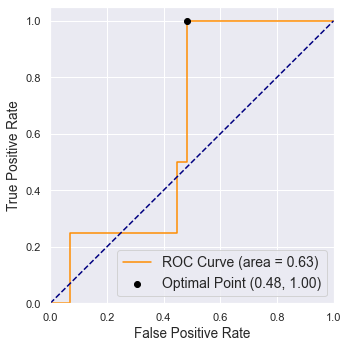

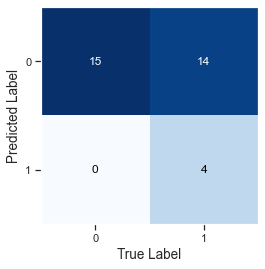

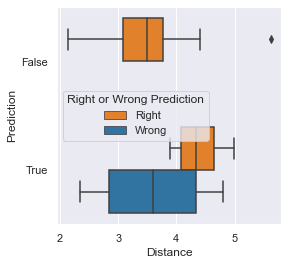


 ###################### Cluster 2 ######################

Accuracy     Balanced Accuracy     Precision     Recall     F1-score
  0.81             0.86              0.62         1.00        0.77

 AUROC     Opt Threshold       AIC         BIC
 0.85           0.30          -22.78      -21.24



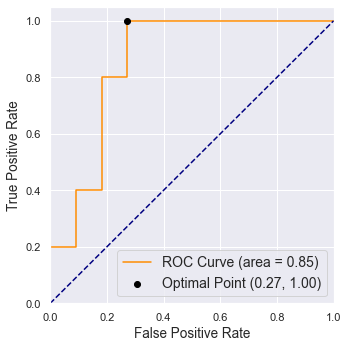

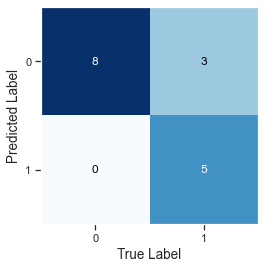

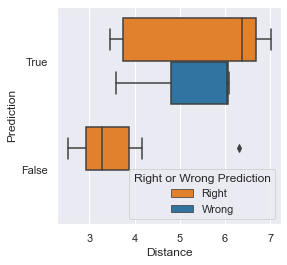


 ###################### Cluster 3 ######################

Accuracy     Balanced Accuracy     Precision     Recall     F1-score
  0.72             0.69              0.54         0.63        0.58

 AUROC     Opt Threshold       AIC         BIC
 0.73           0.41         -193.44     -187.34



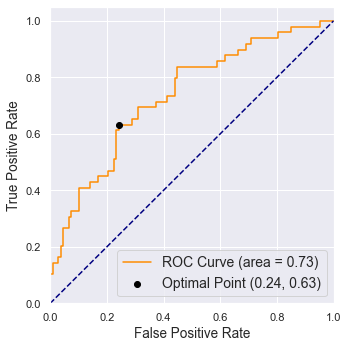

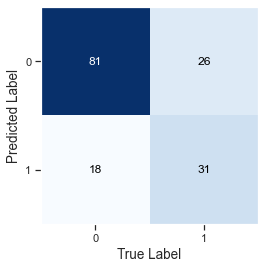

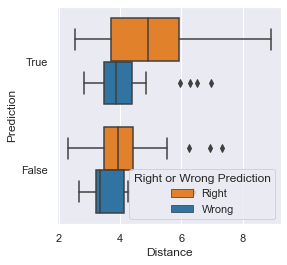


 ###################### Cluster 4 ######################

Accuracy     Balanced Accuracy     Precision     Recall     F1-score
  0.58             0.69              0.25         0.86        0.38

 AUROC     Opt Threshold       AIC         BIC
 0.75           0.07         -156.29     -149.86



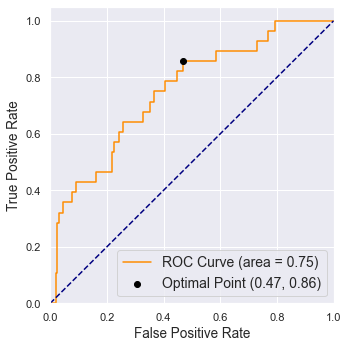

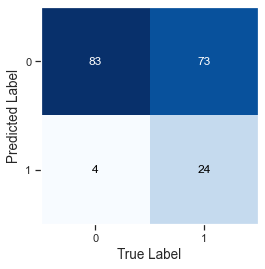

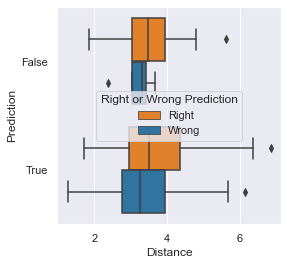


 ###################### Cluster 5 ######################

Accuracy     Balanced Accuracy     Precision     Recall     F1-score
  0.69             0.72              0.27         0.77        0.40

 AUROC     Opt Threshold       AIC         BIC
 0.79           0.11         -594.74     -586.27



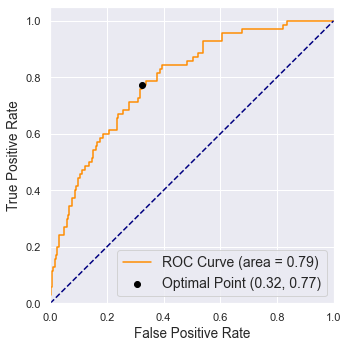

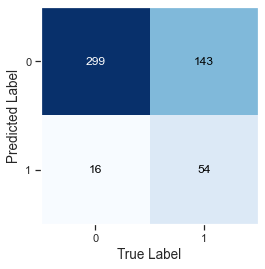

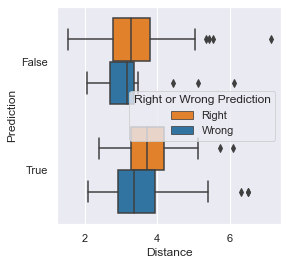

In [22]:
Performance_Metrics_d = {'Accuracy':[], 'Balanced Accuracy':[], 'Precision':[], 'Recall':[], 'F1-score':[]}
test_size = 0
Opt_Threshold_List = []

for n, X, y in Clusters_Data:

    X = X[RFE_columns_List[n-1]]
    
    LR_classifier = Model_List[n-1]
    X_test_cluster = test_dataframes_list[n-1]
    y_test_cluster = test_classes_list[n-1]

    #This is going to be usefull to calculate the performance of all clusters
    test_size = test_size + len(y_test_cluster)

    # last entry 'no' for no plot save, 'yes' for plot save (ROC curve and Confusion Matrix)
    Performance_1(LR_classifier, X_test_cluster, y_test_cluster, n, Performance_Metrics_d, Opt_Threshold_List, 'yes')


In [23]:
# Performance of the clusters in test combined

for n, X, y in Clusters_Data:

    X_test_cluster = test_dataframes_list[n-1]
    size_w = len(X_test_cluster)/test_size

    Performance_Metrics_d['Accuracy'][n-1] = Performance_Metrics_d['Accuracy'][n-1]*size_w
    Performance_Metrics_d['Balanced Accuracy'][n-1] = Performance_Metrics_d['Balanced Accuracy'][n-1]*size_w
    Performance_Metrics_d['Precision'][n-1] = Performance_Metrics_d['Precision'][n-1]*size_w
    Performance_Metrics_d['Recall'][n-1] = Performance_Metrics_d['Recall'][n-1]*size_w
    Performance_Metrics_d['F1-score'][n-1] = Performance_Metrics_d['F1-score'][n-1]*size_w

print(' ######################  Test Performance Combined  ###################### ')
print()
print('Accuracy     Balanced Accuracy     Precision     Recall     F1-score')
print('%6.2f' % sum(Performance_Metrics_d['Accuracy']), '%16.2f' % sum(Performance_Metrics_d['Balanced Accuracy']), '%17.2f' % sum(Performance_Metrics_d['Precision']), '%12.2f' % sum(Performance_Metrics_d['Recall']), '%11.2f' % sum(Performance_Metrics_d['F1-score']))

    

 ######################  Test Performance Combined  ###################### 

Accuracy     Balanced Accuracy     Precision     Recall     F1-score
  0.67             0.72              0.32         0.78        0.44


# Performance on Test 2 (via weights)

In [24]:
# Get probabilities using all test Data for each cluster
Probabilities_all =  []

for n, X, y in Clusters_Data:

    X = X[RFE_columns_List[n-1]]

    LR_classifier = Model_List[n-1]

    # Turn the test features the same after RFE
    X_test_less_features = X_test[X.columns]

    Probabilities = LR_classifier.predict_proba(X_test_less_features)[:,1]

    Probabilities_all.append(Probabilities)

In [25]:
# Get probabiliteis tanking into account the weights of each model
Final_probs_list = []

for index, row in X_test.iterrows():

    # List with all probabilities*weight of a observation
    One_observation_probs = []

    for n, X, y in Clusters_Data:

        prob_obs_one = Probabilities_all[n-1][index]
        weight_obs_one = weights_all[index][n-1]

        prob_weight = prob_obs_one * weight_obs_one

        One_observation_probs.append(prob_weight)

    # Sum the probabilities*weight
    final_prob = sum(One_observation_probs)

    Final_probs_list.append(final_prob)


Accuracy     Balanced Accuracy     Precision     Recall     F1-score
  0.72             0.73              0.35         0.74        0.48

 AUROC     Opt Threshold
 0.78           0.18



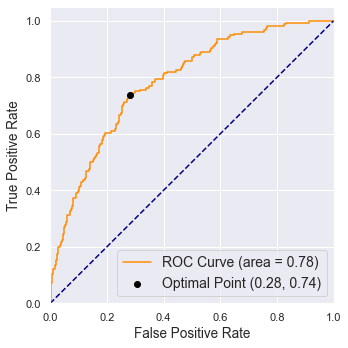

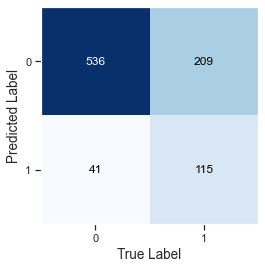

In [26]:
# Here we have to use LR_classifier.predict_proba(X_test)[:,1] and not y_pred
fpr, tpr, thresholds = metrics.roc_curve(y_test, Final_probs_list, pos_label=1)
auc_roc = metrics.auc(fpr, tpr)
#print(auc_roc)

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
#print('optimal idx :', optimal_idx)
#print('optimal threshold :', optimal_threshold)
#print('tpr optimal idx:', tpr[optimal_idx])
#print('fpr optimal idx:', fpr[optimal_idx])

#Define optimal threshold
y_pred = (Final_probs_list >= optimal_threshold).astype(bool)

#print(confusion_matrix(y_test_cluster,y_pred))
#print(classification_report(y_test,y_pred))
#print('accuracy_score: ', accuracy_score(y_test, y_pred))
#print('balanced_accuracy_score: ', balanced_accuracy_score(y_test, y_pred))
#print()

print('Accuracy     Balanced Accuracy     Precision     Recall     F1-score')
print('%6.2f' % accuracy_score(y_test,y_pred), '%16.2f' % balanced_accuracy_score(y_test,y_pred), '%17.2f' % precision_score(y_test,y_pred), '%12.2f' % recall_score(y_test,y_pred), '%11.2f' % f1_score(y_test,y_pred))
print()
print(' AUROC     Opt Threshold')
print( '%5.2f' % auc_roc, '%14.2f' % optimal_threshold)
print()

# ROC curve
sns.set(rc={"figure.figsize":(5, 5)})

plt.plot(fpr, tpr, color='darkorange',
 label='ROC Curve (area = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.scatter([fpr[optimal_idx]], [tpr[optimal_idx]], color="black", zorder=5,
 label='Optimal Point (%0.2f, %0.2f)' % (fpr[optimal_idx], tpr[optimal_idx]))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate', fontsize=13.5)
plt.ylabel('True Positive Rate', fontsize=13.5)
plt.legend(loc="lower right", fontsize=14)

plt.tight_layout()
plt.savefig('Clustering Plots/Weights ROC Curve')
plt.show()

# Confusion Matrix
sns.set(rc={"figure.figsize":(4, 4)})

c_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(c_matrix)

plt.xlabel('True Label', fontsize=13.5)
plt.ylabel('Predicted Label', fontsize=13.5)

plt.savefig('Clustering Plots/Weights Confusion Matrix')
plt.show()

In [27]:
# Load global results

Global_Probabilities_List = np.load('Models/Other Results/Probabilities LR Mortality 24-48h.npy')
Global_Threshold = np.load('Models/Other Results/Treshold LR Mortality 24-48h.npy')

Probabilities_Comparison_Df = pd.DataFrame({'Global Probabilities':Global_Probabilities_List, 'Weights Probabilities':Final_probs_list, 'True Probabilities':y_test})
print(len(Probabilities_Comparison_Df))

901


All 1.0 true label : 156
All true 1.0 correctly predicted in both models : 111
Global probability is bigger in : 0.7207207207207207
Weights probability is bigger in : 0.27927927927927926

All 0.0 true label : 745
All true 0.0 correctly predicted in both models : 493
Global probability is bigger in : 0.16227180527383367
Weights probability is bigger in : 0.8377281947261663

All 0.0 true label : 745
All false 1.0 wrongly predicted in both models : 160
Global probability is bigger in : 0.66875
Weights probability is bigger in : 0.33125

All 1.0 true label : 156
All false 0.0 wrongly predicted in both models : 37
Global probability is bigger in : 0.10810810810810811
Weights probability is bigger in : 0.8918918918918919



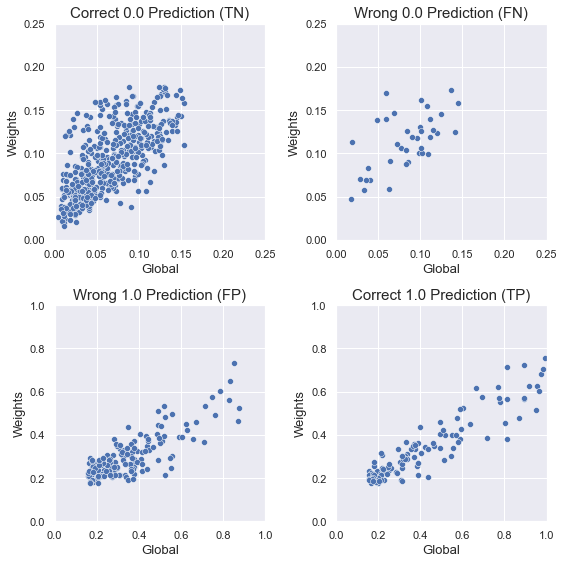

In [28]:
sns.set(rc={"figure.figsize":(8, 8)})
fig, ax = plt.subplots(2,2)

# For correct 1.0 prediction
# TP
Probabilities_Comparison_Df_1 = Probabilities_Comparison_Df.loc[Probabilities_Comparison_Df['True Probabilities']==1]
print('All 1.0 true label :', len(Probabilities_Comparison_Df_1))

Probabilities_Comparison_Df_1 = Probabilities_Comparison_Df_1.loc[Probabilities_Comparison_Df['Weights Probabilities']>=optimal_threshold]
Probabilities_Comparison_Df_1 = Probabilities_Comparison_Df_1.loc[Probabilities_Comparison_Df['Global Probabilities']>=Global_Threshold]
print('All true 1.0 correctly predicted in both models :', len(Probabilities_Comparison_Df_1))

P_Global_List = list(Probabilities_Comparison_Df_1['Global Probabilities'])
P_Weights_List = list(Probabilities_Comparison_Df_1['Weights Probabilities'])

P_Global_Bigger = 0
P_Weights_Bigger = 0
for P_Global, P_Weights in list(zip(P_Global_List, P_Weights_List)):
    if P_Global > P_Weights:
        P_Global_Bigger = P_Global_Bigger + 1
    elif P_Weights > P_Global:
        P_Weights_Bigger = P_Weights_Bigger + 1

print('Global probability is bigger in :', P_Global_Bigger/len(P_Global_List))
print('Weights probability is bigger in :', P_Weights_Bigger/len(P_Global_List))
print()


sns.scatterplot(x=P_Global_List, y=P_Weights_List, ax=ax[1, 1])
ax[1, 1].set_ylabel('Weights', fontsize=13)
ax[1, 1].set_xlabel('Global', fontsize=13)
ax[1, 1].set_title('Correct 1.0 Prediction (TP)', fontsize=15)
ax[1, 1].axis([0, 1, 0, 1])

# For correct 0.0 prediction
# TN
Probabilities_Comparison_Df_1 = Probabilities_Comparison_Df.loc[Probabilities_Comparison_Df['True Probabilities']==0]
print('All 0.0 true label :', len(Probabilities_Comparison_Df_1))

Probabilities_Comparison_Df_1 = Probabilities_Comparison_Df_1.loc[Probabilities_Comparison_Df['Weights Probabilities']<optimal_threshold]
Probabilities_Comparison_Df_1 = Probabilities_Comparison_Df_1.loc[Probabilities_Comparison_Df['Global Probabilities']<Global_Threshold]
print('All true 0.0 correctly predicted in both models :', len(Probabilities_Comparison_Df_1))

P_Global_List = list(Probabilities_Comparison_Df_1['Global Probabilities'])
P_Weights_List = list(Probabilities_Comparison_Df_1['Weights Probabilities'])

P_Global_Bigger = 0
P_Weights_Bigger = 0
for P_Global, P_Weights in list(zip(P_Global_List, P_Weights_List)):
    if P_Global > P_Weights:
        P_Global_Bigger = P_Global_Bigger + 1
    elif P_Weights > P_Global:
        P_Weights_Bigger = P_Weights_Bigger + 1

print('Global probability is bigger in :', P_Global_Bigger/len(P_Global_List))
print('Weights probability is bigger in :', P_Weights_Bigger/len(P_Global_List))
print()

sns.scatterplot(x=P_Global_List, y=P_Weights_List, ax=ax[0, 0])
ax[0, 0].set_ylabel('Weights', fontsize=13)
ax[0, 0].set_xlabel('Global', fontsize=13)
ax[0, 0].set_title('Correct 0.0 Prediction (TN)', fontsize=15)
ax[0, 0].axis([0, 0.25, 0, 0.25])

# For wrong 1.0 prediction
# FP
Probabilities_Comparison_Df_1 = Probabilities_Comparison_Df.loc[Probabilities_Comparison_Df['True Probabilities']==0]
print('All 0.0 true label :', len(Probabilities_Comparison_Df_1))

Probabilities_Comparison_Df_1 = Probabilities_Comparison_Df_1.loc[Probabilities_Comparison_Df['Weights Probabilities']>=optimal_threshold]
Probabilities_Comparison_Df_1 = Probabilities_Comparison_Df_1.loc[Probabilities_Comparison_Df['Global Probabilities']>=Global_Threshold]
print('All false 1.0 wrongly predicted in both models :', len(Probabilities_Comparison_Df_1))

P_Global_List = list(Probabilities_Comparison_Df_1['Global Probabilities'])
P_Weights_List = list(Probabilities_Comparison_Df_1['Weights Probabilities'])

P_Global_Bigger = 0
P_Weights_Bigger = 0
for P_Global, P_Weights in list(zip(P_Global_List, P_Weights_List)):
    if P_Global > P_Weights:
        P_Global_Bigger = P_Global_Bigger + 1
    elif P_Weights > P_Global:
        P_Weights_Bigger = P_Weights_Bigger + 1

print('Global probability is bigger in :', P_Global_Bigger/len(P_Global_List))
print('Weights probability is bigger in :', P_Weights_Bigger/len(P_Global_List))
print()

sns.scatterplot(x=P_Global_List, y=P_Weights_List, ax=ax[1, 0])
ax[1, 0].set_ylabel('Weights', fontsize=13)
ax[1, 0].set_xlabel('Global', fontsize=13)
ax[1, 0].set_title('Wrong 1.0 Prediction (FP)', fontsize=15)
ax[1, 0].axis([0, 1, 0, 1])

# For wrong 0.0 prediction
# FN
Probabilities_Comparison_Df_1 = Probabilities_Comparison_Df.loc[Probabilities_Comparison_Df['True Probabilities']==1]
print('All 1.0 true label :', len(Probabilities_Comparison_Df_1))

Probabilities_Comparison_Df_1 = Probabilities_Comparison_Df_1.loc[Probabilities_Comparison_Df['Weights Probabilities']<optimal_threshold]
Probabilities_Comparison_Df_1 = Probabilities_Comparison_Df_1.loc[Probabilities_Comparison_Df['Global Probabilities']<Global_Threshold]
print('All false 0.0 wrongly predicted in both models :', len(Probabilities_Comparison_Df_1))

P_Global_List = list(Probabilities_Comparison_Df_1['Global Probabilities'])
P_Weights_List = list(Probabilities_Comparison_Df_1['Weights Probabilities'])

P_Global_Bigger = 0
P_Weights_Bigger = 0
for P_Global, P_Weights in list(zip(P_Global_List, P_Weights_List)):
    if P_Global > P_Weights:
        P_Global_Bigger = P_Global_Bigger + 1
    elif P_Weights > P_Global:
        P_Weights_Bigger = P_Weights_Bigger + 1

print('Global probability is bigger in :', P_Global_Bigger/len(P_Global_List))
print('Weights probability is bigger in :', P_Weights_Bigger/len(P_Global_List))
print()

sns.scatterplot(x=P_Global_List, y=P_Weights_List, ax=ax[0, 1])
ax[0, 1].set_ylabel('Weights', fontsize=13)
ax[0, 1].set_xlabel('Global', fontsize=13)
ax[0, 1].set_title('Wrong 0.0 Prediction (FN)', fontsize=15)
ax[0, 1].axis([0, 0.25, 0, 0.25])

plt.tight_layout()
plt.savefig('Clustering Plots/Scatter Plots Matrix')
plt.show()

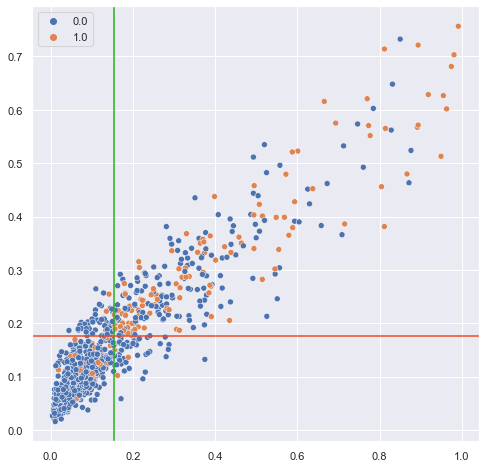

In [29]:
# Compare probabilities between ways of predicting test data
# Green Line: Menbership
# Red Line: Weights
sns.scatterplot(x=Global_Probabilities_List, y=Final_probs_list, hue=y_test)
plt.axvline(x=Global_Threshold, color = '#23B418') 
plt.axhline(y=optimal_threshold, color = '#EE4A27')
plt.savefig('Clustering Plots/Geral Probabilities ScatterPlot')
plt.show() 

print()

# Compare Probabilites between both methods

In [30]:
# get probabilities of menbership models, separated by assigned cluster:
Menbership_Probabilities_List = []
# get true label
True_label_List = []

for n, X, y in Clusters_Data:
    
    LR_classifier = Model_List[n-1]
    X_test_cluster = test_dataframes_list[n-1]

    y_test_cluster = test_classes_list[n-1]
    True_label_List.append(y_test_cluster)

    Probabilities_pred = LR_classifier.predict_proba(X_test_cluster)[:,1]
    Menbership_Probabilities_List.append(Probabilities_pred)


# get probabilities of weights models, separated by assigned cluster in menbership:
Weights_Probabilities_List = []

# Let's iterate over every test data that is separated into clusters
# and then do the same as done in the weights analysis
for X_test_cluster in test_dataframes_list_all_features:

    # Get probabilities using all test Data for each cluster
    Probabilities_all_clustered =  []
    
    for n, X, y in Clusters_Data:

        LR_classifier = Model_List[n-1]

        #X_test_cluster = test_dataframes_list[n-1]

        Probabilities = LR_classifier.predict_proba(X_test_cluster[RFE_columns_List[n-1]])[:,1]

        Probabilities_all_clustered.append(Probabilities)

    # Get probabiliteis tanking into account the weights of each model
    Final_probs_list_clustered = []

    for index, row in X_test_cluster.iterrows():

        # List with all probabilities*weight of a observation
        One_observation_probs = []

        for n, X, y in Clusters_Data:

            prob_obs_one = Probabilities_all_clustered[n-1][index]
            weight_obs_one = weights_all[index][n-1]

            prob_weight = prob_obs_one * weight_obs_one

            One_observation_probs.append(prob_weight)

        # Sum the probabilities*weight
        final_prob = sum(One_observation_probs)

        Final_probs_list_clustered.append(final_prob)

    Weights_Probabilities_List.append(Final_probs_list_clustered)


 ###################### Cluster 1 ######################



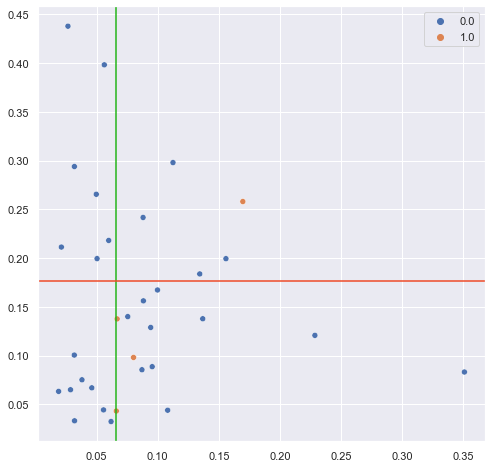


 ###################### Cluster 2 ######################



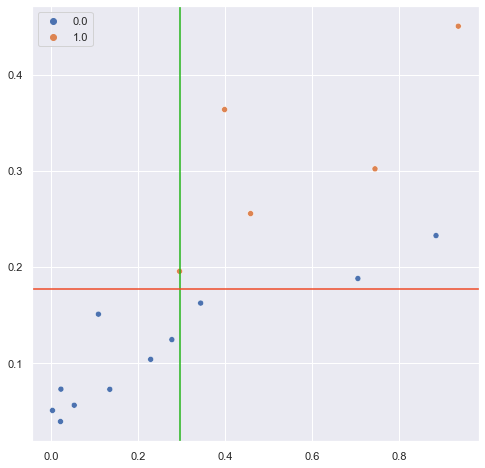


 ###################### Cluster 3 ######################



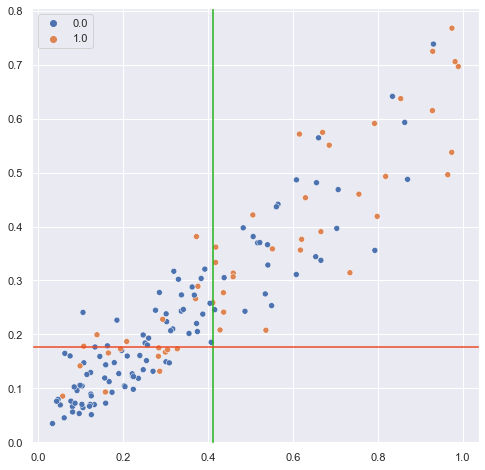


 ###################### Cluster 4 ######################



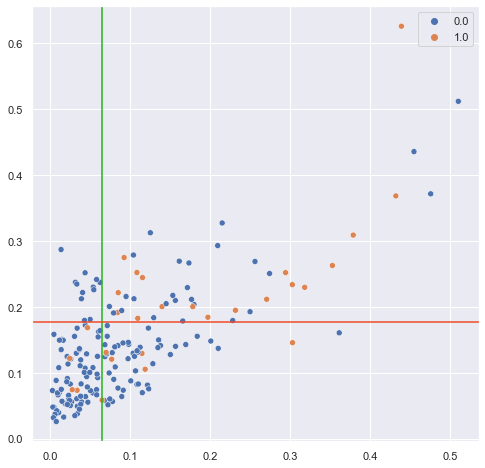


 ###################### Cluster 5 ######################



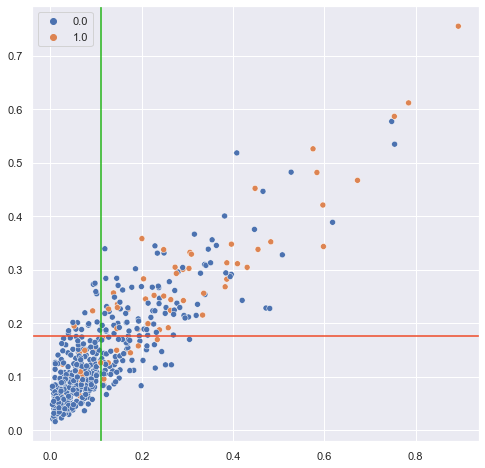

In [31]:
# Green Line: Menbership
# Red Line: Weights

# Compare probabilities between ways of predicting test data
for n, X, y in Clusters_Data:
    print(' ###################### Cluster', n, '######################')
    print()

    sns.scatterplot(x=Menbership_Probabilities_List[n-1], y=Weights_Probabilities_List[n-1], hue=True_label_List[n-1])
    plt.axvline(x=Opt_Threshold_List[n-1], color = '#23B418') 
    plt.axhline(y=optimal_threshold, color = '#EE4A27')
    plt.savefig('Clustering Plots/Cluster {} Probabilities ScatterPlot'.format(n))
    plt.show() 

    print()


# Get Feature Importance

###################### Cluster 1 ######################
        Age  HeartRate
0  0.558378   0.526897


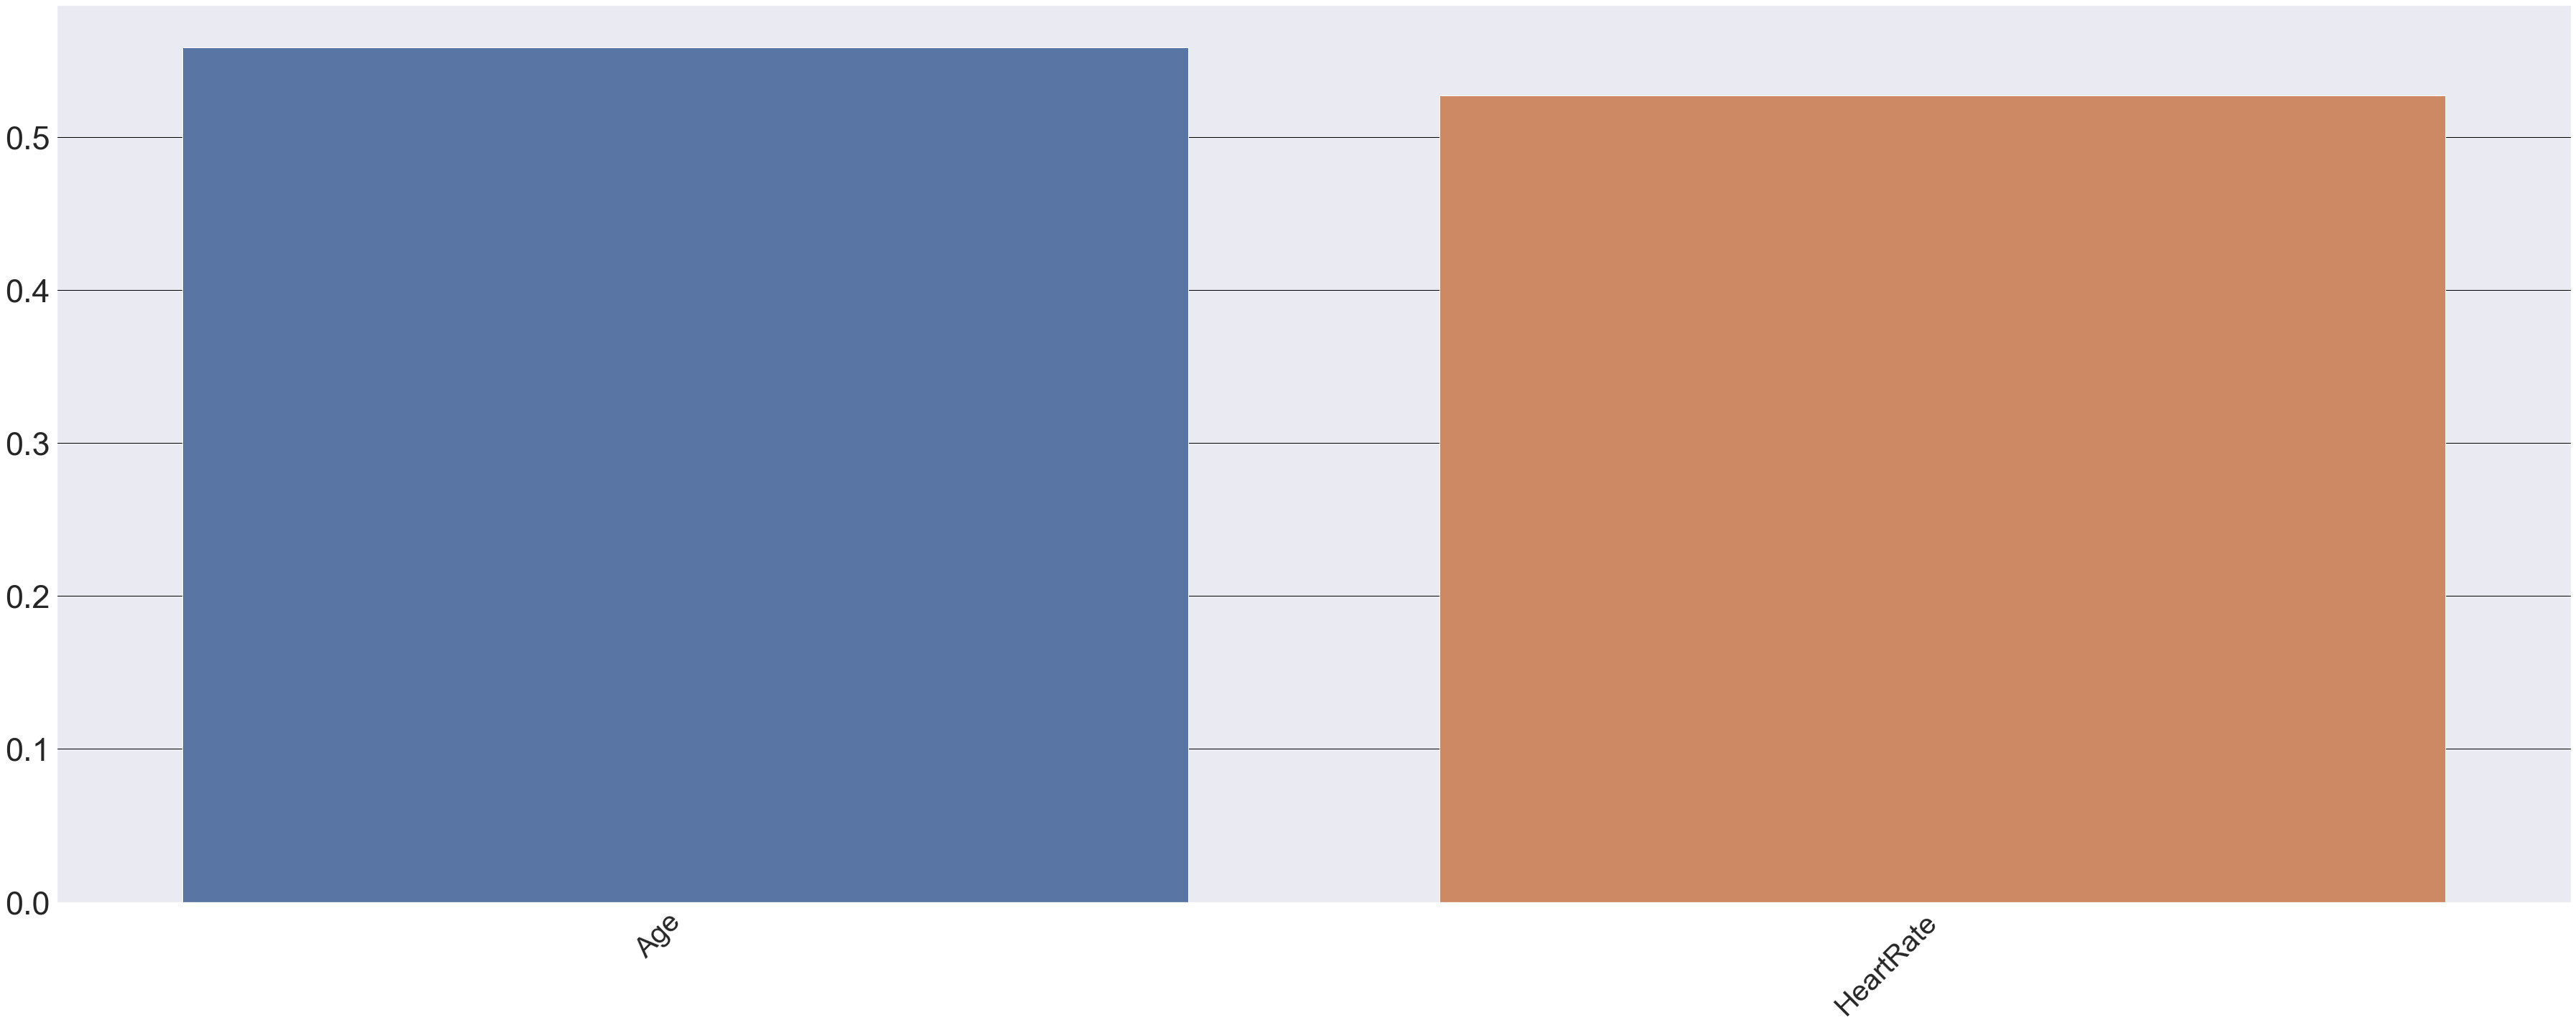


###################### Cluster 2 ######################
   HeartRate       TAD   Lactate     metHb        BE       DHL      Urea  \
0   0.671987 -1.246804  0.656088 -0.624441 -0.601448 -0.507606  0.991767   

   MultiorganD  
0     0.606145  


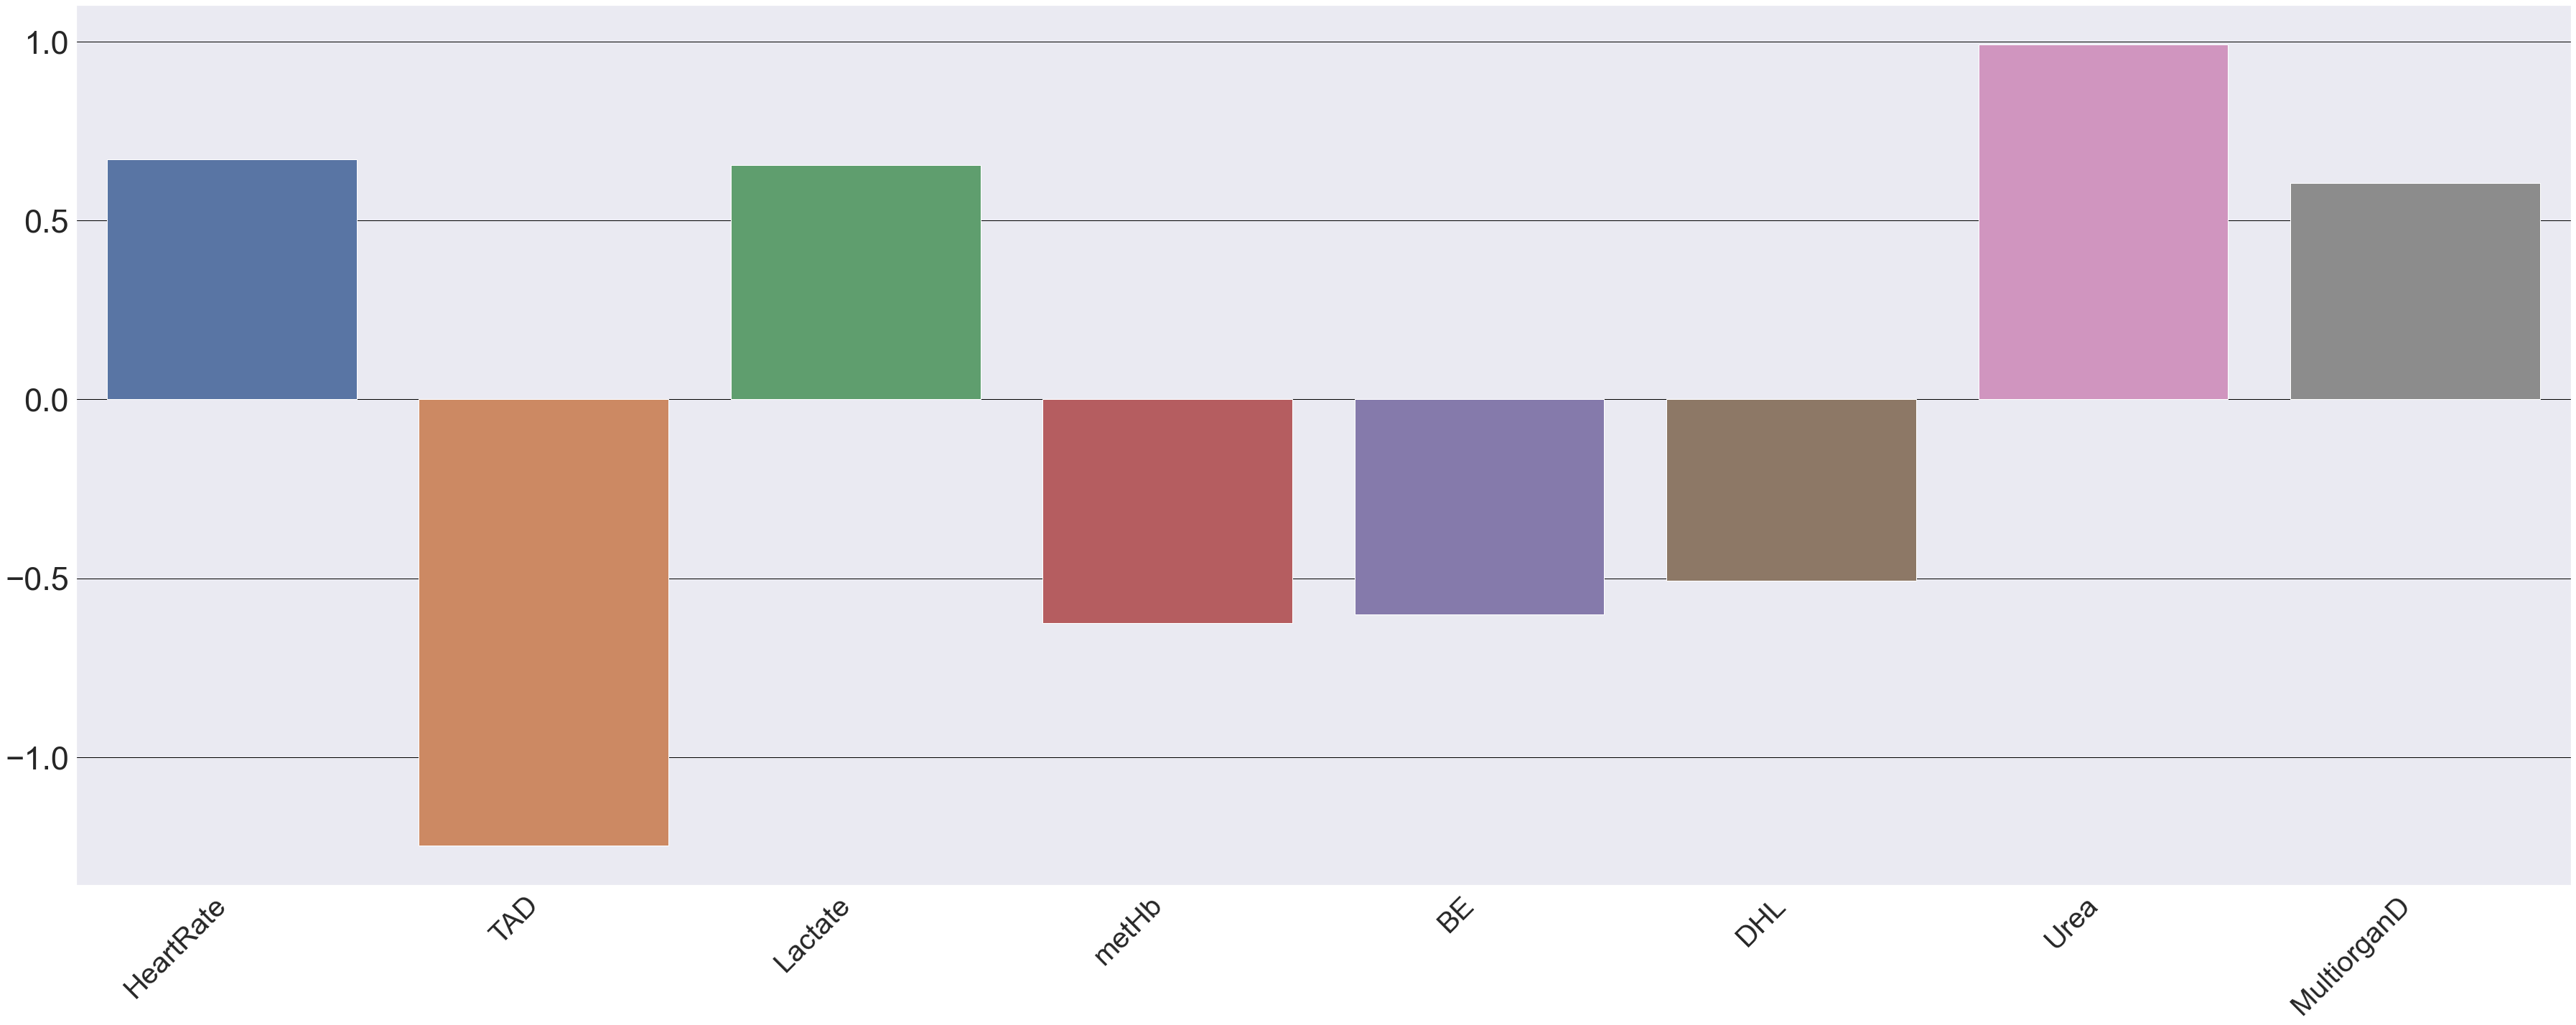


###################### Cluster 3 ######################
        Age  HeartRate       TAD   Lactate     PaCO2   metHb        BE  \
0 -0.218889   0.312732 -0.355542  0.289042  0.421253  0.1487 -0.332731   

    AST/TGO       DHL  AlkalinePhosph       GGT  Lymphocytes  Platelets  \
0 -0.274003  0.761579        0.157942 -0.029159     0.093583  -0.074242   

     Urea   Glasgow  Pneumothorax  MultiorganD  PolyneuroMyopathy     Shock  \
0  0.1138  0.220803     -0.000021     0.216864          -0.184644  0.068671   

      NIVUD  
0 -0.164211  


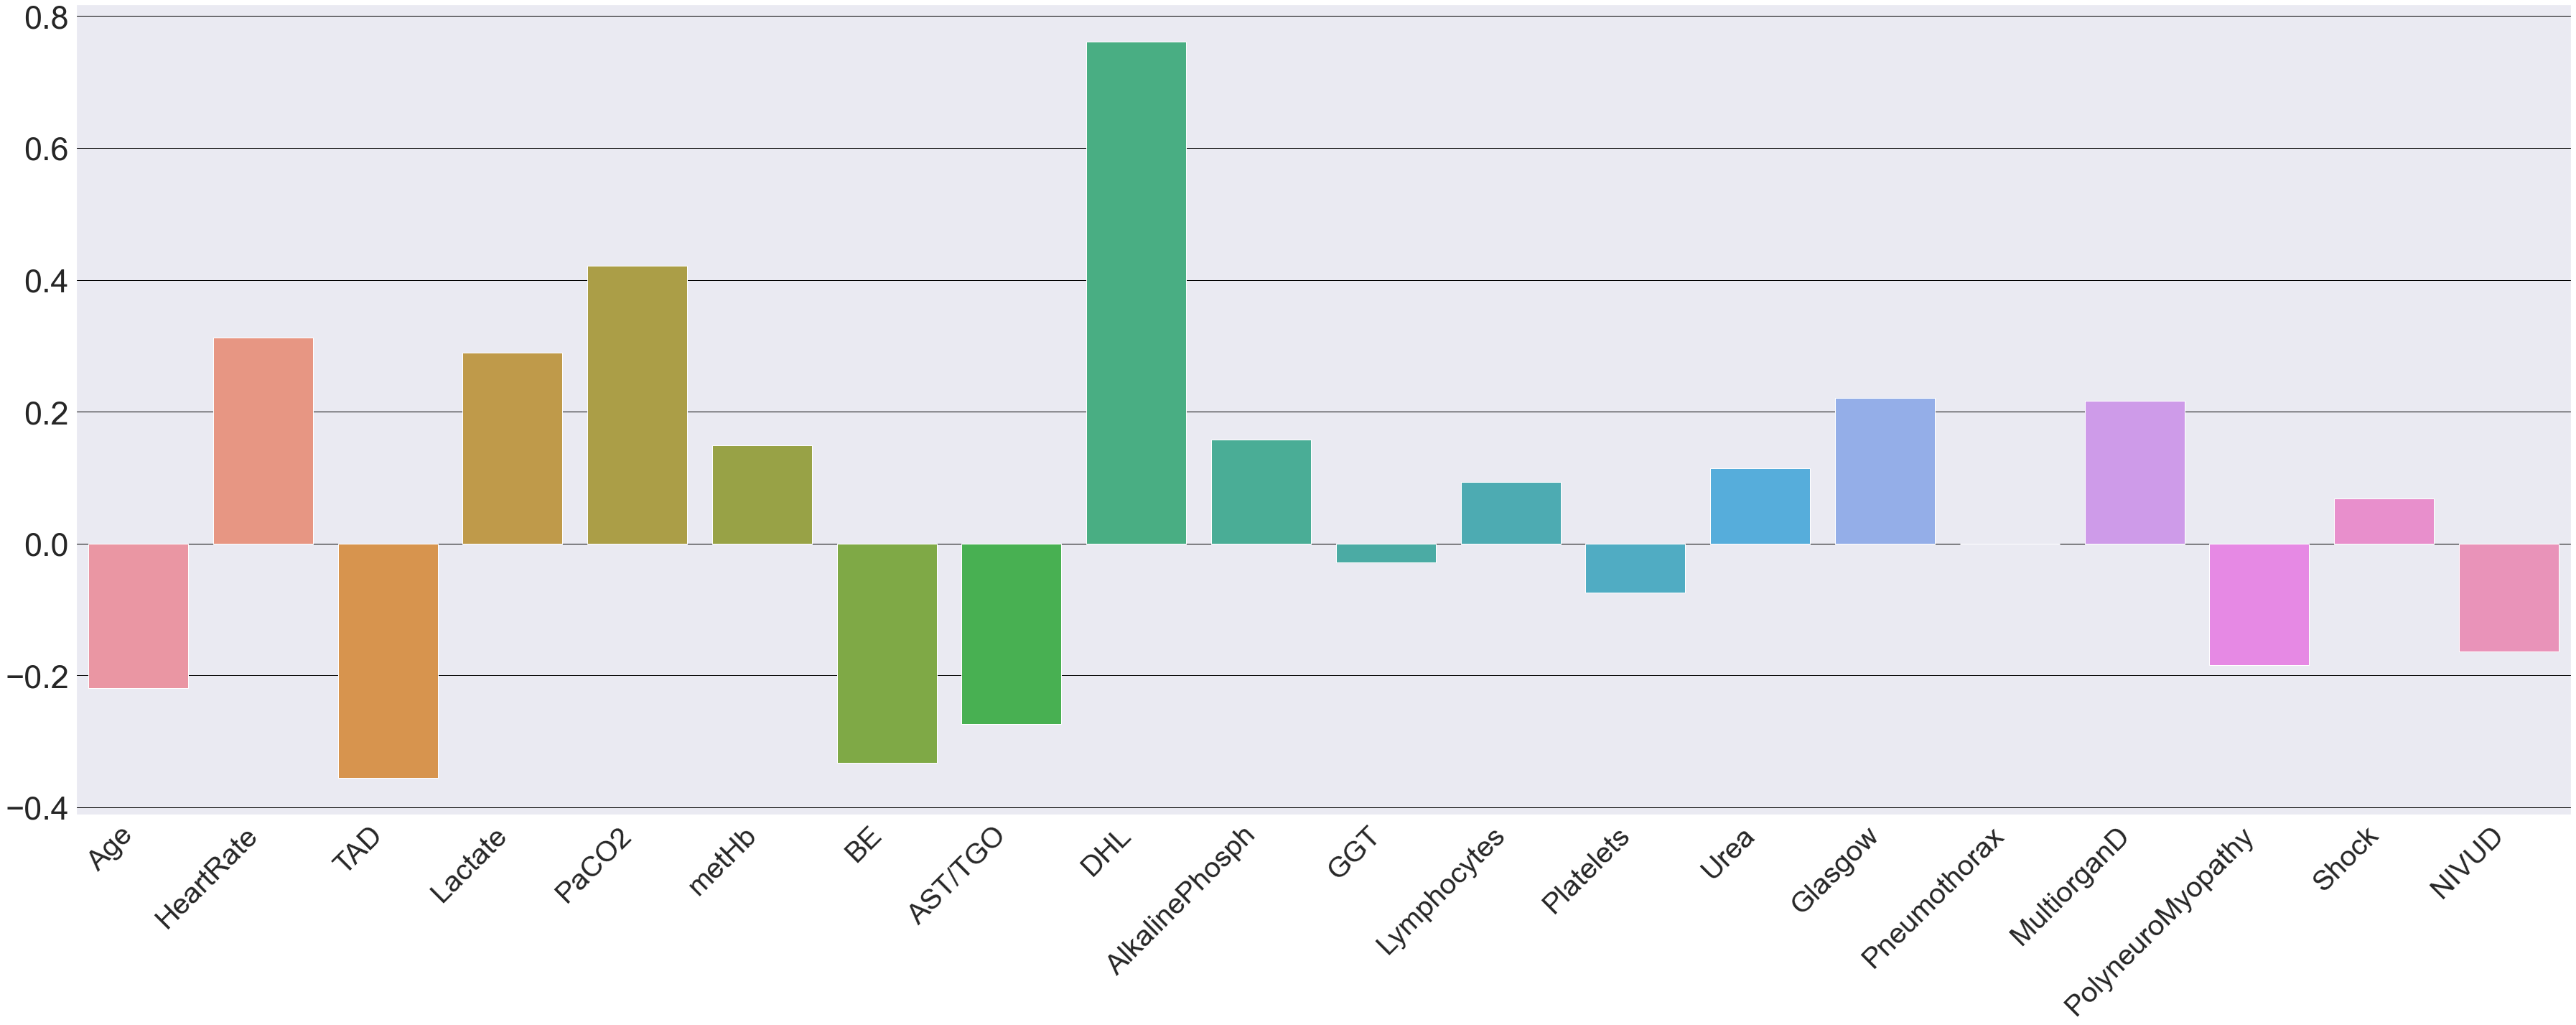


###################### Cluster 4 ######################
        Age     PaCO2     metHb        BE       DHL       GGT
0 -0.705642  0.704932  0.481423 -0.682424  0.648478  0.375648


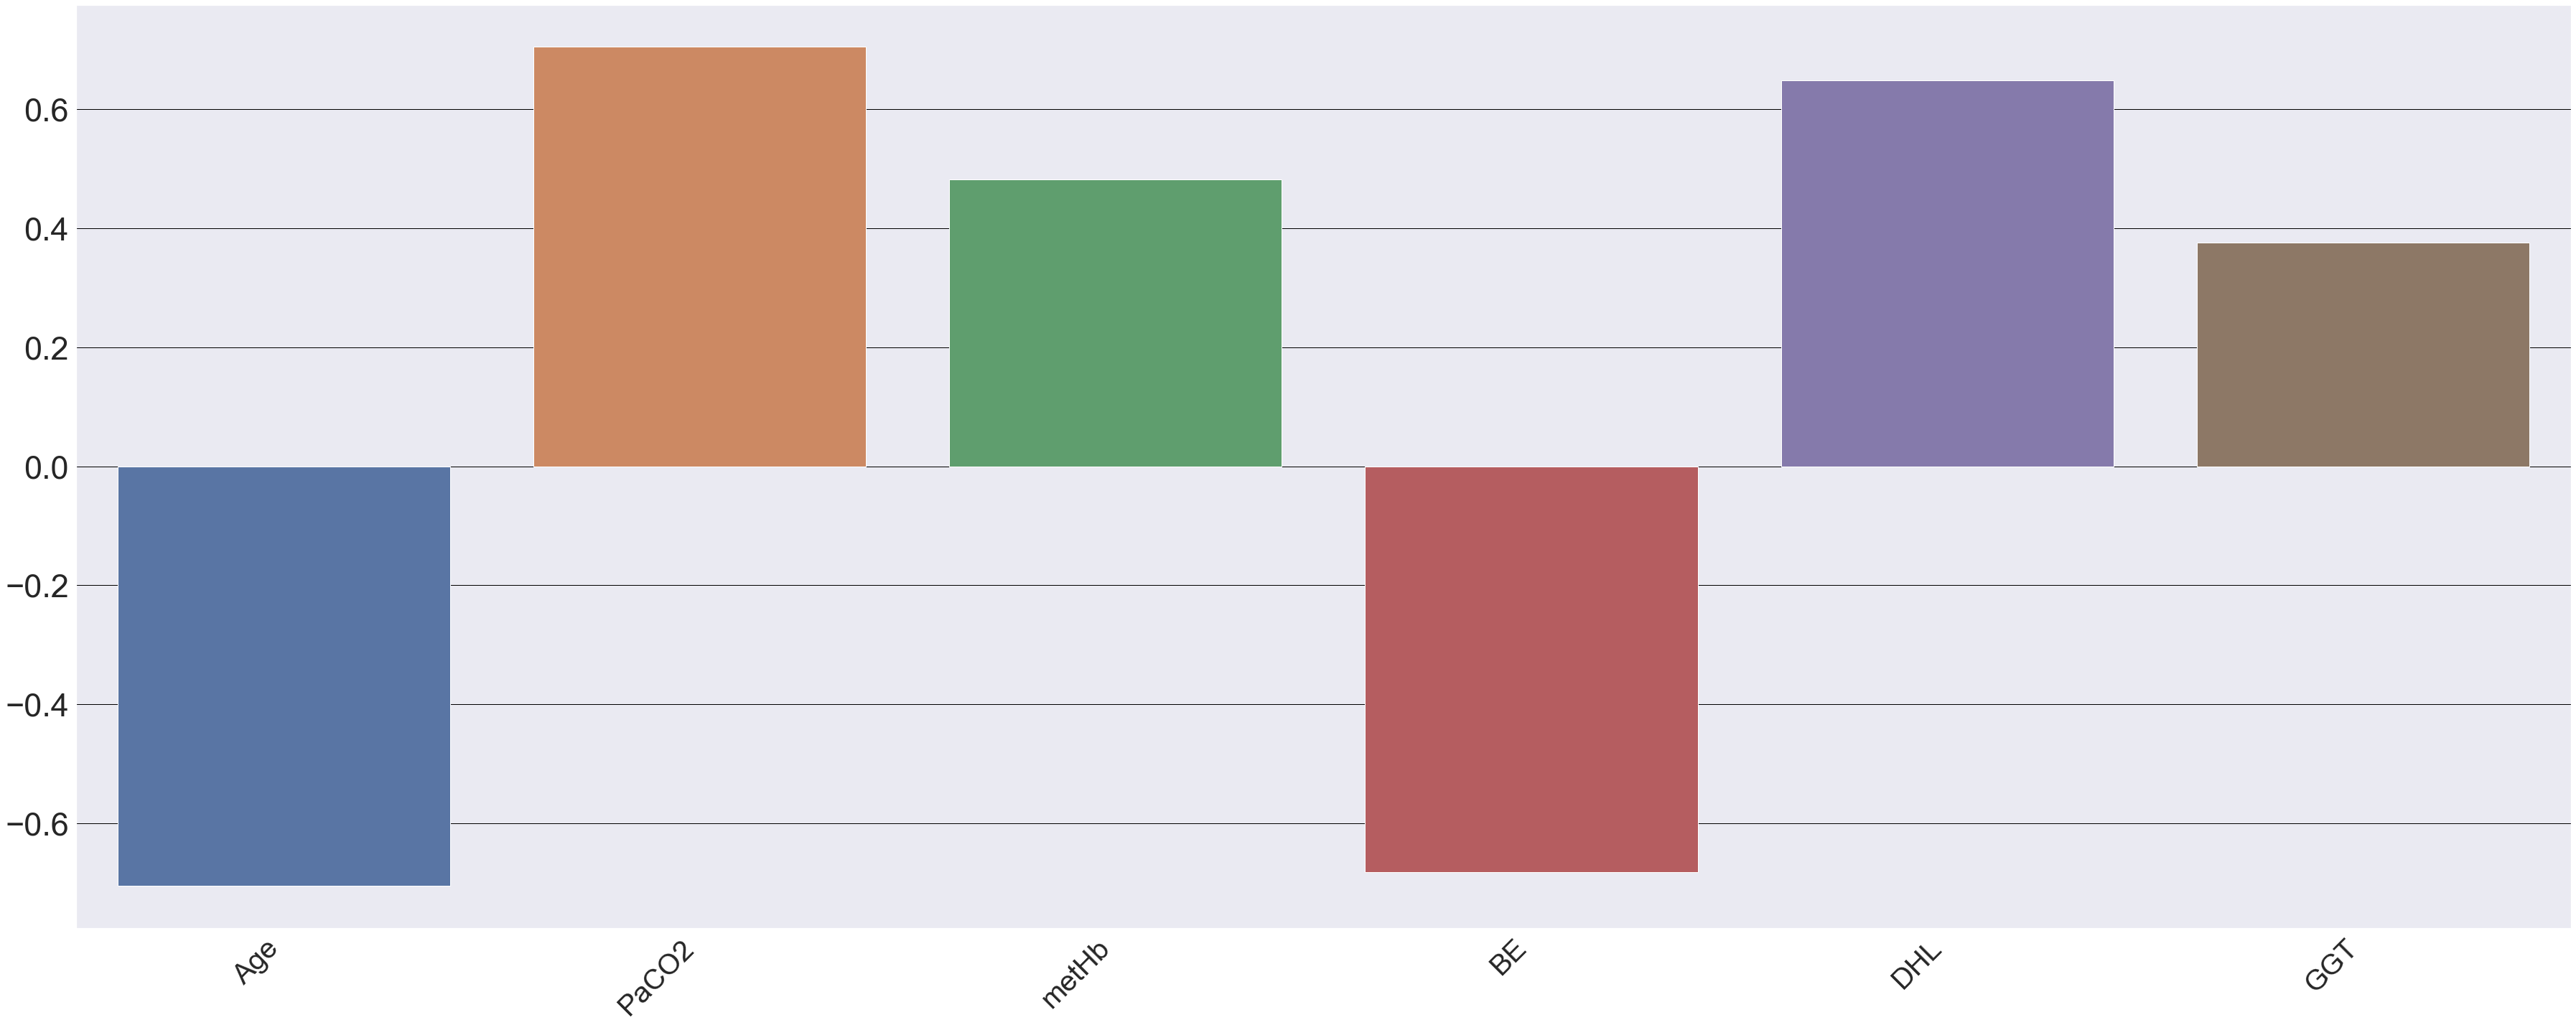


###################### Cluster 5 ######################
        Age  HeartRate       TAD   Lactate     PaCO2     metHb        BE  \
0 -0.457931   0.130377 -0.265575  0.208865  0.375367  0.288748 -0.310268   

   AST/TGO       DHL  AlkalinePhosph       GGT  Lymphocytes  Platelets  \
0 -0.33707  0.599562       -0.456691  0.417933    -0.282127   -0.31032   

       Urea   Glasgow  PolyneuroMyopathy     Shock     NIVUD  
0  0.236068  0.346441          -0.058158  0.016013 -0.131847  


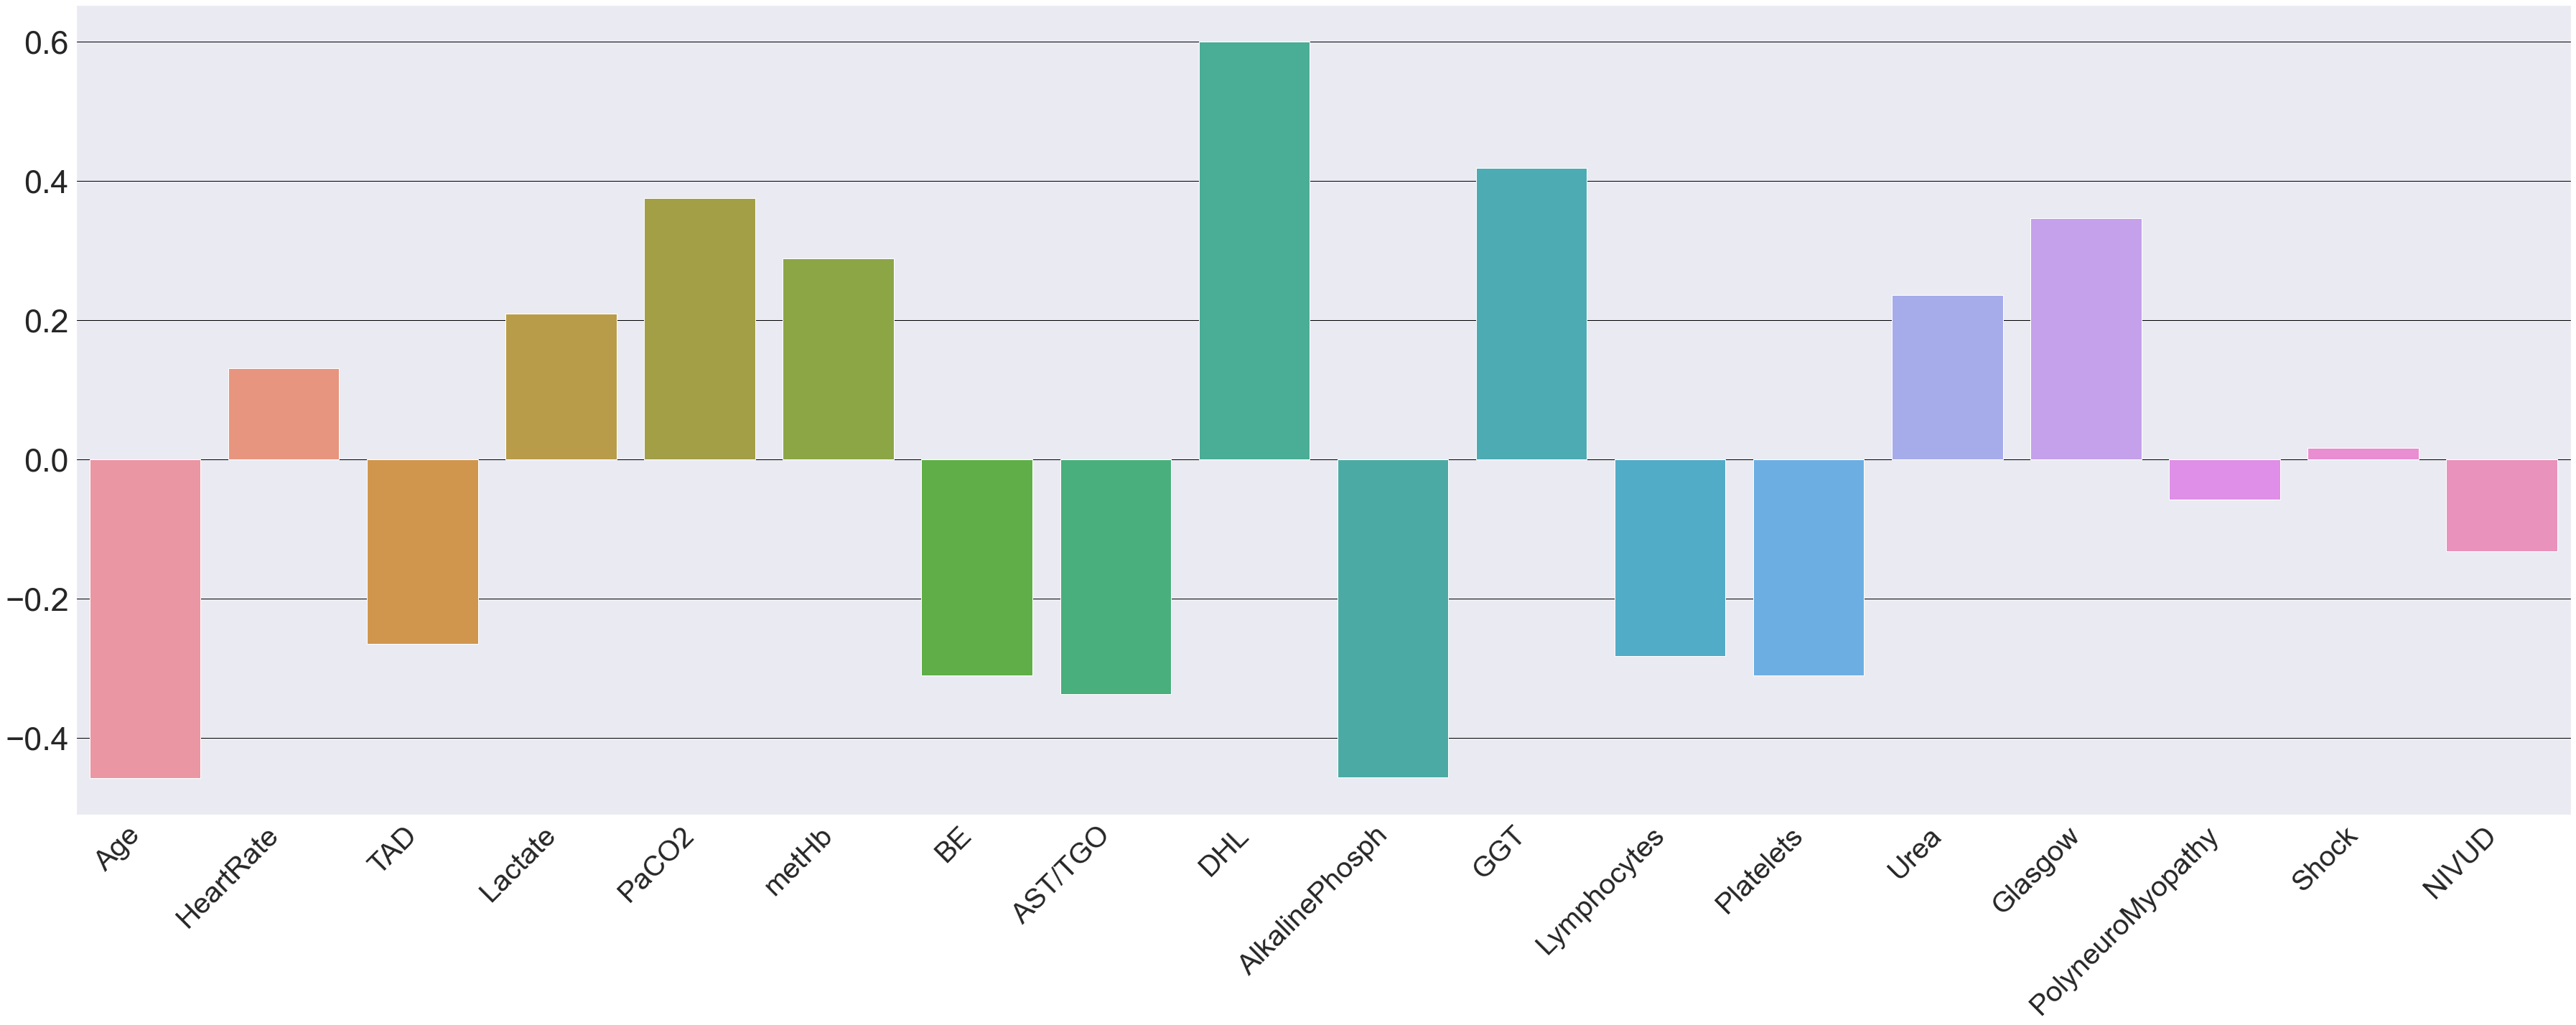

In [32]:
Importance_clusters_List = []

for n, X, y in Clusters_Data:

    if No_Model_List[n-1] == 0:
    
        LR_classifier = Model_List[n-1]

        # get importance
        importance = LR_classifier.coef_[0]
        # And save into a list with all importances of the clusters
        Importance_clusters_List.append(importance)

        X = X[RFE_columns_List[n-1]]

        Df_scores_LR= pd.DataFrame(columns=list(X.columns))
        Df_scores_LR.loc[0] = importance

        # Plot
        print ('###################### Cluster', n, '######################')
        print(Df_scores_LR)
        sns.set(rc={"figure.figsize":(50, 20)})

        ax =sns.barplot(data=Df_scores_LR)

        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=40)

        plt.yticks(fontsize = 45)
        plt.grid(color = 'black', axis = 'y')

        plt.tight_layout()
        plt.savefig('Clustering Plots/Cluster {} Coefficient Importance'.format(n))
        plt.show()

        print()
    else:
        print ('###################### Cluster', n, '######################')
        print()
        print('No coefs for this model')
        print()
    

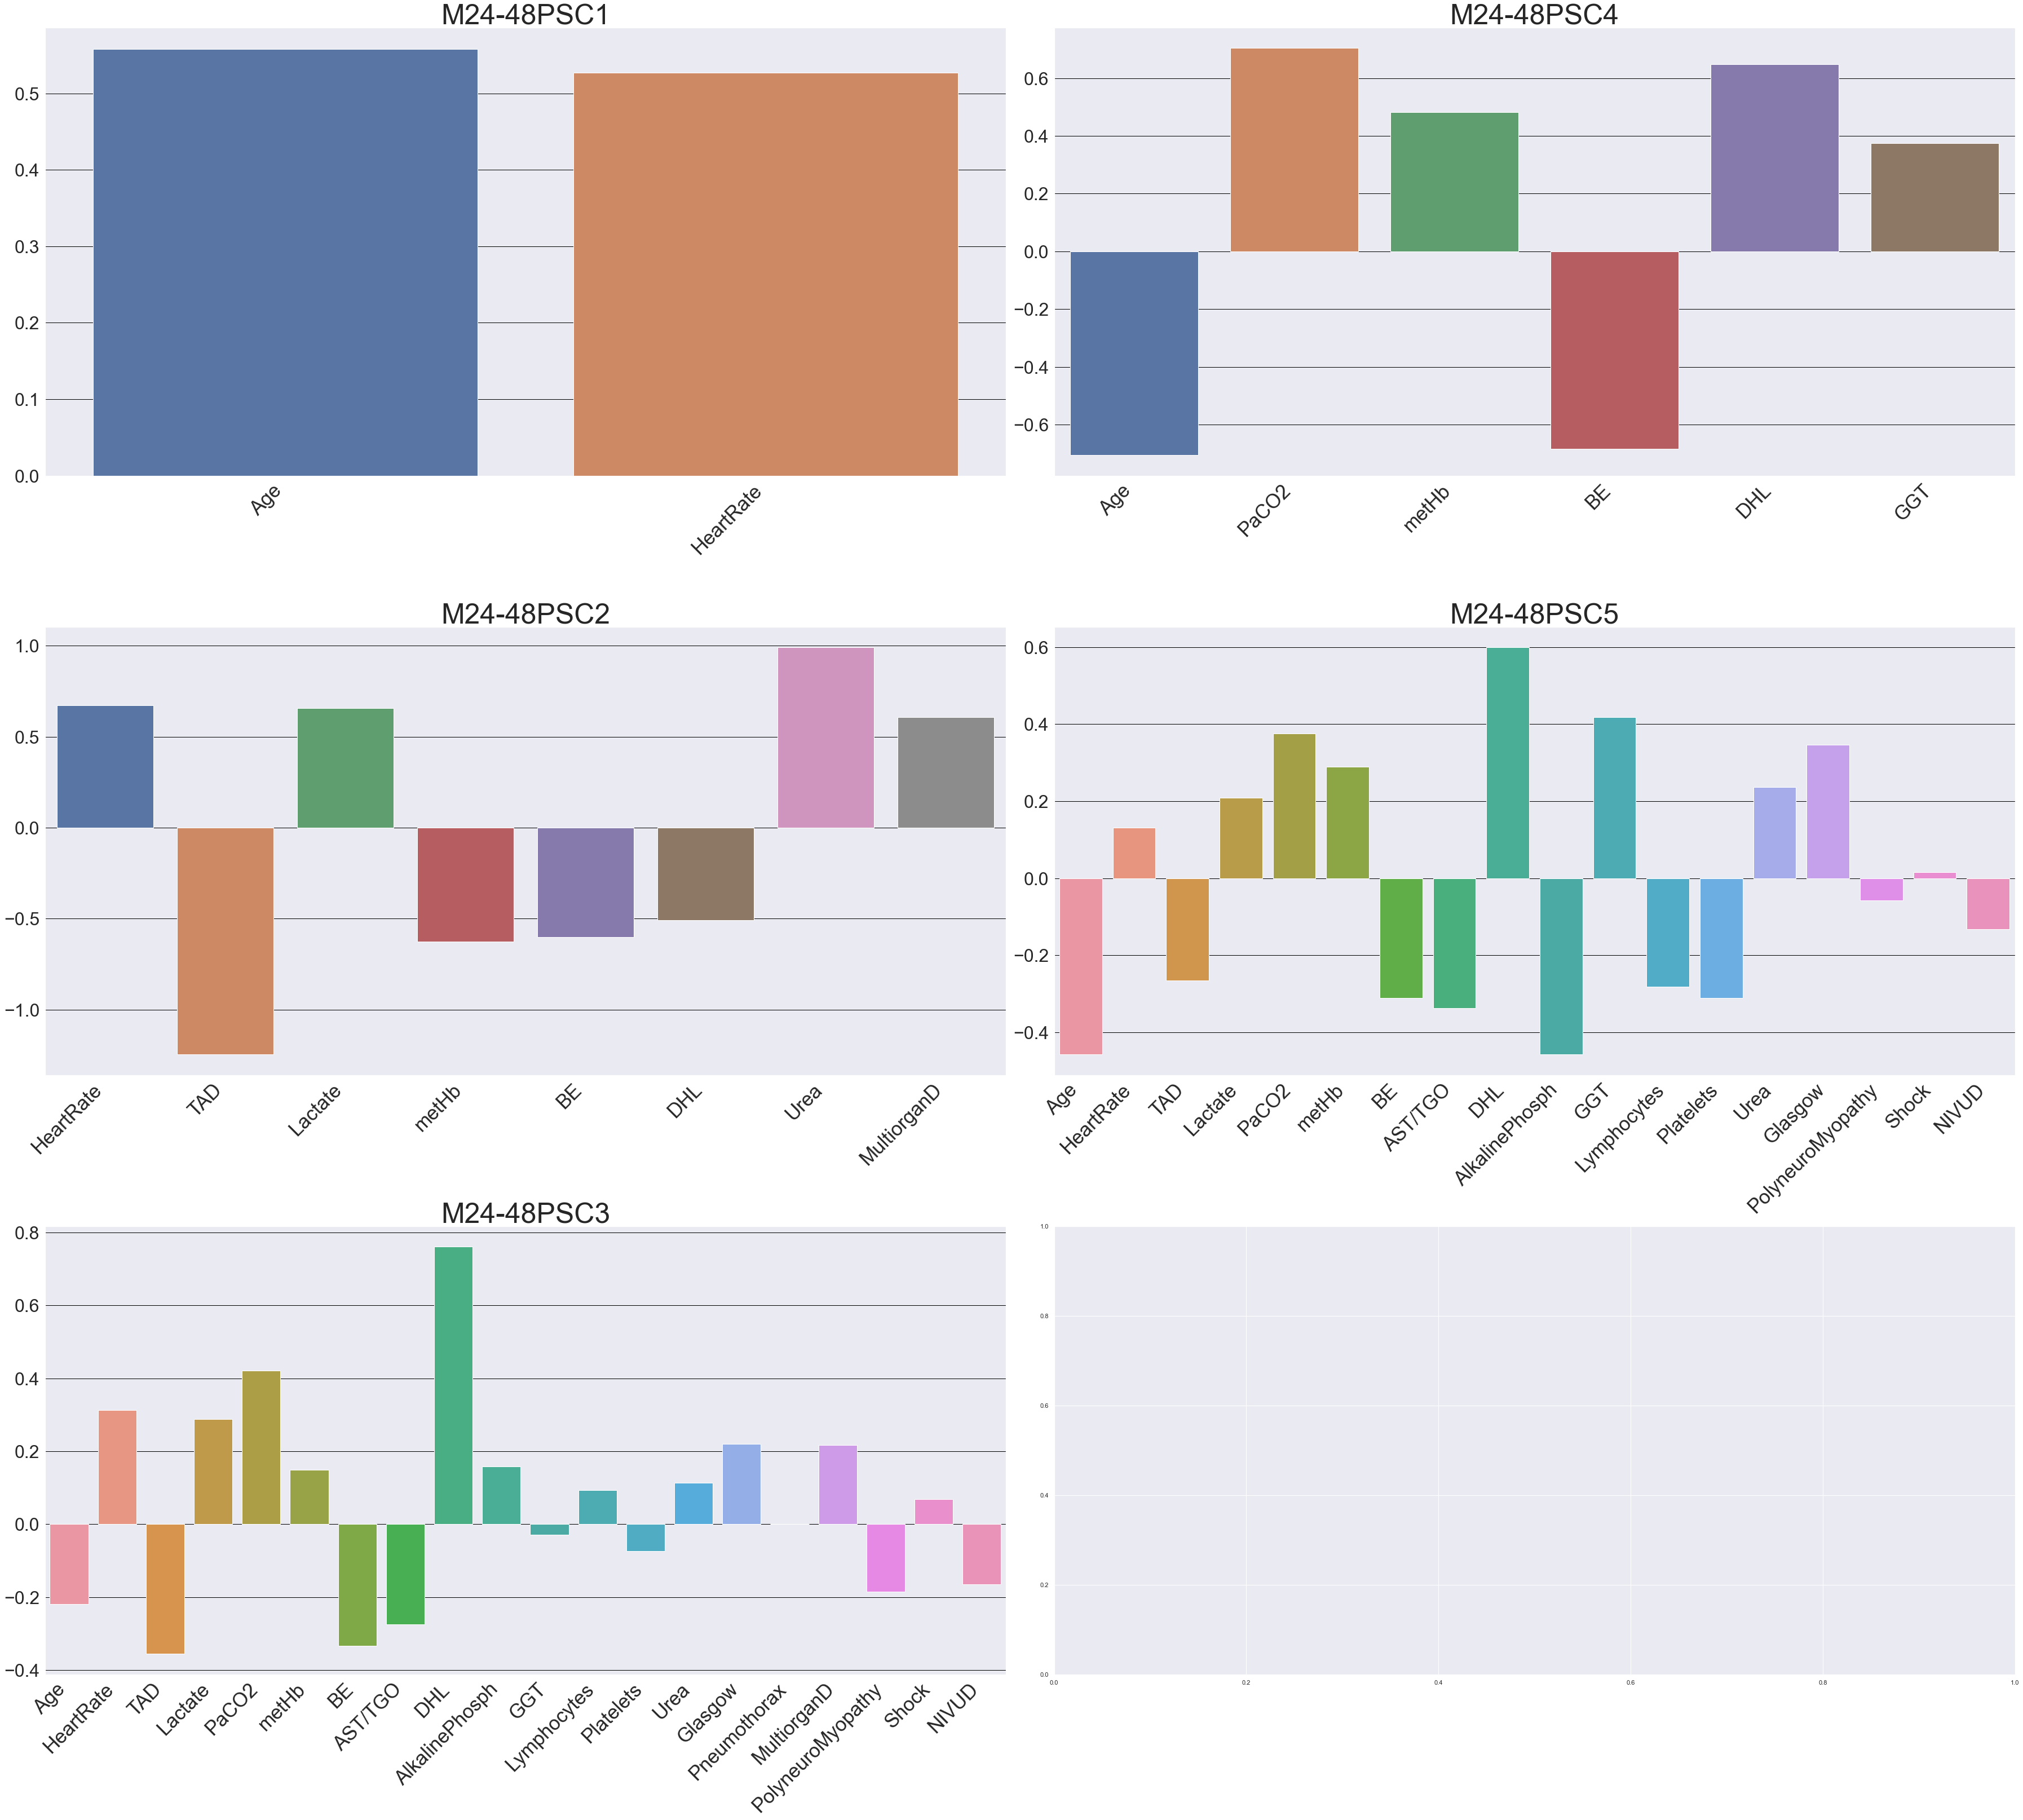

In [33]:
sns.set(rc={"figure.figsize":(50, 45)})
fig, ax = plt.subplots(3,2)
ax1=0
ax2=0

Importance_clusters_List = []

for n, X, y in Clusters_Data:

    if No_Model_List[n-1] == 0:
    
        LR_classifier = Model_List[n-1]

        # get importance
        importance = LR_classifier.coef_[0]
        # And save into a list with all importances of the clusters
        Importance_clusters_List.append(importance)

        X = X[RFE_columns_List[n-1]]

        Df_scores_LR= pd.DataFrame(columns=list(X.columns))
        Df_scores_LR.loc[0] = importance

        # Plot
        sn = sns.barplot(data=Df_scores_LR, ax=ax[ax1, ax2])
        sn.set_xticklabels(sn.get_xticklabels(), rotation=45, ha="right", fontsize=35)
        sn.grid(color = 'black', axis = 'y')
        #sn.set_yticklabels(sn.get_yticklabels(), fontsize=20)
        sn.tick_params(axis='y', labelsize=32)
        sn.set_title('M24-48PSC{}'.format(n), fontsize=50)

        #ax[ax1, ax2].set_title('Cluster :' n, fontsize=15)

        ax1 +=1
        if ax1== 3:
            ax1=0
            ax2+=1 

plt.tight_layout()
plt.savefig('Clustering Plots/All Clusters Coefficient Importance'.format(n))
plt.show()


# Save Model

In [34]:
for n, X, y in Clusters_Data:
    
    LR_classifier = Model_List[n-1]

    # Saving Model
    if No_Model_List[n-1] == 0:
        filename = 'Models/Cluster {} LR Mortality 24-48h.sav'.format(n)
        pickle.dump(LR_classifier, open(filename, 'wb'))
    else:
        filename = 'Models/Cluster {} Dummy Mortality 24-48h.sav'.format(n)
        pickle.dump(LR_classifier, open(filename, 'wb'))

# Loading Model
#LR_classifier = pickle.load(open('Models/LR Mortality 24-48h.sav', 'rb'))

# Applying ADASYN

### Getting Data - ADASYN

In [35]:
X_train_1 = pd.read_csv('Data/Pneumonia_Data_48h/24h-48h/For Clustering/ADASYN_Cluster_1_24h-48h_Mortality_SS_C.csv')
y_train_1 = np.load('Data/Pneumonia_Data_48h/24h-48h/For Clustering/ADASYN_Cluster_1_class_24h-48h_Mortality_SS_C.npy')

X_train_2 = pd.read_csv('Data/Pneumonia_Data_48h/24h-48h/For Clustering/ADASYN_Cluster_2_24h-48h_Mortality_SS_C.csv')
y_train_2 = np.load('Data/Pneumonia_Data_48h/24h-48h/For Clustering/ADASYN_Cluster_2_class_24h-48h_Mortality_SS_C.npy')

X_train_3 = pd.read_csv('Data/Pneumonia_Data_48h/24h-48h/For Clustering/ADASYN_Cluster_3_24h-48h_Mortality_SS_C.csv')
y_train_3 = np.load('Data/Pneumonia_Data_48h/24h-48h/For Clustering/ADASYN_Cluster_3_class_24h-48h_Mortality_SS_C.npy')

X_train_4 = pd.read_csv('Data/Pneumonia_Data_48h/24h-48h/For Clustering/ADASYN_Cluster_4_24h-48h_Mortality_SS_C.csv')
y_train_4 = np.load('Data/Pneumonia_Data_48h/24h-48h/For Clustering/ADASYN_Cluster_4_class_24h-48h_Mortality_SS_C.npy')

X_train_5 = pd.read_csv('Data/Pneumonia_Data_48h/24h-48h/For Clustering/ADASYN_Cluster_5_24h-48h_Mortality_SS_C.csv')
y_train_5 = np.load('Data/Pneumonia_Data_48h/24h-48h/For Clustering/ADASYN_Cluster_5_class_24h-48h_Mortality_SS_C.npy')

# ... can add more if needed

X_test = pd.read_csv('Data/Pneumonia_Data_48h/24h-48h/For Clustering/TEST_24h-48h_Mortality_SS_C_important_features.csv')
y_test = np.load('Data/Pneumonia_Data_48h/24h-48h/For Clustering/TEST_24h-48h_Mortality_SS_C_class.npy')

No_Model_List = np.load('Data/Pneumonia_Data_48h/24h-48h/For Clustering/No_Model_List_24h-48h_Mortality_SS_C.npy')

In [36]:
# Define list of cluster data
Clusters_Data = [(1, X_train_1, y_train_1), (2, X_train_2, y_train_2), (3, X_train_3, y_train_3), (4, X_train_4, y_train_4), (5, X_train_5, y_train_5)]

### Separate Test Data for each cluster or give weights - ADASYN

It's important to do this before the RFE, because the distances would not be comparable after elimination of some features in some clusters

In [37]:
# Get centroids of clusters

centroids = []

for n, X, y in Clusters_Data:

    centroid = X.mean().tolist()
    centroids.append(centroid)

In [38]:
# calculate distance between test and centroid

distances_all = []
weights_all = []
menbership_all = []

for index, row in X_test.iterrows():

    row = row.tolist()

    # calculate distances
    distances = []
    for c in centroids:
        # euclidean distance
        eu_dis = np.linalg.norm(np.array(row)-np.array(c))

        distances.append(eu_dis)

    # calculate weights
    diastances_sum = sum(distances)
    distances_sum_inv = sum([1/d for d in distances])
    weights = []

    for n in range(0,len(centroids)):
        # This is to calculate the weight via inverse distance weighting (IDW)
        n_weight = (1/distances[n])/distances_sum_inv
        weights.append(n_weight)

    # calculate menbership
    best_cluster = weights.index(max(weights)) + 1


    # Says what is the closest cluster
    menbership_all.append(best_cluster)
    # Distances between cluster centroid
    distances_all.append(distances)
    # Weights of menbership to clusters
    weights_all.append(weights)

### Eliminating Features via Logistic Regression RFE - ADASYN

Cluster 1
>2 0.7000 (0.1505)
>4 0.6905 (0.1310)
>6 0.6643 (0.1306)
>8 0.6881 (0.0970)
>10 0.7619 (0.1077)
>12 0.8000 (0.0846)
>14 0.8012 (0.1091)
>16 0.8083 (0.0914)
>18 0.8083 (0.0914)
>20 0.8083 (0.0914)

Number of features : 16
Score : 0.8083333333333332

Index(['Age', 'HeartRate', 'TAD', 'Lactate', 'PaCO2', 'metHb', 'BE', 'AST/TGO',
       'DHL', 'AlkalinePhosph', 'GGT', 'Lymphocytes', 'Platelets', 'Urea',
       'Shock', 'NIVUD'],
      dtype='object')


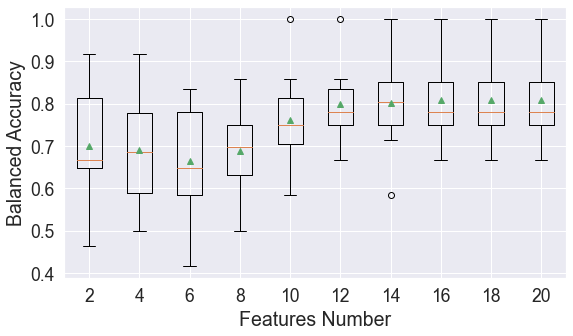

Cluster 2
>2 0.6833 (0.1167)
>4 0.6417 (0.1974)
>6 0.6750 (0.1843)
>8 0.7083 (0.1250)
>10 0.7250 (0.1828)
>12 0.7250 (0.1828)
>14 0.7750 (0.1828)
>16 0.7917 (0.1945)
>18 0.7917 (0.1945)
>20 0.8083 (0.1583)

Number of features : 20
Score : 0.8083333333333332

Index(['Age', 'HeartRate', 'TAD', 'Lactate', 'PaCO2', 'metHb', 'BE', 'AST/TGO',
       'DHL', 'AlkalinePhosph', 'GGT', 'Lymphocytes', 'Platelets', 'Urea',
       'Glasgow', 'Pneumothorax', 'MultiorganD', 'PolyneuroMyopathy', 'Shock',
       'NIVUD'],
      dtype='object')


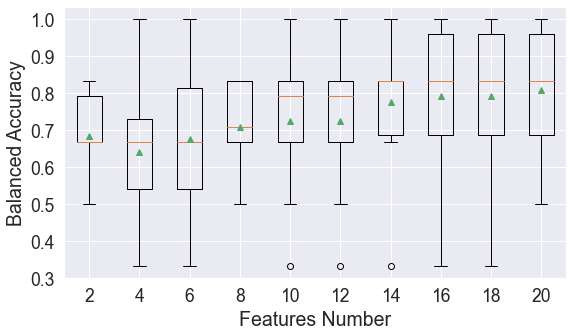

Cluster 3
>2 0.6026 (0.0573)
>4 0.6056 (0.0539)
>6 0.6193 (0.0355)
>8 0.6276 (0.0486)
>10 0.6303 (0.0562)
>12 0.6275 (0.0564)
>14 0.6330 (0.0559)
>16 0.6414 (0.0713)
>18 0.6360 (0.0753)
>20 0.6386 (0.0708)

Number of features : 16
Score : 0.6413656690746474

Index(['Age', 'HeartRate', 'TAD', 'Lactate', 'PaCO2', 'metHb', 'BE', 'AST/TGO',
       'DHL', 'AlkalinePhosph', 'Lymphocytes', 'Platelets', 'Glasgow',
       'MultiorganD', 'PolyneuroMyopathy', 'NIVUD'],
      dtype='object')


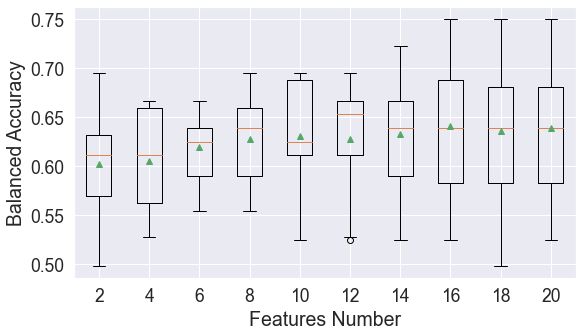

Cluster 4
>2 0.7008 (0.0610)
>4 0.7073 (0.0717)
>6 0.7619 (0.0863)
>8 0.7399 (0.0854)
>10 0.7381 (0.1012)
>12 0.7304 (0.0955)
>14 0.7195 (0.0813)
>16 0.7353 (0.0818)
>18 0.7322 (0.0805)
>20 0.7322 (0.0805)

Number of features : 6
Score : 0.7618783602150537

Index(['Age', 'PaCO2', 'metHb', 'BE', 'DHL', 'NIVUD'], dtype='object')


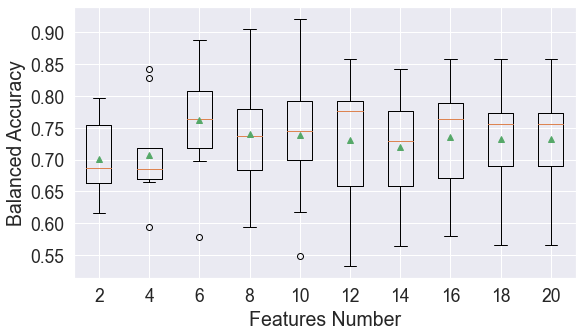

Cluster 5
>2 0.6266 (0.0383)
>4 0.6563 (0.0438)
>6 0.6580 (0.0382)
>8 0.6695 (0.0317)
>10 0.6829 (0.0245)
>12 0.7216 (0.0235)
>14 0.7261 (0.0285)
>16 0.7255 (0.0292)
>18 0.7255 (0.0303)
>20 0.7255 (0.0303)

Number of features : 14
Score : 0.726098088124363

Index(['Age', 'TAD', 'Lactate', 'PaCO2', 'metHb', 'BE', 'AST/TGO', 'DHL',
       'AlkalinePhosph', 'GGT', 'Lymphocytes', 'Platelets', 'Glasgow',
       'NIVUD'],
      dtype='object')


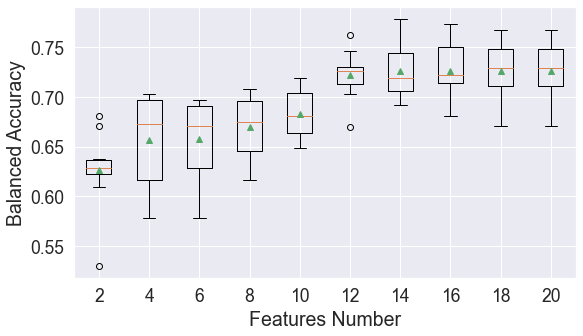

In [39]:
sns.set(rc={"figure.figsize":(9, 5)})

RFE_columns_List = []

for n, X, y in Clusters_Data:

   # Just to clusters with models
   if No_Model_List[n-1] == 0:
      print('Cluster', n)

      # get a list of models to evaluate
      models = dict()
      for i in [2,4,6,8,10,12,14,16,18,20]:
         # A machine learning model to selecting the features by eliminating the least important feature after recursively training
         rfe = RFE(estimator=LogisticRegression(max_iter=300), n_features_to_select=i)
         model = LogisticRegression(random_state = 0)
         models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])

      # evaluate the models and store results
      results, names = list(), list()
      results_mean = list()
      for name, model in models.items():
         # scoring='balanced_accuracy' because the data is unbalenced
         scores = cross_val_score(model, X, y, scoring='balanced_accuracy', cv=10, n_jobs=-1, error_score='raise')
         results.append(scores)
         results_mean.append(scores.mean())
         names.append(name)
         print('>%s %.4f (%.4f)' % (name, scores.mean(), scores.std()))

      
      # Chose the best number of features as dicovered from before
      # Here we will chose the best from a pull of the best 20 features

      best_score = max(results_mean)
      best_name = names[results_mean.index(max(results_mean))]

      print()
      print('Number of features :', best_name)
      print('Score :', best_score)
      print()

      # Change data to just the best features and show wish are the best features

      rfe_selector = RFE(estimator=LogisticRegression(max_iter=300),n_features_to_select = int(best_name), step = 1)
      rfe_selector.fit(X, y)
      RFE_columns = X.columns[rfe_selector.get_support()]
      print(RFE_columns)

      # Store Columns to use for each cluster
      RFE_columns_List.append(RFE_columns)
      

      # plot model performance for comparison
      pyplot.boxplot(results, labels=names, showmeans=True)

      pyplot.ylabel('Balanced Accuracy', fontsize=19.5)
      pyplot.xlabel('Features Number', fontsize=19.5)
      pyplot.yticks(fontsize = 17.5)
      pyplot.xticks(fontsize = 17.5)

      #pyplot.savefig('RFE')
      pyplot.show()
   else:
      print('Cluster', n)
      print('No RFE')
      print()
      RFE_columns_List.append(X.columns)

### Penalty and Cross Validation - ADASYN

In [40]:
classifier_list = ['standard', 'none', 0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

# This function returns the mean accuracys of clusters in the order of classifier_list, 
# and all the accuracies results in a dataframe
def Penalty(X_train, y_train):
    mean_accuracy_list = []

    accuracies_df = pd.DataFrame()
    n=0

    for parameter in classifier_list:

        #print(parameter, ':')

        if parameter == 'standard':
            classifier = LogisticRegression(max_iter=2000, random_state=0, solver='lbfgs', penalty='l2')
        elif parameter == 'none':
            classifier = LogisticRegression(max_iter=2000, random_state=0, penalty ='none', solver='saga')
        else:
            classifier = LogisticRegression(max_iter=2000, random_state=0, penalty ='elasticnet', solver='saga', l1_ratio=parameter)
    
        # scoring='balanced_accuracy' because the data is unbalenced
        all_accuracies_LR = cross_val_score(estimator=classifier, X=X_train, y=y_train, cv=10, scoring='balanced_accuracy')

        #print('cross_val_score: ', all_accuracies_LR)
        mean_accuracy_list.append(all_accuracies_LR.mean())
        #print('Mean: ', all_accuracies_LR.mean())
        #print('Standard deviation: ', all_accuracies_LR.std())
        #print()

        accuracies_df[parameter] = all_accuracies_LR

    return (mean_accuracy_list, accuracies_df)


In [41]:
# get best parameter for each cluster

l1_ratios = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
Best_parameter = []

for n, X, y in Clusters_Data:
    if No_Model_List[n-1] == 0:

        X = X[RFE_columns_List[n-1]]
    
        accuracies, accuracies_df = Penalty(X, y)

        # get best l1 ratio
        best_id = accuracies[2:].index(max(accuracies[2:]))
        best_l1_ratio = l1_ratios[best_id]

        # compare standard and none to best l1 ratio
        accuracies_df_2 = pd.DataFrame({'standard':accuracies_df['standard'], 'saga none':accuracies_df['none'], best_l1_ratio:accuracies_df[best_l1_ratio]})
        f_oneway_result = f_oneway(accuracies_df_2['standard'], accuracies_df_2['saga none'], accuracies_df_2[best_l1_ratio])

        if f_oneway_result.pvalue > 0.05:
            Best_parameter.append('standard')
        else:
            Best_parameter.append(best_l1_ratio)
    else:
        Best_parameter.append(None)
    
print(Best_parameter)

C:\Users\nunop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\nunop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\nunop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\nunop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\linear_model\_sag.py:354

['standard', 'standard', 'standard', 'standard', 'standard']


### Logistic Regression Model, Cost and parameters - ADASYN

In [42]:
# Get best model function with the best parameter

def Best_Model(X_train, y_train):

    parameter = Best_parameter[n-1]

    if parameter != None:
    
        if f_oneway_result.pvalue > 0.05:
            print('standard')
            LR_classifier = LogisticRegression(max_iter=2000, random_state=0, solver='lbfgs', penalty="l2")
        else:
            print('l1 ratio')
            LR_classifier = LogisticRegression(max_iter=2000, random_state=0, penalty ='elasticnet', solver='saga', l1_ratio=parameter)
    
        LR_classifier.fit(X_train, y_train)
    
    else:
        print('dummy')
        LR_classifier = DummyClassifier(strategy="most_frequent")

        LR_classifier.fit(X_train, y_train)

    return (LR_classifier)

In [43]:
Model_List = []

for n, X, y in Clusters_Data:

    X = X[RFE_columns_List[n-1]]
        
    Model_List.append(Best_Model(X, y))


standard
standard
standard
standard
standard


In [44]:
# Final cross validation with balanced accuracy
Mean_accuracies = []
Mean_accuracies_std = []

Mean_balanced_accuracies = []
Mean_balanced_accuracies_std = []

Mean_precisions = []
Mean_precisions_std = []

Mean_recalls = []
Mean_recalls_std = []

Mean_f1 = []
Mean_f1_std = []

# lenght of each cluster
Size_list = []

for n, X, y in Clusters_Data:

    X = X[RFE_columns_List[n-1]]

    classifier = Model_List[n-1]

    cv = StratifiedKFold(10)

    print('Cluster', n)

    all_accuracies_RF = cross_val_score(estimator=classifier, X=X, y=y, cv=cv, scoring='accuracy')
    all_balanced_accuracies_RF = cross_val_score(estimator=classifier, X=X, y=y, cv=cv, scoring='balanced_accuracy')
    all_precisions_RF = cross_val_score(estimator=classifier, X=X, y=y, cv=cv, scoring='precision')
    all_recalls_RF = cross_val_score(estimator=classifier, X=X, y=y, cv=cv, scoring='recall')
    all_f1_RF = cross_val_score(estimator=classifier, X=X, y=y, cv=cv, scoring='f1')

    print('     Accuracy')
    print('%6.2f' % all_accuracies_RF.mean(), 'std','%3.2f' % all_accuracies_RF.std())
    print()
    print('Balanced Accuracy')
    print('%6.2f' % all_balanced_accuracies_RF.mean(), 'std','%3.2f' % all_balanced_accuracies_RF.std())
    print()
    print('    Precision')
    print('%6.2f' % all_precisions_RF.mean(), 'std','%3.2f' % all_precisions_RF.std())
    print()
    print('     Recall')
    print('%6.2f' % all_recalls_RF.mean(), 'std','%3.2f' % all_recalls_RF.std())
    print()
    print('    F1-score')
    print('%6.2f' % all_f1_RF.mean(), 'std','%3.2f' % all_f1_RF.std())
    print()

    Size_list.append(len(X))
    
    Mean_accuracies.append(all_accuracies_RF.mean())
    Mean_accuracies_std.append(all_accuracies_RF.std())

    Mean_balanced_accuracies.append(all_balanced_accuracies_RF.mean())
    Mean_balanced_accuracies_std.append(all_balanced_accuracies_RF.std())

    Mean_precisions.append(all_precisions_RF.mean())
    Mean_precisions_std.append(all_precisions_RF.std())

    Mean_recalls.append(all_recalls_RF.mean())
    Mean_recalls_std.append(all_recalls_RF.std())

    Mean_f1.append(all_f1_RF.mean())
    Mean_f1_std.append(all_f1_RF.std())
    print()

Cluster 1


     Accuracy
  0.81 std 0.09

Balanced Accuracy
  0.81 std 0.09

    Precision
  0.78 std 0.13

     Recall
  0.92 std 0.13

    F1-score
  0.83 std 0.08


Cluster 2
     Accuracy
  0.81 std 0.16

Balanced Accuracy
  0.81 std 0.16

    Precision
  0.78 std 0.17

     Recall
  0.90 std 0.21

    F1-score
  0.82 std 0.18


Cluster 3
     Accuracy
  0.65 std 0.06

Balanced Accuracy
  0.65 std 0.06

    Precision
  0.66 std 0.09

     Recall
  0.62 std 0.08

    F1-score
  0.64 std 0.07


Cluster 4
     Accuracy
  0.77 std 0.09

Balanced Accuracy
  0.76 std 0.09

    Precision
  0.76 std 0.08

     Recall
  0.76 std 0.12

    F1-score
  0.76 std 0.09


Cluster 5
     Accuracy
  0.73 std 0.03

Balanced Accuracy
  0.73 std 0.03

    Precision
  0.73 std 0.03

     Recall
  0.74 std 0.09

    F1-score
  0.73 std 0.04




In [45]:
print(' All clusters ')
print()

Cross_Val_Performance_Lists=[['Accuracy',Mean_accuracies, Mean_accuracies_std], ['Balanced Accuracy',Mean_balanced_accuracies,Mean_balanced_accuracies_std], ['Precision',Mean_precisions,Mean_precisions_std], ['Recall',Mean_recalls,Mean_recalls_std], ['F1-score',Mean_f1,Mean_f1_std]]

# Weighted Average of Cross validations

for PM_name, PM_value, PM_std in Cross_Val_Performance_Lists:
    # Accuracy
    Sum_Size = sum(Size_list)
    w_acc_list = []
    w_std_list = []

    for size, acc, std in list(zip(Size_list, PM_value, PM_std)):

        w_acc = acc*(size/Sum_Size)
        w_acc_list.append(w_acc)
        w_std = std*(size/Sum_Size)
        w_std_list.append(w_std)
    
    print( PM_name, ': %5.2f' % sum(w_acc_list), ' std %5.2f' % sum(w_std_list))


 All clusters 

Accuracy :  0.73  std  0.05
Balanced Accuracy :  0.73  std  0.05
Precision :  0.73  std  0.05
Recall :  0.74  std  0.10
F1-score :  0.73  std  0.06


### Performance on Test 1 ( via 0/1 menbership) - ADASYN

In [49]:
# Separate test data to clusters

test_dataframes_list = []
test_classes_list =  []
# for plot of y pred vs distance
distance_for_plot = []

for n, X, y in Clusters_Data:

    X = X[RFE_columns_List[n-1]]

    One_cluster_test_df = pd.DataFrame(columns=list(X_test.columns))
    One_cluster_test_class = []
    One_distance_for_plot = []

    for index, row in X_test.iterrows():

        if menbership_all[index] == n:
            One_cluster_test_df = One_cluster_test_df.append(row, ignore_index=True)
            One_cluster_test_class.append(y_test[index])
            One_distance_for_plot.append(distances_all[index])

    # X_test Data separeted by cluster
    test_dataframes_list.append(One_cluster_test_df)
    # y_test Data separeted by cluster
    test_classes_list.append(One_cluster_test_class)
    # distances separeted by cluster
    distance_for_plot.append(One_distance_for_plot)

In [50]:
# Size of test menbership for each cluster
for n, X, y in Clusters_Data:
    print('Cluster', n, ':', len(test_dataframes_list[n-1]))

Cluster 1 : 33
Cluster 2 : 16
Cluster 3 : 155
Cluster 4 : 184
Cluster 5 : 513


In [51]:
# First I need a copy with all the features for the comparison at the end
test_dataframes_list_all_features = test_dataframes_list.copy()

# Change number of features according to the RFE of clusters

for n, X, y in Clusters_Data:

    X = X[RFE_columns_List[n-1]]
    
    test_dataframes_list[n-1] = test_dataframes_list[n-1][X.columns]

In [52]:
# To calculate AIC (Akaike information criterion) and BIC
# This is true for linear models

# calculate aic for regression
def calculate_aic(n, mse, num_params):
    aic = n * math.log(mse) + 2 * num_params
    return aic

# calculate bic for regression
def calculate_bic(n, mse, num_params):
    bic = n * math.log(mse) + num_params * math.log(n)
    return bic

In [53]:
def Performance_1(classifier, X_test_cluster, y_test_cluster, cluster_n, Performance_Metrics_d, Opt_Threshold_List, PlotSave):

    # Here we have to use LR_classifier.predict_proba(X_test)[:,1] and not y_pred
    fpr, tpr, thresholds = metrics.roc_curve(y_test_cluster, classifier.predict_proba(X_test_cluster)[:,1], pos_label=1)
    auc_roc = metrics.auc(fpr, tpr)
    #print(auc_roc)

    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    Opt_Threshold_List.append(optimal_threshold)
    #print('optimal idx :', optimal_idx)
    #print('optimal threshold :', optimal_threshold)
    #print('tpr optimal idx:', tpr[optimal_idx])
    #print('fpr optimal idx:', fpr[optimal_idx])

    #Define optimal threshold
    y_pred = (classifier.predict_proba(X_test_cluster)[:,1] >= optimal_threshold).astype(bool)

    print()
    print( ' ###################### Cluster', cluster_n, '######################')
    print()
    #print(confusion_matrix(y_test_cluster,y_pred))
    #print(classification_report(y_test_cluster,y_pred))
    #print('accuracy_score: ', accuracy_score(y_test_cluster, y_pred))
    #print('balanced_accuracy_score: ', balanced_accuracy_score(y_test_cluster, y_pred))
    #print()

    if No_Model_List[cluster_n-1] == 0:
        # number of parameters
        num_params = len(classifier.coef_) + 1
        #print('Number of parameters: %d' % (num_params))
        # calculate the error
        mse = mean_squared_error(y_test_cluster, y_pred)
        #print('MSE: %.3f' % mse)
        # just to avoid errors
        if mse == 0:
            mse = 0.00000000000000001
        # calculate the aic
        aic = calculate_aic(len(y_test_cluster), mse, num_params)
        #print('AIC: %.3f' % aic)
        # calculate the bic
        bic = calculate_bic(len(y_test_cluster), mse, num_params)
        #print('BIC: %.3f' % bic)
        #print()
        #print()
    else:
        aic = 0
        bic = 0

    print('Accuracy     Balanced Accuracy     Precision     Recall     F1-score')
    print('%6.2f' % accuracy_score(y_test_cluster,y_pred), '%16.2f' % balanced_accuracy_score(y_test_cluster,y_pred), '%17.2f' % precision_score(y_test_cluster,y_pred), '%12.2f' % recall_score(y_test_cluster,y_pred), '%11.2f' % f1_score(y_test_cluster,y_pred))
    print()
    print(' AUROC     Opt Threshold       AIC         BIC')
    print( '%5.2f' % auc_roc, '%14.2f' % optimal_threshold, '%15.2f' % aic, '%11.2f' % bic)
    print()

    # Save accuracy metrics
    Performance_Metrics_d['Accuracy'].append(accuracy_score(y_test_cluster,y_pred))
    Performance_Metrics_d['Balanced Accuracy'].append(balanced_accuracy_score(y_test_cluster,y_pred))
    Performance_Metrics_d['Precision'].append(precision_score(y_test_cluster,y_pred))
    Performance_Metrics_d['Recall'].append(recall_score(y_test_cluster,y_pred))
    Performance_Metrics_d['F1-score'].append(f1_score(y_test_cluster,y_pred))
    
    # Save plots
    if PlotSave == 'yes':

        # ROC curve
        sns.set(rc={"figure.figsize":(5, 5)})

        plt.plot(fpr, tpr, color='darkorange',
         label='ROC Curve (area = %0.2f)' % auc_roc)
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.scatter([fpr[optimal_idx]], [tpr[optimal_idx]], color="black", zorder=5,
         label='Optimal Point (%0.2f, %0.2f)' % (fpr[optimal_idx], tpr[optimal_idx]))

        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])

        plt.xlabel('False Positive Rate', fontsize=13.5)
        plt.ylabel('True Positive Rate', fontsize=13.5)
        plt.legend(loc="lower right", fontsize=14)

        plt.tight_layout()
        plt.savefig('Clustering Plots/ADASYN Cluster {} ROC Curve'.format(cluster_n))
        plt.show()

        # Confusion Matrix
        sns.set(rc={"figure.figsize":(4, 4)})

        c_matrix = confusion_matrix(y_test_cluster, y_pred)
        plot_confusion_matrix(c_matrix)

        plt.xlabel('True Label', fontsize=13.5)
        plt.ylabel('Predicted Label', fontsize=13.5)

        plt.savefig('Clustering Plots/ADASYN Cluster {} Confusion Matrix'.format(cluster_n))
        plt.show()

        # Scatter plot of prediction vs distance
        palette = {'Wrong':'tab:blue', 'Right':'tab:orange'}
        distance_y = distance_for_plot[cluster_n-1]
        distance_cluster = [sublist[cluster_n-1] for sublist in distance_y]
        
        RW_list = []
        for true_label, predicted_label in list(zip(y_test_cluster,y_pred)):
            if true_label != predicted_label:
                RW_list.append('Wrong')
            else:
                RW_list.append('Right')

        Df_scatter_plot = pd.DataFrame({'Right or Wrong Prediction':RW_list, 'Prediction':y_pred, 'Distance':distance_cluster})

        Df_scatter_plot['Prediction'] = Df_scatter_plot['Prediction'].map({True: 'True', False: 'False'})  # Replace boolean with string

        sns.boxplot(data=Df_scatter_plot, x="Distance", y="Prediction", hue="Right or Wrong Prediction", palette=palette)

        plt.savefig('Clustering Plots/ADASYN Cluster {} BoxPlot'.format(cluster_n))
        plt.show()



 ###################### Cluster 1 ######################

Accuracy     Balanced Accuracy     Precision     Recall     F1-score
  0.73             0.52              0.14         0.25        0.18

 AUROC     Opt Threshold       AIC         BIC
 0.32           0.50          -38.88      -35.88



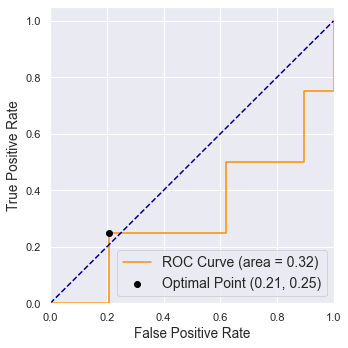

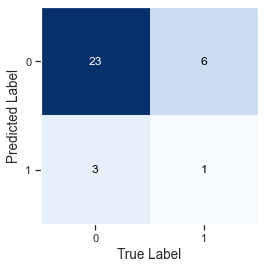

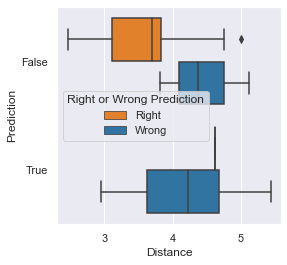


 ###################### Cluster 2 ######################

Accuracy     Balanced Accuracy     Precision     Recall     F1-score
  0.88             0.85              0.80         0.80        0.80

 AUROC     Opt Threshold       AIC         BIC
 0.89           0.79          -29.27      -27.73



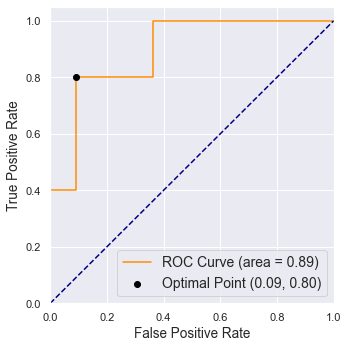

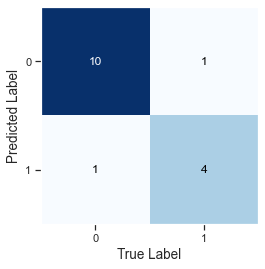

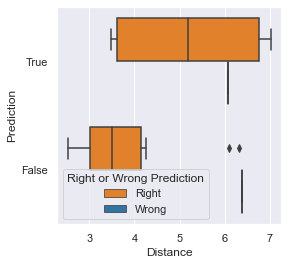


 ###################### Cluster 3 ######################

Accuracy     Balanced Accuracy     Precision     Recall     F1-score
  0.66             0.68              0.46         0.70        0.56

 AUROC     Opt Threshold       AIC         BIC
 0.72           0.46         -165.29     -159.20



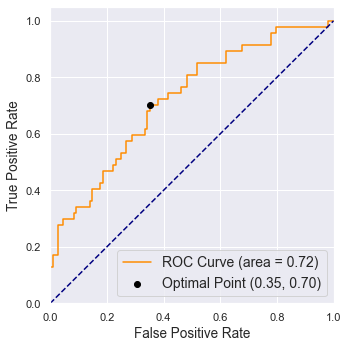

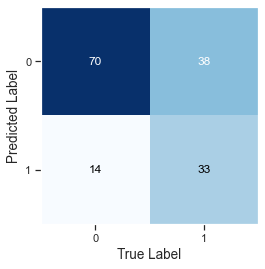

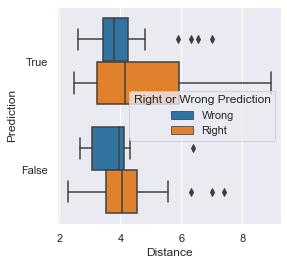


 ###################### Cluster 4 ######################

Accuracy     Balanced Accuracy     Precision     Recall     F1-score
  0.60             0.69              0.25         0.82        0.38

 AUROC     Opt Threshold       AIC         BIC
 0.74           0.38         -163.60     -157.17



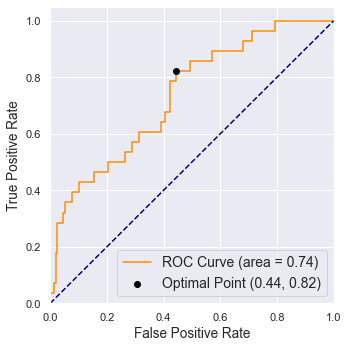

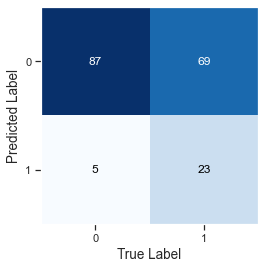

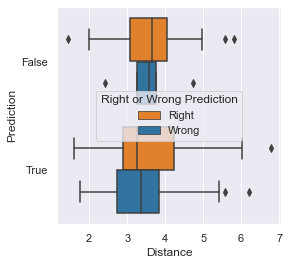


 ###################### Cluster 5 ######################

Accuracy     Balanced Accuracy     Precision     Recall     F1-score
  0.74             0.72              0.31         0.69        0.43

 AUROC     Opt Threshold       AIC         BIC
 0.78           0.53         -688.51     -680.03



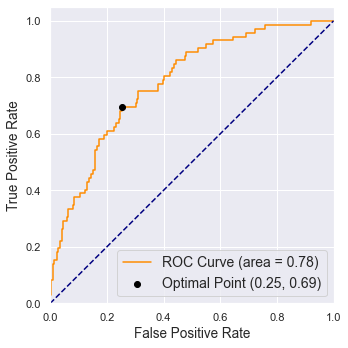

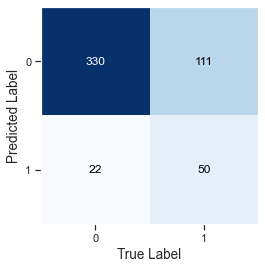

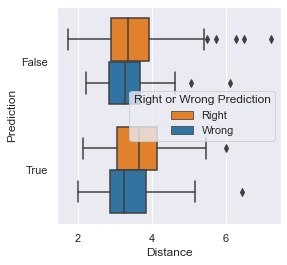

In [54]:
Performance_Metrics_d = {'Accuracy':[], 'Balanced Accuracy':[], 'Precision':[], 'Recall':[], 'F1-score':[]}
test_size = 0
Opt_Threshold_List = []

for n, X, y in Clusters_Data:

    X = X[RFE_columns_List[n-1]]
    
    LR_classifier = Model_List[n-1]
    X_test_cluster = test_dataframes_list[n-1]
    y_test_cluster = test_classes_list[n-1]

    #This is going to be usefull to calculate the performance of all clusters
    test_size = test_size + len(y_test_cluster)

    # last entry 'no' for no plot save, 'yes' for plot save (ROC curve and Confusion Matrix)
    Performance_1(LR_classifier, X_test_cluster, y_test_cluster, n, Performance_Metrics_d, Opt_Threshold_List, 'yes')


In [55]:
for n, X, y in Clusters_Data:

    X_test_cluster = test_dataframes_list[n-1]
    size_w = len(X_test_cluster)/test_size

    Performance_Metrics_d['Accuracy'][n-1] = Performance_Metrics_d['Accuracy'][n-1]*size_w
    Performance_Metrics_d['Balanced Accuracy'][n-1] = Performance_Metrics_d['Balanced Accuracy'][n-1]*size_w
    Performance_Metrics_d['Precision'][n-1] = Performance_Metrics_d['Precision'][n-1]*size_w
    Performance_Metrics_d['Recall'][n-1] = Performance_Metrics_d['Recall'][n-1]*size_w
    Performance_Metrics_d['F1-score'][n-1] = Performance_Metrics_d['F1-score'][n-1]*size_w

print(' ######################  Test Performance Combined  ###################### ')
print()
print('Accuracy     Balanced Accuracy     Precision     Recall     F1-score')
print('%6.2f' % sum(Performance_Metrics_d['Accuracy']), '%16.2f' % sum(Performance_Metrics_d['Balanced Accuracy']), '%17.2f' % sum(Performance_Metrics_d['Precision']), '%12.2f' % sum(Performance_Metrics_d['Recall']), '%11.2f' % sum(Performance_Metrics_d['F1-score']))

 ######################  Test Performance Combined  ###################### 

Accuracy     Balanced Accuracy     Precision     Recall     F1-score
  0.70             0.70              0.33         0.71        0.44


### Performance on Test 2 (via weights) - ADASYN

In [56]:
# Get probabilities using all test Data for each cluster
Probabilities_all =  []

for n, X, y in Clusters_Data:

    X = X[RFE_columns_List[n-1]]

    LR_classifier = Model_List[n-1]

    # Turn the test features the same after RFE
    X_test_less_features = X_test[X.columns]

    Probabilities = LR_classifier.predict_proba(X_test_less_features)[:,1]

    Probabilities_all.append(Probabilities)

In [57]:
# Get probabiliteis tanking into account the weights of each model
Final_probs_list = []

for index, row in X_test.iterrows():

    # List with all probabilities*weight of a observation
    One_observation_probs = []

    for n, X, y in Clusters_Data:

        prob_obs_one = Probabilities_all[n-1][index]
        weight_obs_one = weights_all[index][n-1]

        prob_weight = prob_obs_one * weight_obs_one

        One_observation_probs.append(prob_weight)

    # Sum the probabilities*weight
    final_prob = sum(One_observation_probs)

    Final_probs_list.append(final_prob)


Accuracy     Balanced Accuracy     Precision     Recall     F1-score
  0.68             0.70              0.32         0.73        0.44

 AUROC     Opt Threshold
 0.77           0.35



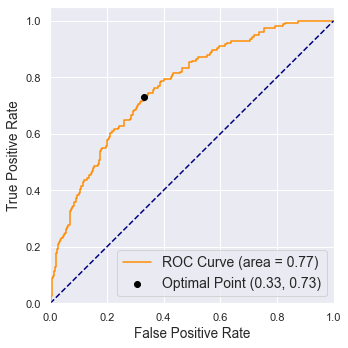

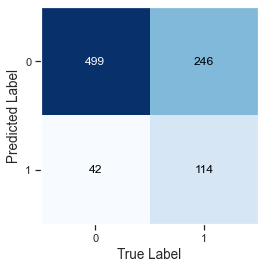

In [58]:
# Here we have to use LR_classifier.predict_proba(X_test)[:,1] and not y_pred
fpr, tpr, thresholds = metrics.roc_curve(y_test, Final_probs_list, pos_label=1)
auc_roc = metrics.auc(fpr, tpr)
#print(auc_roc)

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
#print('optimal idx :', optimal_idx)
#print('optimal threshold :', optimal_threshold)
#print('tpr optimal idx:', tpr[optimal_idx])
#print('fpr optimal idx:', fpr[optimal_idx])

#Define optimal threshold
y_pred = (Final_probs_list >= optimal_threshold).astype(bool)

#print(confusion_matrix(y_test_cluster,y_pred))
#print(classification_report(y_test,y_pred))
#print('accuracy_score: ', accuracy_score(y_test, y_pred))
#print('balanced_accuracy_score: ', balanced_accuracy_score(y_test, y_pred))
#print()

print('Accuracy     Balanced Accuracy     Precision     Recall     F1-score')
print('%6.2f' % accuracy_score(y_test,y_pred), '%16.2f' % balanced_accuracy_score(y_test,y_pred), '%17.2f' % precision_score(y_test,y_pred), '%12.2f' % recall_score(y_test,y_pred), '%11.2f' % f1_score(y_test,y_pred))
print()
print(' AUROC     Opt Threshold')
print( '%5.2f' % auc_roc, '%14.2f' % optimal_threshold)
print()

# ROC curve
sns.set(rc={"figure.figsize":(5, 5)})

plt.plot(fpr, tpr, color='darkorange',
 label='ROC Curve (area = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.scatter([fpr[optimal_idx]], [tpr[optimal_idx]], color="black", zorder=5,
 label='Optimal Point (%0.2f, %0.2f)' % (fpr[optimal_idx], tpr[optimal_idx]))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate', fontsize=13.5)
plt.ylabel('True Positive Rate', fontsize=13.5)
plt.legend(loc="lower right", fontsize=14)

plt.tight_layout()
plt.savefig('Clustering Plots/Weights ROC Curve')
plt.show()

# Confusion Matrix
sns.set(rc={"figure.figsize":(4, 4)})

c_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(c_matrix)

plt.xlabel('True Label', fontsize=13.5)
plt.ylabel('Predicted Label', fontsize=13.5)

plt.savefig('Clustering Plots/ADASYN Weights Confusion Matrix')
plt.show()

In [59]:
# Green Line: Menbership
# Red Line: Weights
Global_Probabilities_List = np.load('Models/Other Results/Probabilities LR Mortality 24-48h Adasyn.npy')
Global_Threshold = np.load('Models/Other Results/Treshold LR Mortality 24-48h Adasyn.npy')

Probabilities_Comparison_Df = pd.DataFrame({'Global Probabilities':Global_Probabilities_List, 'Weights Probabilities':Final_probs_list, 'True Probabilities':y_test})
print(len(Probabilities_Comparison_Df))

901


All 1.0 true label : 156
All true 1.0 correctly predicted in both models : 108
Global probability is bigger in : 0.9166666666666666
Weights probability is bigger in : 0.08333333333333333

All 0.0 true label : 745
All true 0.0 correctly predicted in both models : 446
Global probability is bigger in : 0.6748878923766816
Weights probability is bigger in : 0.3251121076233184

All 0.0 true label : 745
All false 1.0 wrongly predicted in both models : 187
Global probability is bigger in : 0.9518716577540107
Weights probability is bigger in : 0.0481283422459893

All 1.0 true label : 156
All false 0.0 wrongly predicted in both models : 32
Global probability is bigger in : 0.59375
Weights probability is bigger in : 0.40625



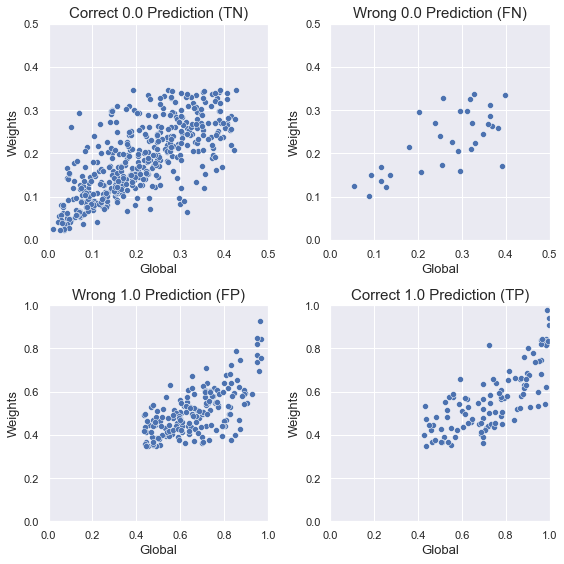

In [60]:
sns.set(rc={"figure.figsize":(8, 8)})
fig, ax = plt.subplots(2,2)

# For correct 1.0 prediction
# TP
Probabilities_Comparison_Df_1 = Probabilities_Comparison_Df.loc[Probabilities_Comparison_Df['True Probabilities']==1]
print('All 1.0 true label :', len(Probabilities_Comparison_Df_1))

Probabilities_Comparison_Df_1 = Probabilities_Comparison_Df_1.loc[Probabilities_Comparison_Df['Weights Probabilities']>=optimal_threshold]
Probabilities_Comparison_Df_1 = Probabilities_Comparison_Df_1.loc[Probabilities_Comparison_Df['Global Probabilities']>=Global_Threshold]
print('All true 1.0 correctly predicted in both models :', len(Probabilities_Comparison_Df_1))

P_Global_List = list(Probabilities_Comparison_Df_1['Global Probabilities'])
P_Weights_List = list(Probabilities_Comparison_Df_1['Weights Probabilities'])

P_Global_Bigger = 0
P_Weights_Bigger = 0
for P_Global, P_Weights in list(zip(P_Global_List, P_Weights_List)):
    if P_Global > P_Weights:
        P_Global_Bigger = P_Global_Bigger + 1
    elif P_Weights > P_Global:
        P_Weights_Bigger = P_Weights_Bigger + 1

print('Global probability is bigger in :', P_Global_Bigger/len(P_Global_List))
print('Weights probability is bigger in :', P_Weights_Bigger/len(P_Global_List))
print()


sns.scatterplot(x=P_Global_List, y=P_Weights_List, ax=ax[1, 1])
ax[1, 1].set_ylabel('Weights', fontsize=13)
ax[1, 1].set_xlabel('Global', fontsize=13)
ax[1, 1].set_title('Correct 1.0 Prediction (TP)', fontsize=15)
ax[1, 1].axis([0, 1, 0, 1])

# For correct 0.0 prediction
# TN
Probabilities_Comparison_Df_1 = Probabilities_Comparison_Df.loc[Probabilities_Comparison_Df['True Probabilities']==0]
print('All 0.0 true label :', len(Probabilities_Comparison_Df_1))

Probabilities_Comparison_Df_1 = Probabilities_Comparison_Df_1.loc[Probabilities_Comparison_Df['Weights Probabilities']<optimal_threshold]
Probabilities_Comparison_Df_1 = Probabilities_Comparison_Df_1.loc[Probabilities_Comparison_Df['Global Probabilities']<Global_Threshold]
print('All true 0.0 correctly predicted in both models :', len(Probabilities_Comparison_Df_1))

P_Global_List = list(Probabilities_Comparison_Df_1['Global Probabilities'])
P_Weights_List = list(Probabilities_Comparison_Df_1['Weights Probabilities'])

P_Global_Bigger = 0
P_Weights_Bigger = 0
for P_Global, P_Weights in list(zip(P_Global_List, P_Weights_List)):
    if P_Global > P_Weights:
        P_Global_Bigger = P_Global_Bigger + 1
    elif P_Weights > P_Global:
        P_Weights_Bigger = P_Weights_Bigger + 1

print('Global probability is bigger in :', P_Global_Bigger/len(P_Global_List))
print('Weights probability is bigger in :', P_Weights_Bigger/len(P_Global_List))
print()

sns.scatterplot(x=P_Global_List, y=P_Weights_List, ax=ax[0, 0])
ax[0, 0].set_ylabel('Weights', fontsize=13)
ax[0, 0].set_xlabel('Global', fontsize=13)
ax[0, 0].set_title('Correct 0.0 Prediction (TN)', fontsize=15)
ax[0, 0].axis([0, 0.5, 0, 0.5])

# For wrong 1.0 prediction
# FP
Probabilities_Comparison_Df_1 = Probabilities_Comparison_Df.loc[Probabilities_Comparison_Df['True Probabilities']==0]
print('All 0.0 true label :', len(Probabilities_Comparison_Df_1))

Probabilities_Comparison_Df_1 = Probabilities_Comparison_Df_1.loc[Probabilities_Comparison_Df['Weights Probabilities']>=optimal_threshold]
Probabilities_Comparison_Df_1 = Probabilities_Comparison_Df_1.loc[Probabilities_Comparison_Df['Global Probabilities']>=Global_Threshold]
print('All false 1.0 wrongly predicted in both models :', len(Probabilities_Comparison_Df_1))

P_Global_List = list(Probabilities_Comparison_Df_1['Global Probabilities'])
P_Weights_List = list(Probabilities_Comparison_Df_1['Weights Probabilities'])

P_Global_Bigger = 0
P_Weights_Bigger = 0
for P_Global, P_Weights in list(zip(P_Global_List, P_Weights_List)):
    if P_Global > P_Weights:
        P_Global_Bigger = P_Global_Bigger + 1
    elif P_Weights > P_Global:
        P_Weights_Bigger = P_Weights_Bigger + 1

print('Global probability is bigger in :', P_Global_Bigger/len(P_Global_List))
print('Weights probability is bigger in :', P_Weights_Bigger/len(P_Global_List))
print()

sns.scatterplot(x=P_Global_List, y=P_Weights_List, ax=ax[1, 0])
ax[1, 0].set_ylabel('Weights', fontsize=13)
ax[1, 0].set_xlabel('Global', fontsize=13)
ax[1, 0].set_title('Wrong 1.0 Prediction (FP)', fontsize=15)
ax[1, 0].axis([0, 1, 0, 1])


# For wrong 0.0 prediction
# FN
Probabilities_Comparison_Df_1 = Probabilities_Comparison_Df.loc[Probabilities_Comparison_Df['True Probabilities']==1]
print('All 1.0 true label :', len(Probabilities_Comparison_Df_1))

Probabilities_Comparison_Df_1 = Probabilities_Comparison_Df_1.loc[Probabilities_Comparison_Df['Weights Probabilities']<optimal_threshold]
Probabilities_Comparison_Df_1 = Probabilities_Comparison_Df_1.loc[Probabilities_Comparison_Df['Global Probabilities']<Global_Threshold]
print('All false 0.0 wrongly predicted in both models :', len(Probabilities_Comparison_Df_1))

P_Global_List = list(Probabilities_Comparison_Df_1['Global Probabilities'])
P_Weights_List = list(Probabilities_Comparison_Df_1['Weights Probabilities'])

P_Global_Bigger = 0
P_Weights_Bigger = 0
for P_Global, P_Weights in list(zip(P_Global_List, P_Weights_List)):
    if P_Global > P_Weights:
        P_Global_Bigger = P_Global_Bigger + 1
    elif P_Weights > P_Global:
        P_Weights_Bigger = P_Weights_Bigger + 1

print('Global probability is bigger in :', P_Global_Bigger/len(P_Global_List))
print('Weights probability is bigger in :', P_Weights_Bigger/len(P_Global_List))
print()

sns.scatterplot(x=P_Global_List, y=P_Weights_List, ax=ax[0, 1])
ax[0, 1].set_ylabel('Weights', fontsize=13)
ax[0, 1].set_xlabel('Global', fontsize=13)
ax[0, 1].set_title('Wrong 0.0 Prediction (FN)', fontsize=15)
ax[0, 1].axis([0, 0.5, 0, 0.5])

plt.tight_layout()
plt.savefig('Clustering Plots/ADASYN Scatter Plots Matrix')
plt.show()

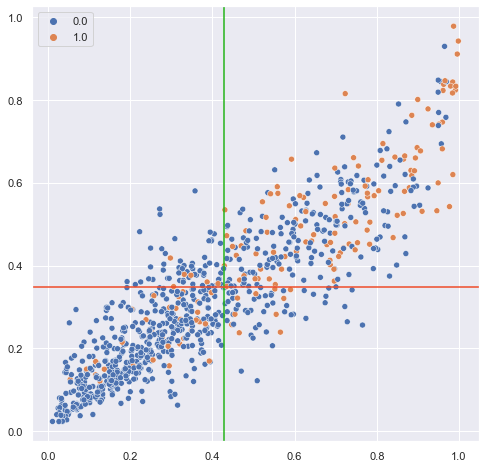

In [61]:
# Green Line: Menbership
# Red Line: Weights
# Compare probabilities between ways of predicting test data
sns.scatterplot(x=Global_Probabilities_List, y=Final_probs_list, hue=y_test)
plt.axvline(x=Global_Threshold, color = '#23B418') 
plt.axhline(y=optimal_threshold, color = '#EE4A27')
plt.savefig('Clustering Plots/ADASYN Geral Probabilities ScatterPlot')
plt.show() 

print()

### Compare Probabilites between both methods - ADASYN

In [62]:
# get probabilities of menbership models, separated by assigned cluster:
Menbership_Probabilities_List = []
# get true label
True_label_List = []

for n, X, y in Clusters_Data:
    
    LR_classifier = Model_List[n-1]
    X_test_cluster = test_dataframes_list[n-1]

    y_test_cluster = test_classes_list[n-1]
    True_label_List.append(y_test_cluster)

    Probabilities_pred = LR_classifier.predict_proba(X_test_cluster)[:,1]
    Menbership_Probabilities_List.append(Probabilities_pred)


# get probabilities of weights models, separated by assigned cluster in menbership:
Weights_Probabilities_List = []

# Let's iterate over every test data that is separated into clusters
# and then do the same as done in the weights analysis
for X_test_cluster in test_dataframes_list_all_features:

    # Get probabilities using all test Data for each cluster
    Probabilities_all_clustered =  []
    
    for n, X, y in Clusters_Data:

        LR_classifier = Model_List[n-1]

        #X_test_cluster = test_dataframes_list[n-1]

        Probabilities = LR_classifier.predict_proba(X_test_cluster[RFE_columns_List[n-1]])[:,1]

        Probabilities_all_clustered.append(Probabilities)

    # Get probabiliteis tanking into account the weights of each model
    Final_probs_list_clustered = []

    for index, row in X_test_cluster.iterrows():

        # List with all probabilities*weight of a observation
        One_observation_probs = []

        for n, X, y in Clusters_Data:

            prob_obs_one = Probabilities_all_clustered[n-1][index]
            weight_obs_one = weights_all[index][n-1]

            prob_weight = prob_obs_one * weight_obs_one

            One_observation_probs.append(prob_weight)

        # Sum the probabilities*weight
        final_prob = sum(One_observation_probs)

        Final_probs_list_clustered.append(final_prob)

    Weights_Probabilities_List.append(Final_probs_list_clustered)

 ###################### Cluster 1 ######################



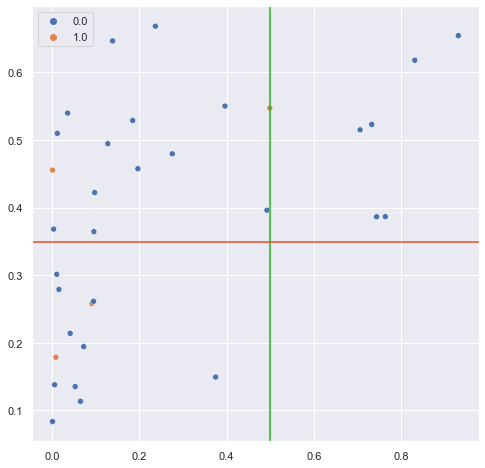


 ###################### Cluster 2 ######################



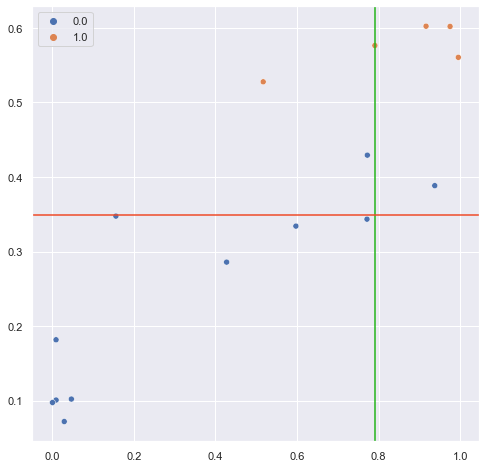


 ###################### Cluster 3 ######################



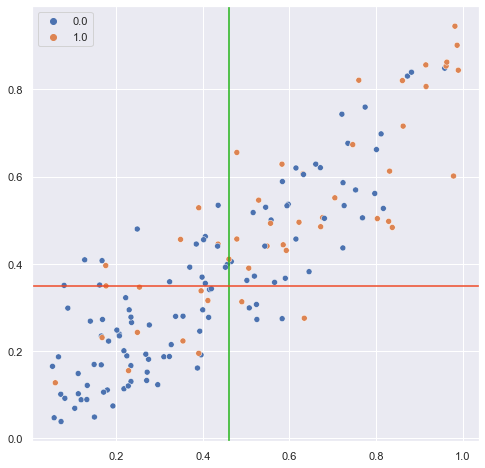


 ###################### Cluster 4 ######################



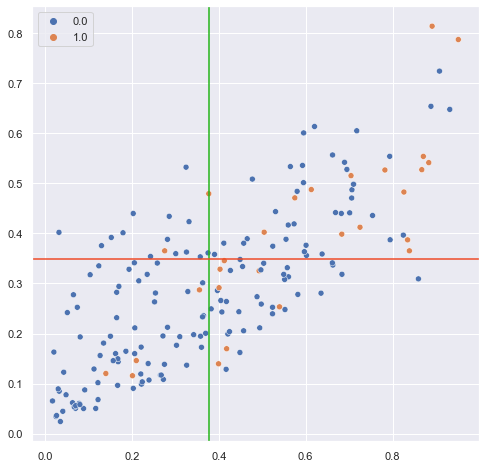


 ###################### Cluster 5 ######################



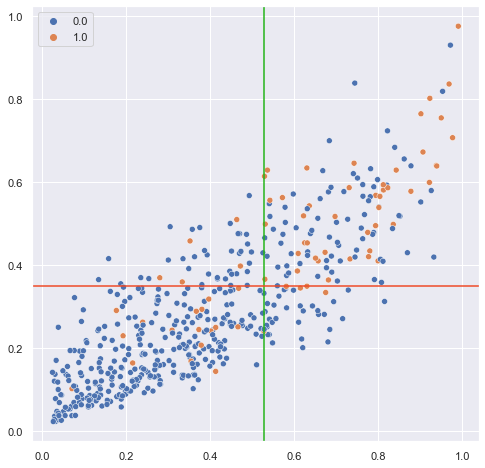

In [63]:
# Green Line: Menbership
# Red Line: Weights

# Compare probabilities between ways of predicting test data
for n, X, y in Clusters_Data:
    print(' ###################### Cluster', n, '######################')
    print()

    sns.scatterplot(x=Menbership_Probabilities_List[n-1], y=Weights_Probabilities_List[n-1], hue=True_label_List[n-1])
    plt.axvline(x=Opt_Threshold_List[n-1], color = '#23B418') 
    plt.axhline(y=optimal_threshold, color = '#EE4A27')
    plt.savefig('Clustering Plots/ADASYN Cluster {} Probabilities ScatterPlot'.format(n))
    plt.show() 

    print()

### Get Feature Importance - ADASYN

###################### Cluster 1 ######################
        Age  HeartRate       TAD   Lactate     PaCO2     metHb        BE  \
0  0.879554   1.093138 -1.487622 -0.423377  0.582878 -1.137077 -0.460601   

    AST/TGO       DHL  AlkalinePhosph       GGT  Lymphocytes  Platelets  \
0 -0.796548  0.044781        0.216417  0.813166    -0.493679  -0.583106   

       Urea    Shock     NIVUD  
0  0.296162 -0.18825 -0.957324  


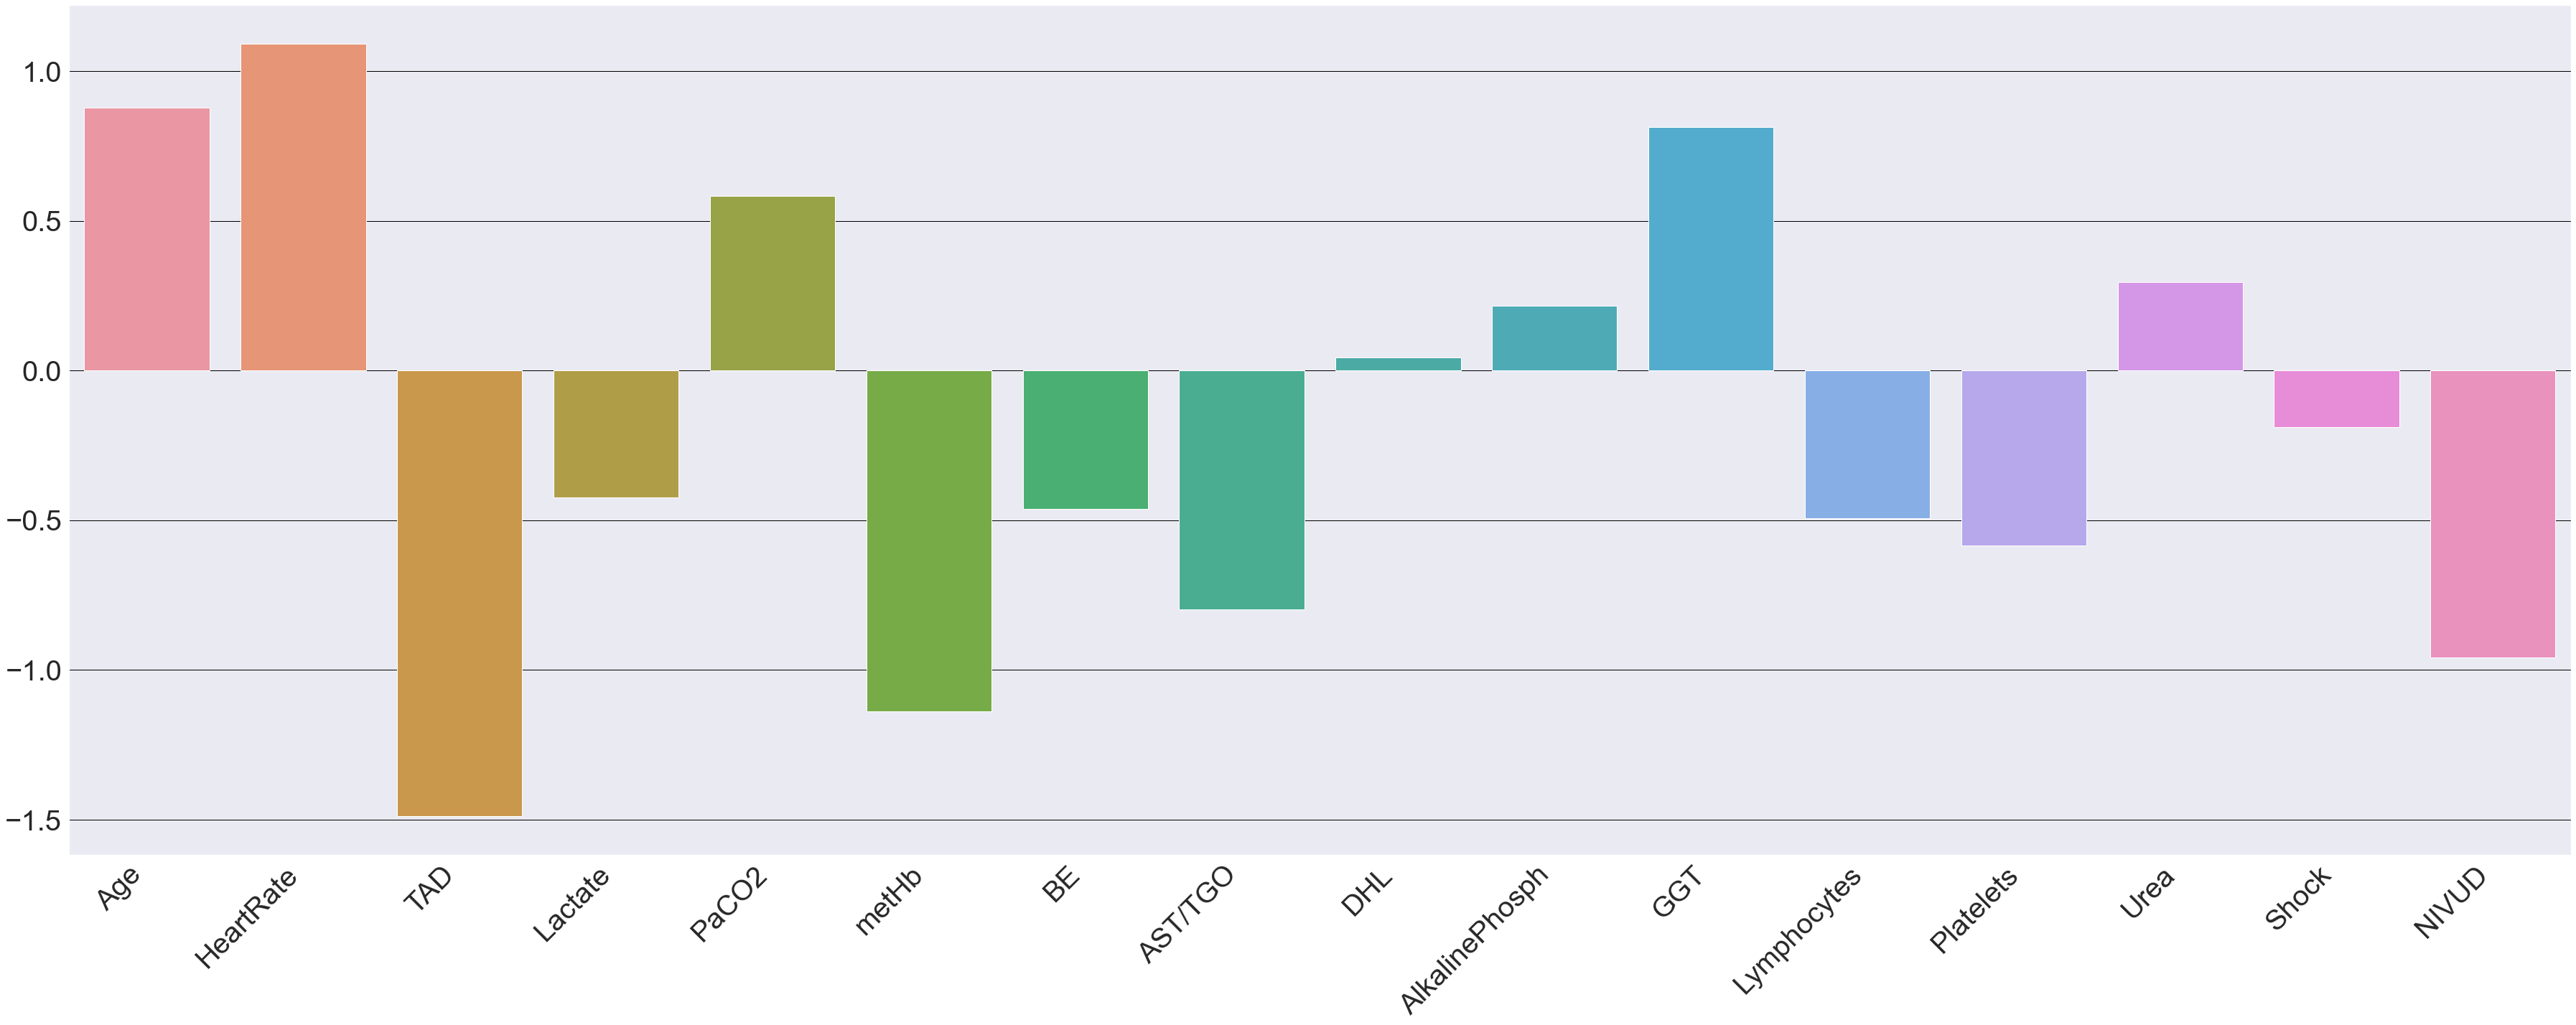


###################### Cluster 2 ######################
        Age  HeartRate       TAD   Lactate     PaCO2     metHb        BE  \
0  0.000067   0.744961 -1.670081  0.595482  0.840324 -0.737098 -1.022502   

    AST/TGO      DHL  AlkalinePhosph       GGT  Lymphocytes  Platelets  \
0  0.116653 -0.57112        0.594662  0.233382     0.243002  -0.901834   

       Urea   Glasgow  Pneumothorax  MultiorganD  PolyneuroMyopathy     Shock  \
0  1.262035 -0.286522     -0.000116     0.554228           0.428877 -0.453796   

      NIVUD  
0 -0.317106  


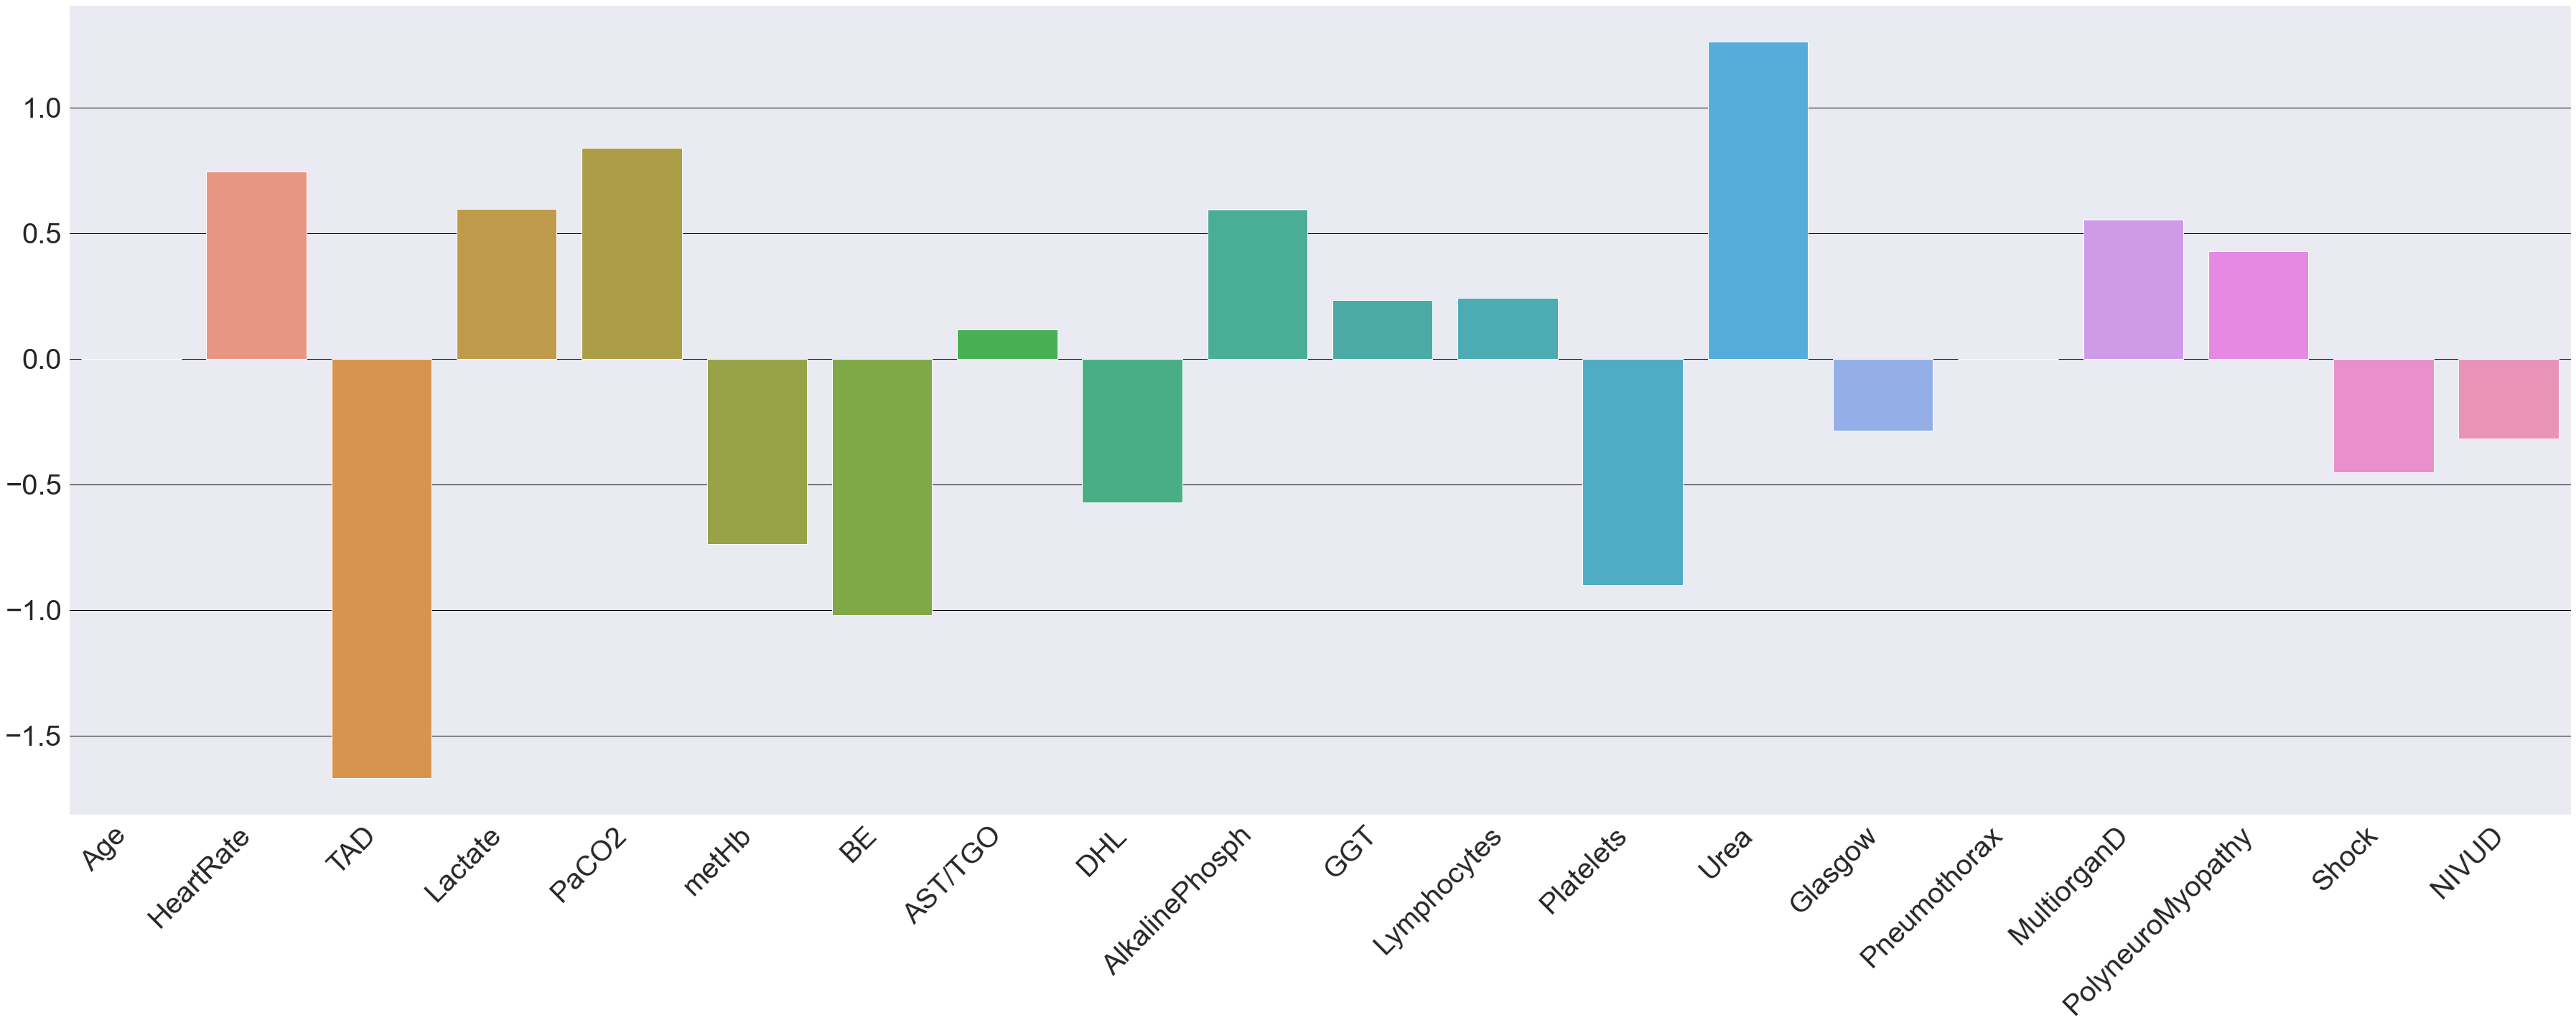


###################### Cluster 3 ######################
        Age  HeartRate       TAD   Lactate     PaCO2     metHb        BE  \
0 -0.312947   0.253466 -0.306641  0.370765  0.495373  0.174426 -0.283033   

    AST/TGO       DHL  AlkalinePhosph  Lymphocytes  Platelets  Glasgow  \
0 -0.390978  0.886985        0.060852     0.090079    -0.1315  0.23159   

   MultiorganD  PolyneuroMyopathy     NIVUD  
0      0.12055          -0.072247 -0.233143  


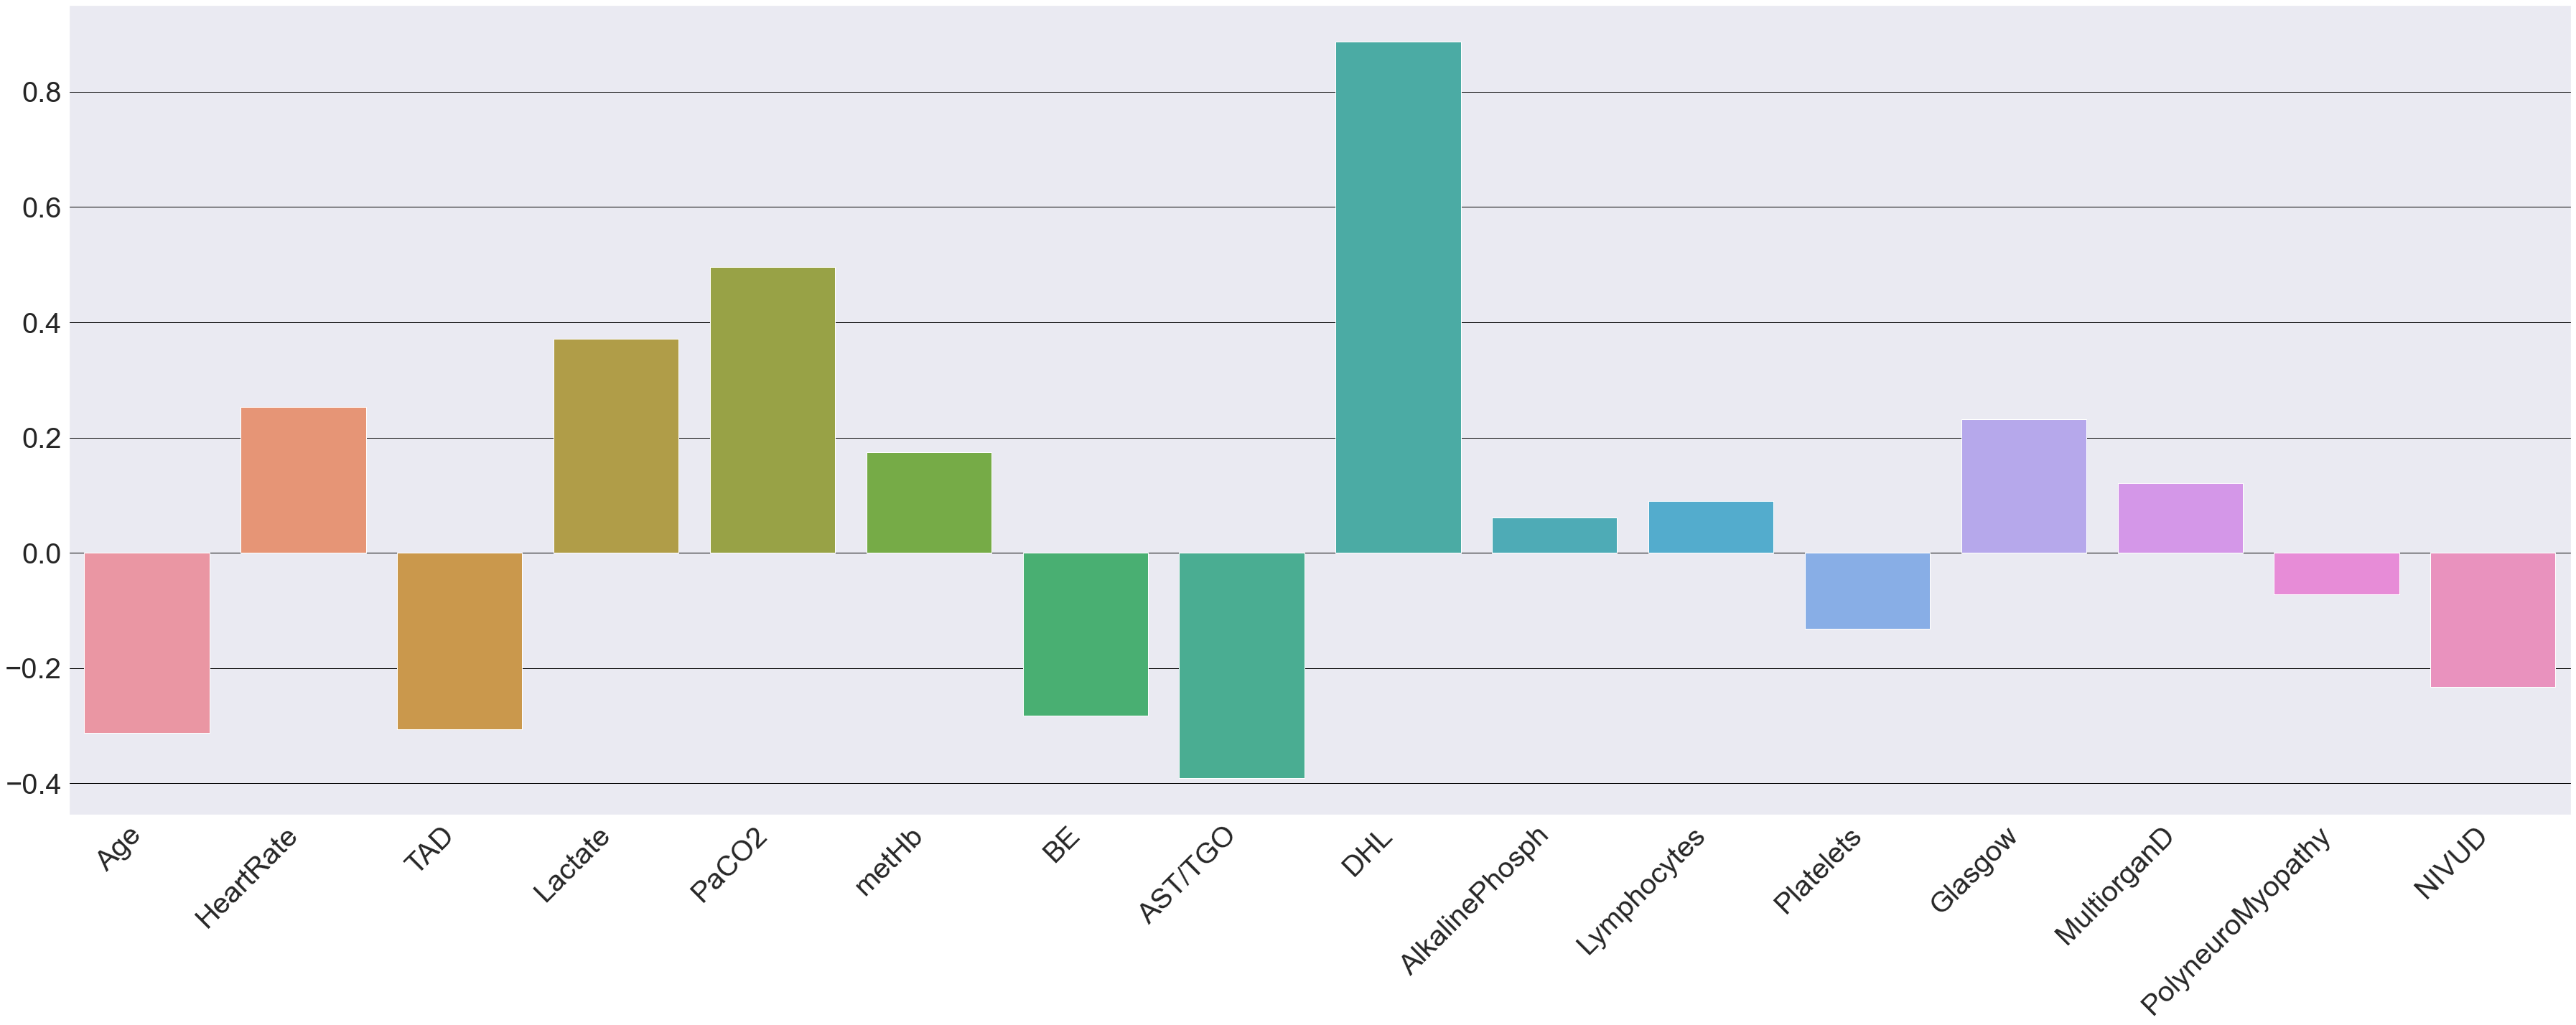


###################### Cluster 4 ######################
        Age     PaCO2     metHb        BE     DHL     NIVUD
0 -0.805002  0.792273  0.731552 -0.794907  0.8774  0.773153


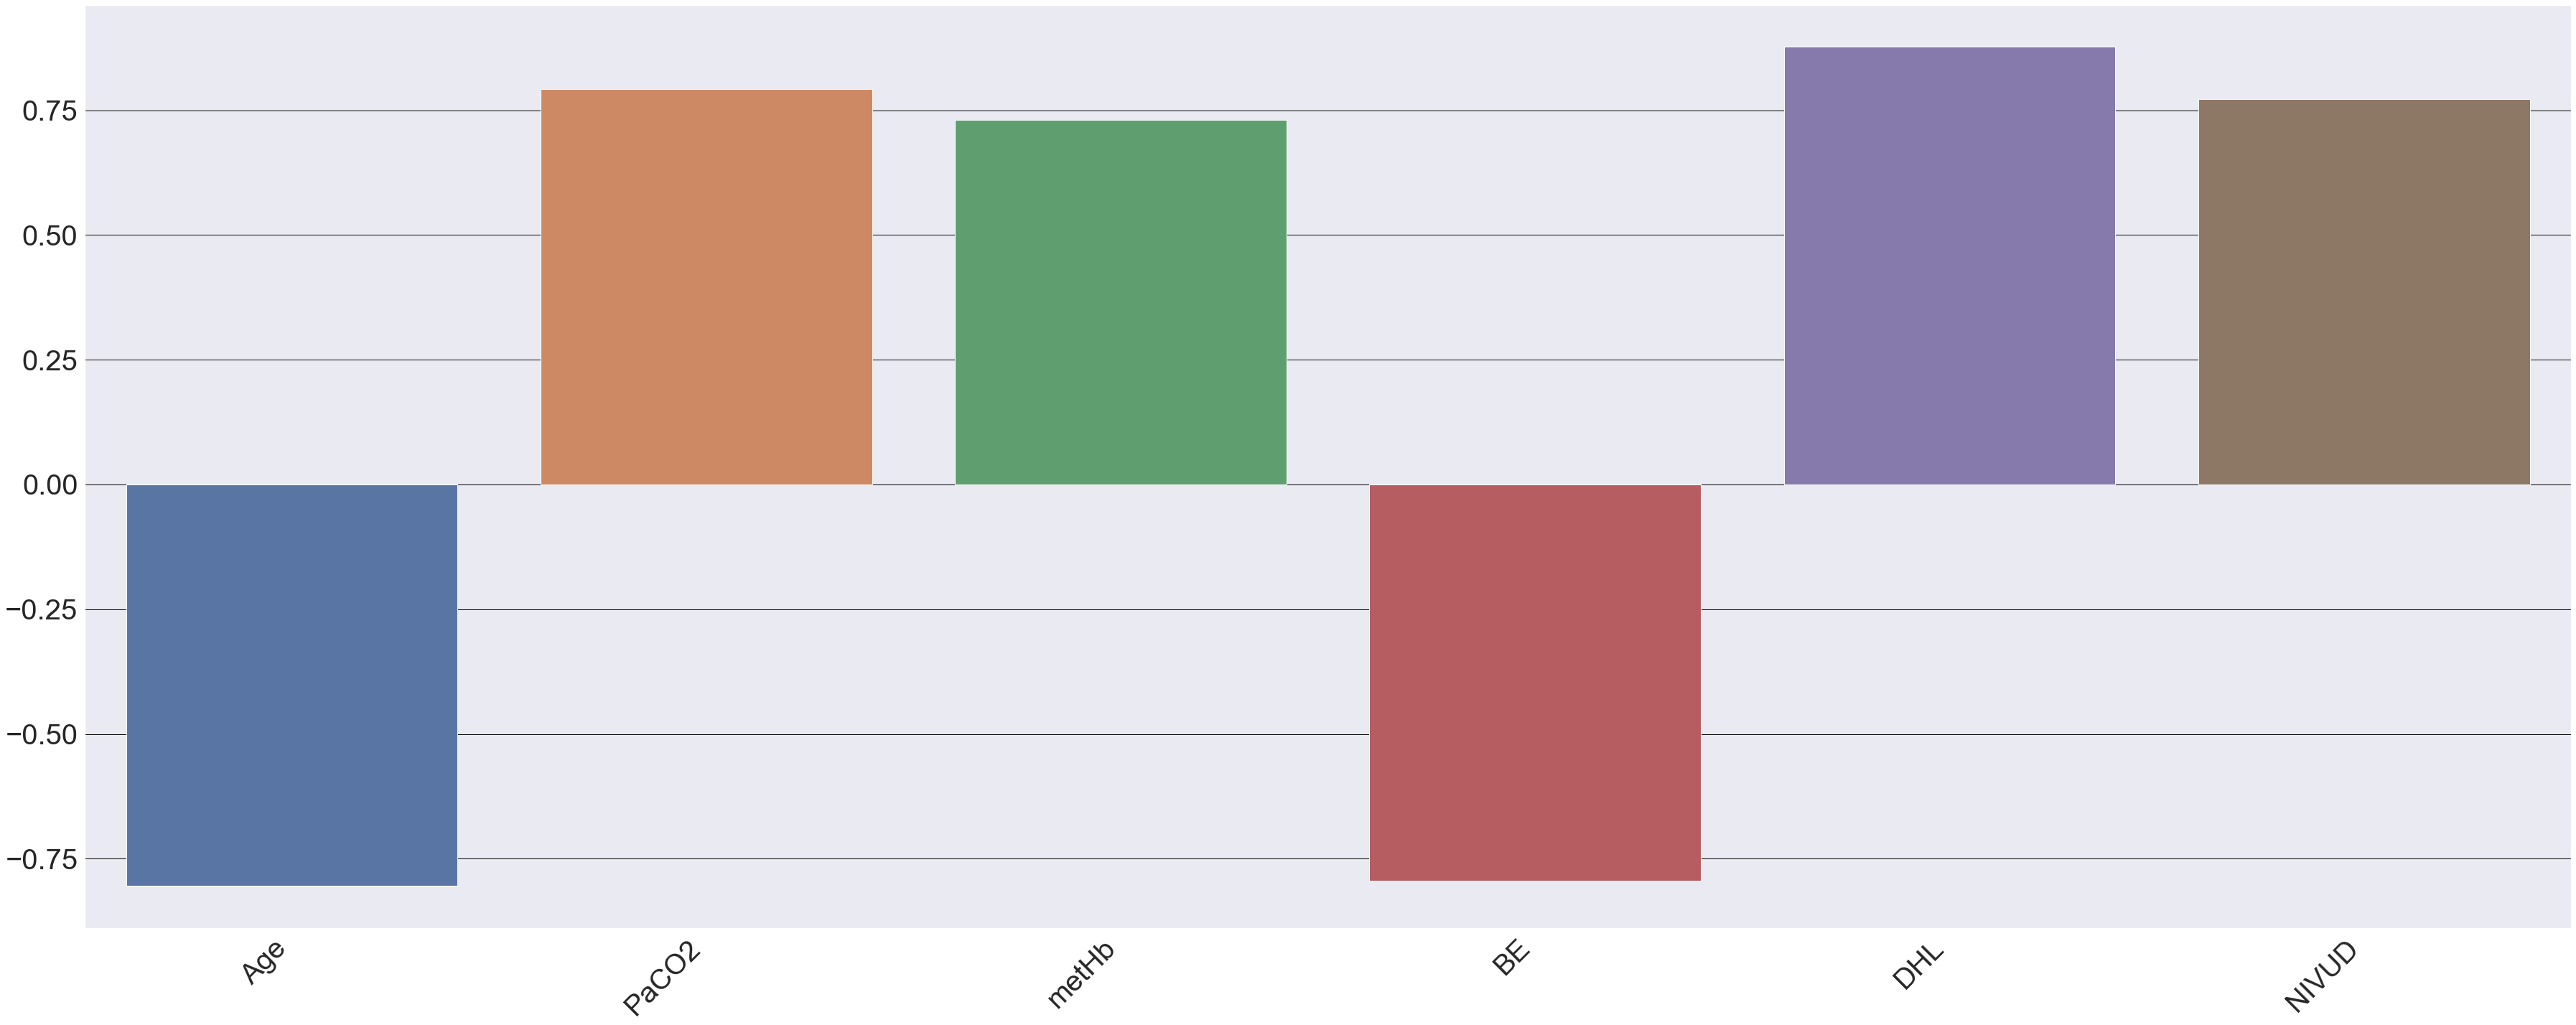


###################### Cluster 5 ######################
        Age       TAD   Lactate     PaCO2     metHb        BE   AST/TGO  \
0 -0.580867 -0.261731  0.295533  0.506645  0.348033 -0.377753 -0.472062   

       DHL  AlkalinePhosph       GGT  Lymphocytes  Platelets  Glasgow  \
0  0.64901       -0.520981  0.605889    -0.332517  -0.401234  0.36004   

      NIVUD  
0 -0.295882  


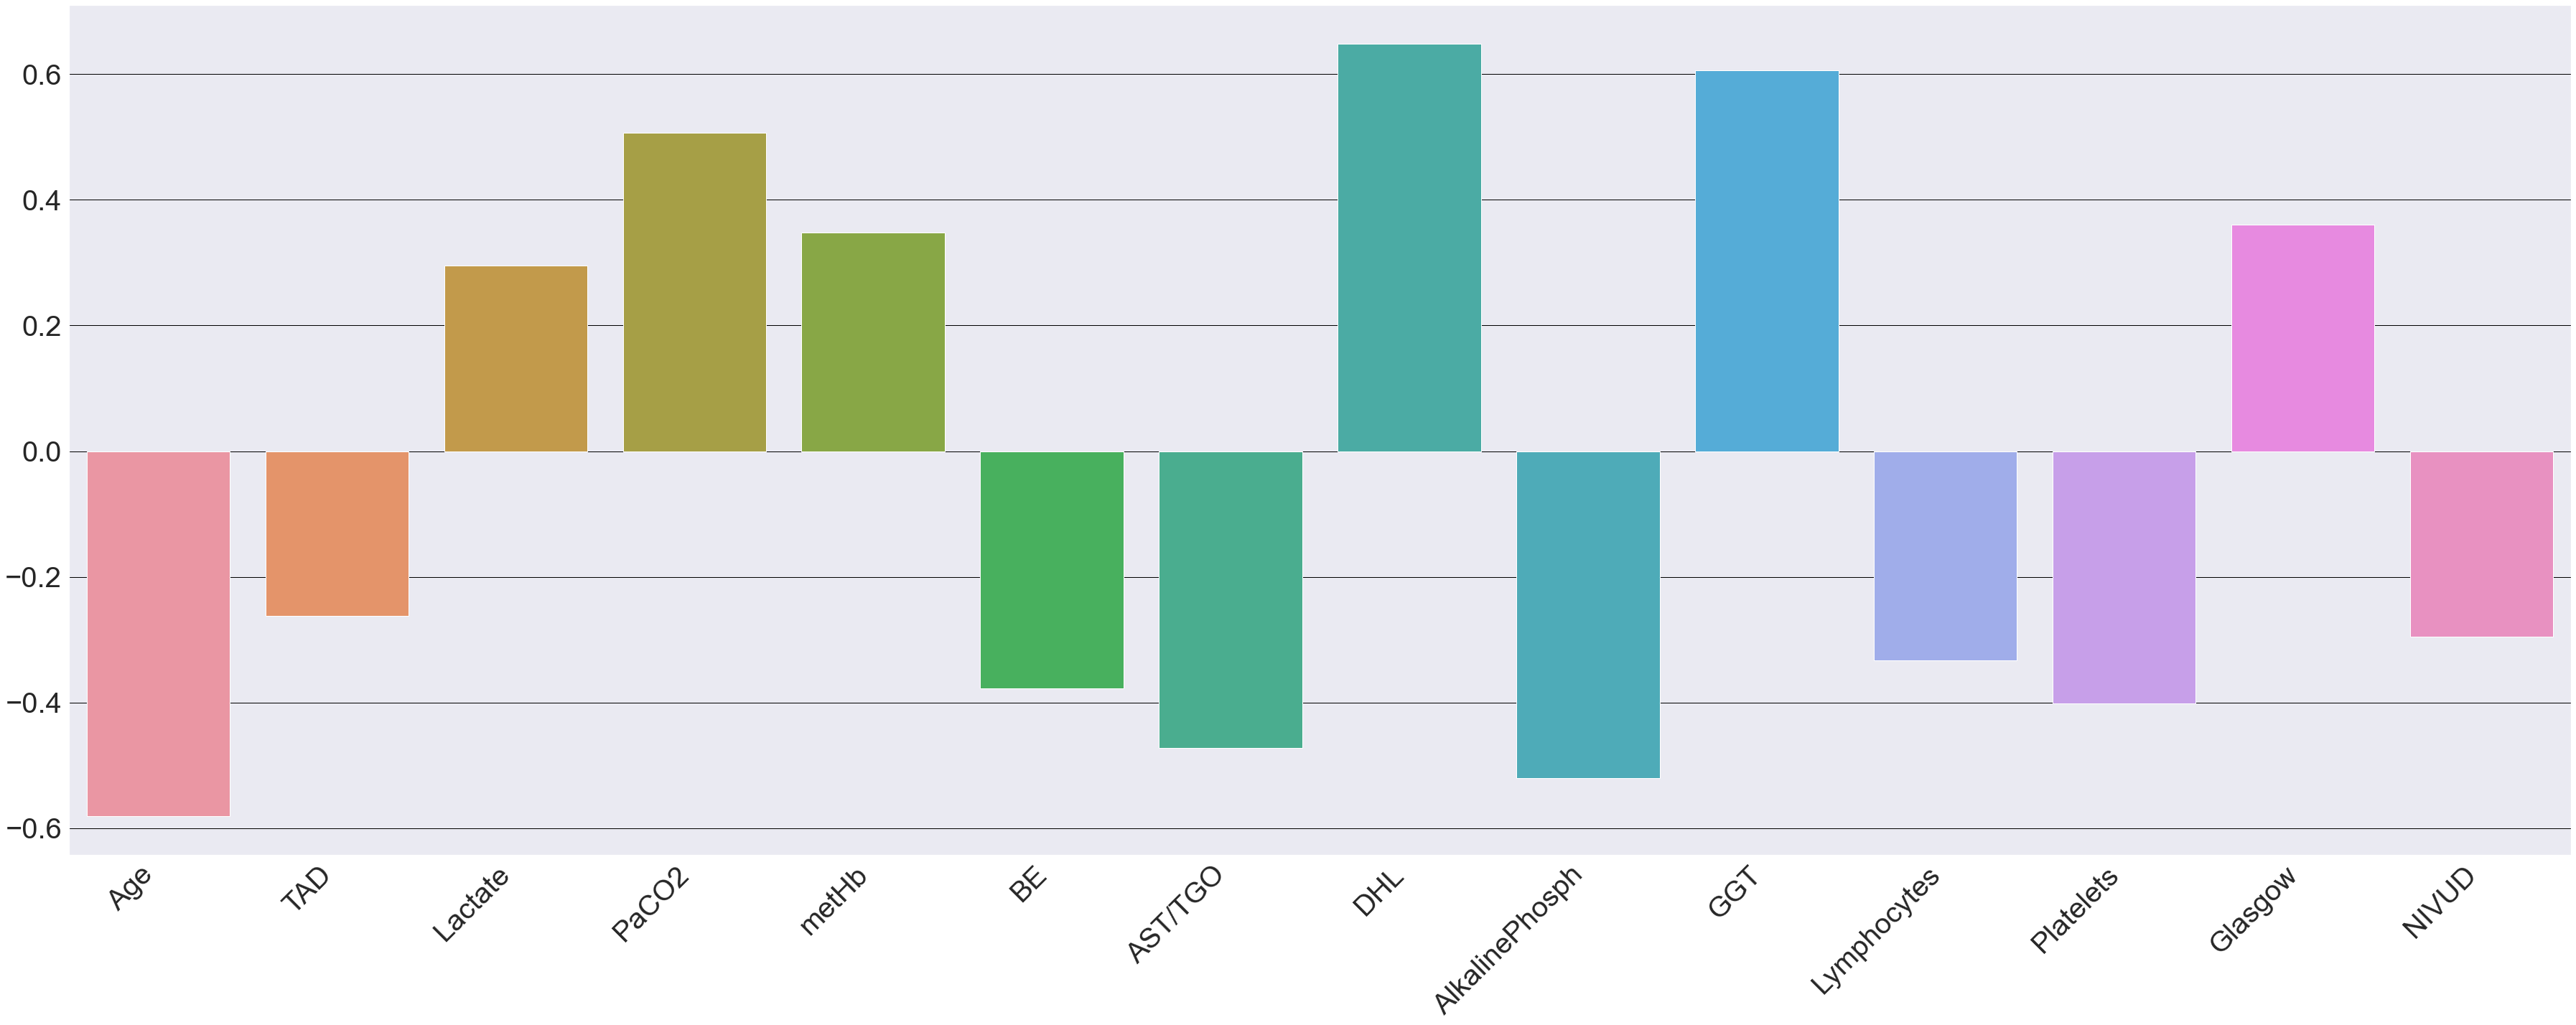

In [64]:
Importance_clusters_List = []

for n, X, y in Clusters_Data:

    if No_Model_List[n-1] == 0:
    
        LR_classifier = Model_List[n-1]

        # get importance
        importance = LR_classifier.coef_[0]
        # And save into a list with all importances of the clusters
        Importance_clusters_List.append(importance)

        X = X[RFE_columns_List[n-1]]

        Df_scores_LR= pd.DataFrame(columns=list(X.columns))
        Df_scores_LR.loc[0] = importance

        # Plot
        print ('###################### Cluster', n, '######################')
        print(Df_scores_LR)
        sns.set(rc={"figure.figsize":(50, 20)})

        ax =sns.barplot(data=Df_scores_LR)

        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=40)

        plt.yticks(fontsize = 40)
        plt.grid(color = 'black', axis = 'y')

        plt.tight_layout()
        plt.savefig('Clustering Plots/ADASYN Cluster {} Coefficient Importance'.format(n))
        plt.show()

        print()
    else:
        print ('###################### Cluster', n, '######################')
        print()
        print('No coefs for this model')
        print()

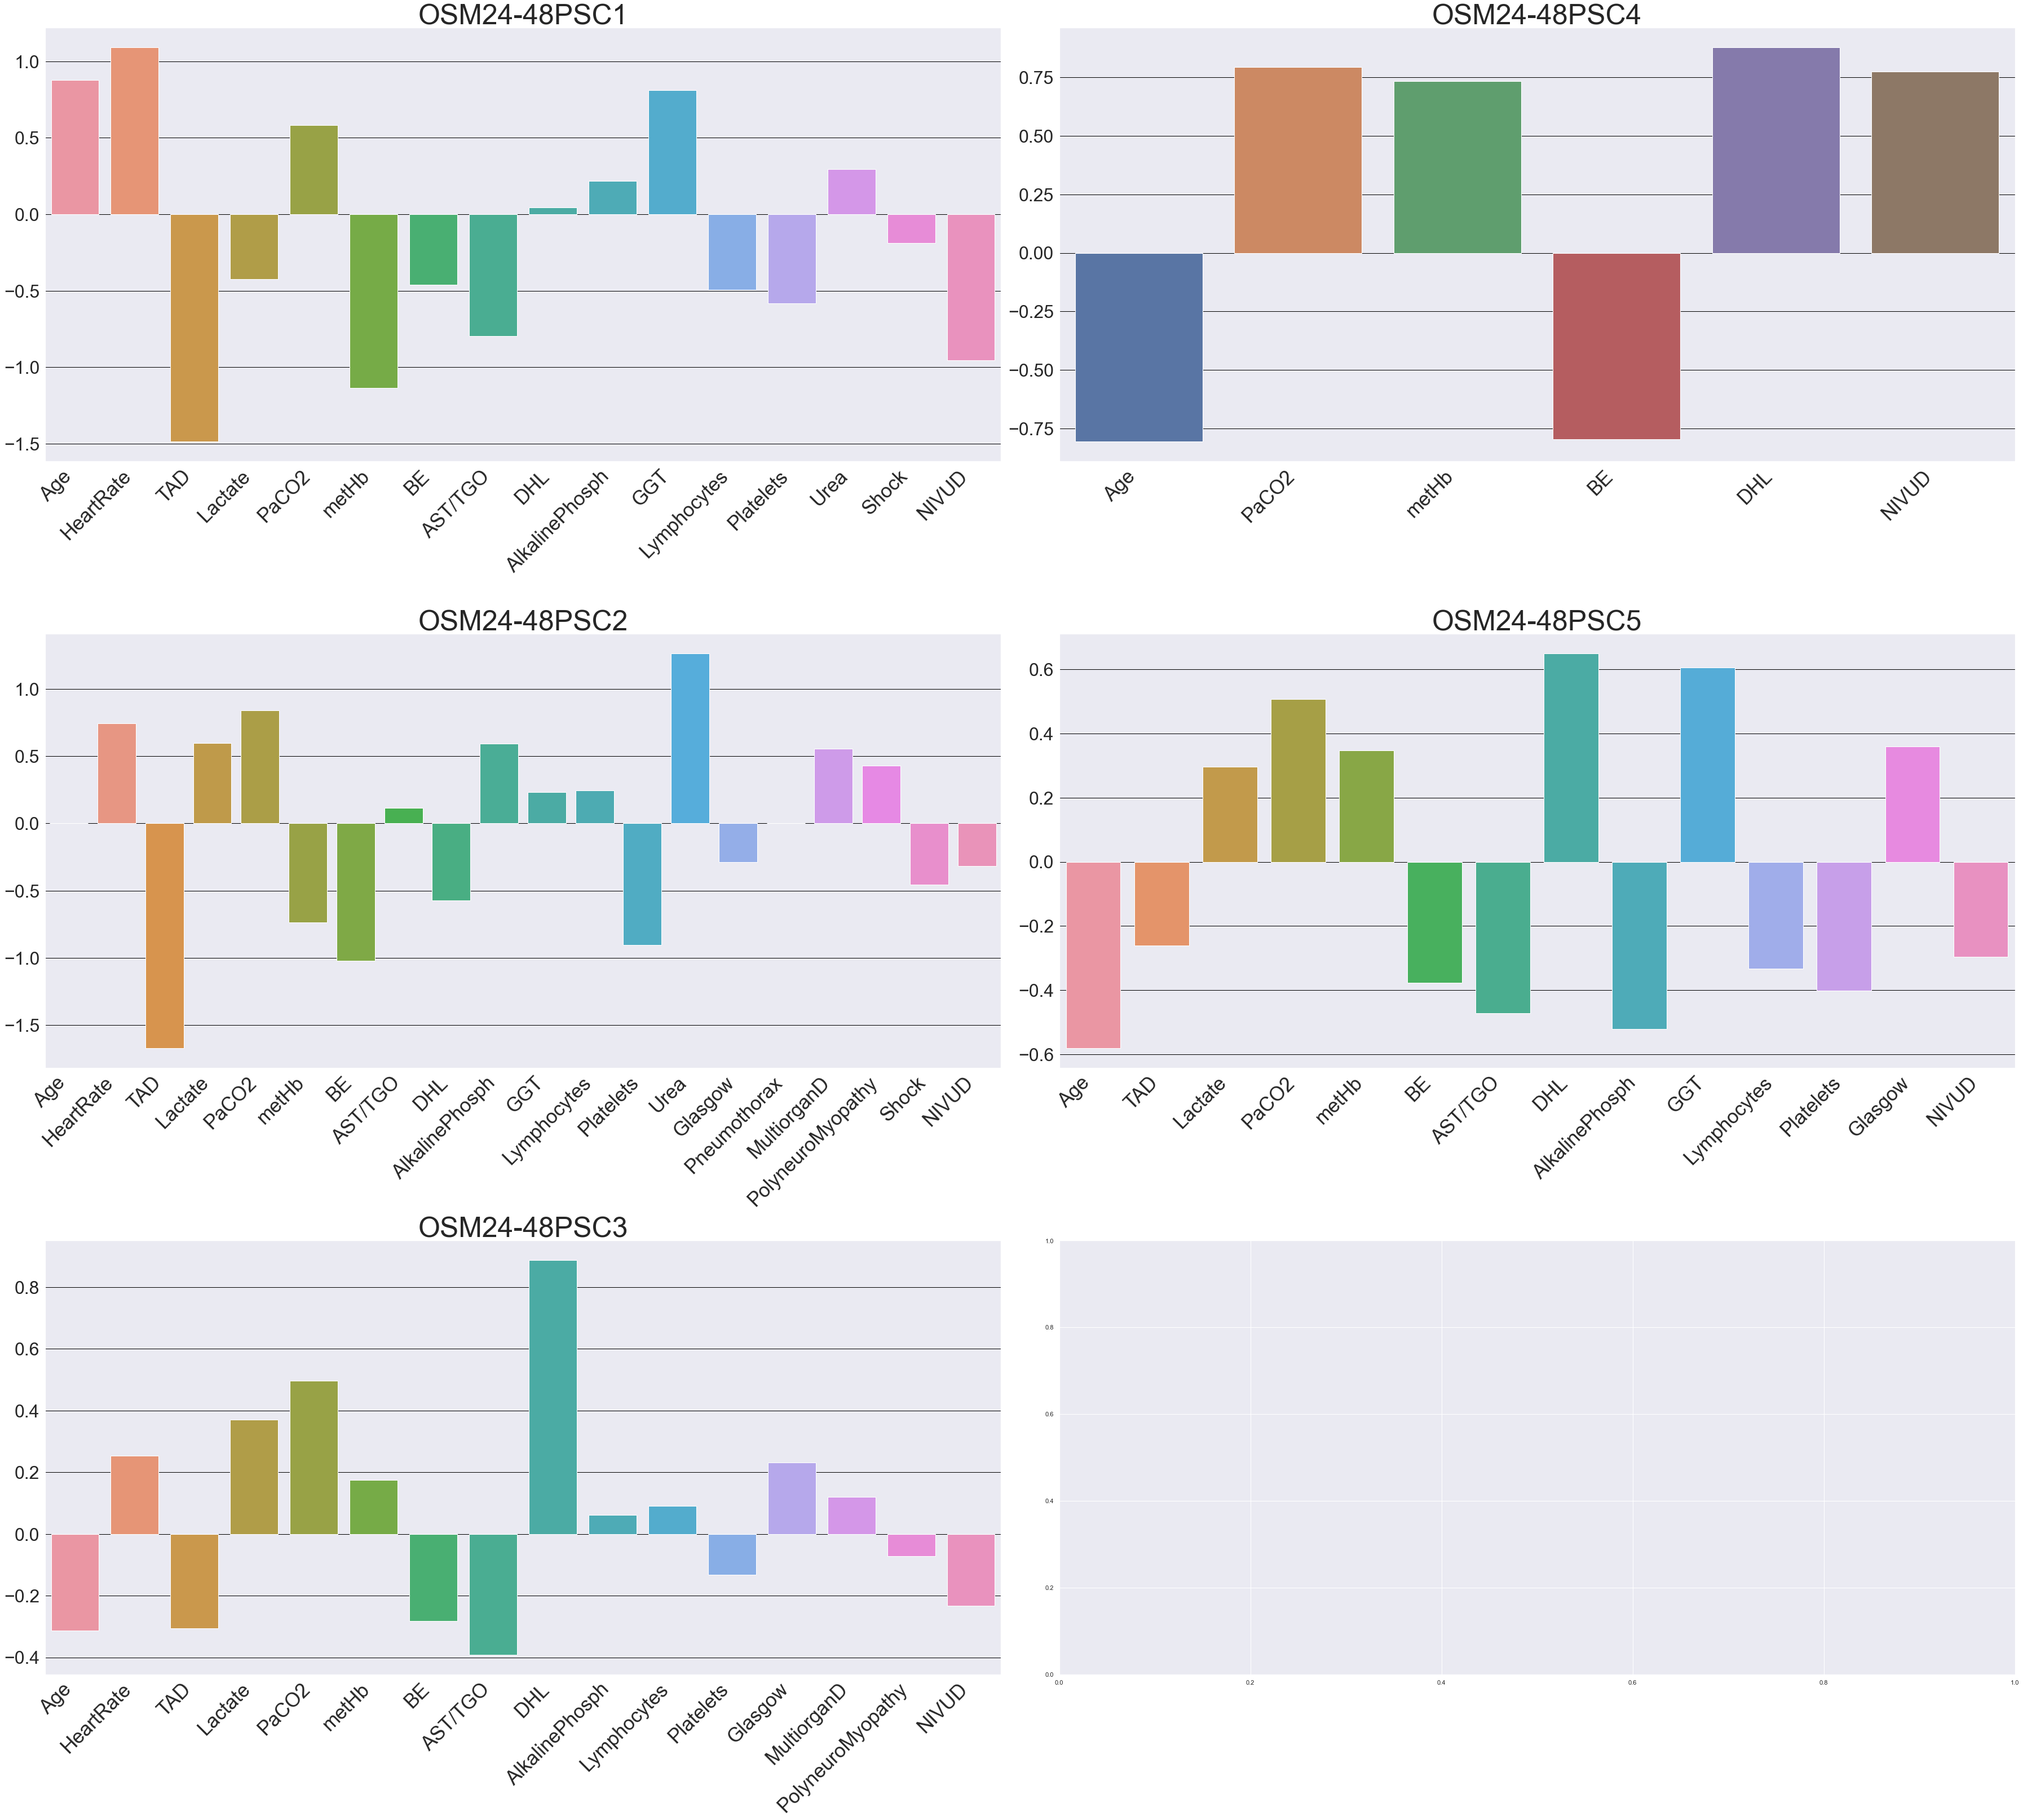

In [ ]:
sns.set(rc={"figure.figsize":(50, 45)})
fig, ax = plt.subplots(3,2)
ax1=0
ax2=0

Importance_clusters_List = []

for n, X, y in Clusters_Data:

    if No_Model_List[n-1] == 0:
    
        LR_classifier = Model_List[n-1]

        # get importance
        importance = LR_classifier.coef_[0]
        # And save into a list with all importances of the clusters
        Importance_clusters_List.append(importance)

        X = X[RFE_columns_List[n-1]]

        Df_scores_LR= pd.DataFrame(columns=list(X.columns))
        Df_scores_LR.loc[0] = importance

        # Plot
        sn = sns.barplot(data=Df_scores_LR, ax=ax[ax1, ax2])
        sn.set_xticklabels(sn.get_xticklabels(), rotation=45, ha="right", fontsize=35)
        sn.grid(color = 'black', axis = 'y')
        #sn.set_yticklabels(sn.get_yticklabels(), fontsize=20)
        sn.tick_params(axis='y', labelsize=32)
        sn.set_title('OSM24-48PSC{}'.format(n), fontsize=50)

        #ax[ax1, ax2].set_title('Cluster :' n, fontsize=15)

        ax1 +=1
        if ax1== 3:
            ax1=0
            ax2+=1 

plt.tight_layout()
plt.savefig('Clustering Plots/ADASYN All Clusters Coefficient Importance'.format(n))
plt.show()



### Save Model - ADASYN

In [ ]:
for n, X, y in Clusters_Data:
    
    LR_classifier = Model_List[n-1]

    # Saving Model
    if No_Model_List[n-1] == 0:
        filename = 'Models/Cluster {} LR Mortality 24-48h Adasyn.sav'.format(n)
        pickle.dump(LR_classifier, open(filename, 'wb'))
    else:
        filename = 'Models/Cluster {} Dummy Mortality 24-48h Adasyn.sav'.format(n)
        pickle.dump(LR_classifier, open(filename, 'wb'))

# Loading Model
#LR_classifier = pickle.load(open('Models/LR Mortality 24-48h.sav', 'rb'))

# Proof of concept (More seperable clusters)

In [82]:
# Data for Cluster 1 and 2 test

test_dataframes_list_all_features_for_ONE_CLUSTER[0].to_csv('Data/Pneumonia_Data_48h/24h-48h/For Clustering/ONE CLUSTER Test For Global/TEST_ONE_CLUSTER_DATA_1.csv', index=False)
np.save('Data/Pneumonia_Data_48h/24h-48h/For Clustering/ONE CLUSTER Test For Global/TEST_ONE_CLUSTER_CLASS_1.npy', test_classes_list_for_ONE_CLUSTER[0])

test_dataframes_list_all_features_for_ONE_CLUSTER[1].to_csv('Data/Pneumonia_Data_48h/24h-48h/For Clustering/ONE CLUSTER Test For Global/TEST_ONE_CLUSTER_DATA_2.csv', index=False)
np.save('Data/Pneumonia_Data_48h/24h-48h/For Clustering/ONE CLUSTER Test For Global/TEST_ONE_CLUSTER_CLASS_2.npy', test_classes_list_for_ONE_CLUSTER[1])

In [81]:
print(len(test_dataframes_list_all_features_for_ONE_CLUSTER))

5


Here, the analysis was made for each cluster one at a time , we have to chose the cluster by defining the correct data bellow

In [76]:
# Provide wanted train data

X_ONE = pd.read_csv('Data/Pneumonia_Data_48h/24h-48h/For Clustering/ONE_CLUSTER_DATA_5.csv')
y_ONE = np.load('Data/Pneumonia_Data_48h/24h-48h/For Clustering/ONE_CLUSTER_CLASS_5.npy')

In [77]:
centroid = X_ONE.mean().tolist()

In [78]:
distances_ONE = []

for index, row in X_test.iterrows():

    row = row.tolist()

    eu_dis = np.linalg.norm(np.array(row)-np.array(centroid))

    distances_ONE.append(eu_dis)

distances_ONE = np.array(distances_ONE)

# the first k elements will be the k-smallest elements in idx
idx = np.argpartition(distances_ONE, 50)

idx = idx[:50]

In [74]:
X_test_ONE = X_test.iloc[idx]
y_test_ONE = np.array(y_test)[idx]

In [79]:
# Provide wanted test data

X_test_ONE.to_csv('Data/Pneumonia_Data_48h/24h-48h/For Clustering/ONE CLUSTER Test For Global/TEST_ONE_CLUSTER_DATA_5.csv', index=False)
np.save('Data/Pneumonia_Data_48h/24h-48h/For Clustering/ONE CLUSTER Test For Global/TEST_ONE_CLUSTER_CLASS_5.npy', y_test_ONE)

>2 0.5000 (0.0000)
>4 0.5500 (0.1500)
>6 0.5429 (0.1539)
>8 0.5845 (0.2099)
>10 0.6179 (0.2071)
>12 0.5929 (0.2047)
>14 0.6179 (0.2071)
>16 0.6179 (0.2071)
>18 0.6179 (0.2071)
>20 0.6179 (0.2071)


(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

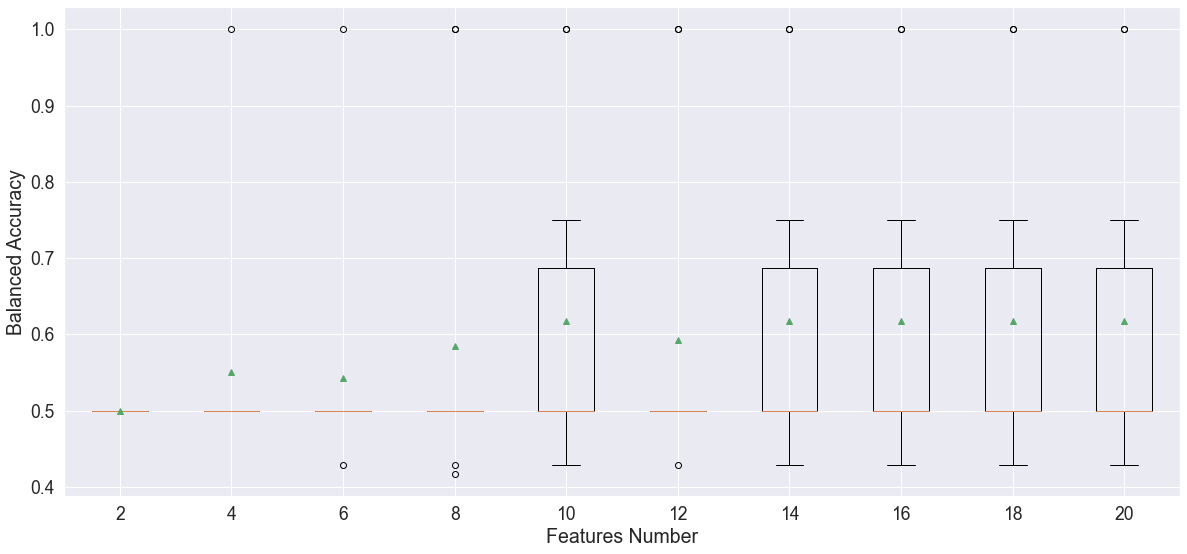

In [ ]:
sns.set(rc={"figure.figsize":(20, 9)})

# get a list of models to evaluate
models = dict()
for i in [2,4,6,8,10,12,14,16,18,20]:
   # A machine learning model to selecting the features by eliminating the least important feature after recursively training
   rfe = RFE(estimator=LogisticRegression(max_iter=300), n_features_to_select=i)
   model = LogisticRegression(random_state = 0)
   models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])

# evaluate the models and store results
results, names = list(), list()
results_mean = list()
for name, model in models.items():
   # scoring='balanced_accuracy' because the data is unbalenced
   scores = cross_val_score(model, X_ONE, y_ONE, scoring='balanced_accuracy', cv=10, n_jobs=-1, error_score='raise')
   results.append(scores)
   results_mean.append(scores.mean())
   names.append(name)
   print('>%s %.4f (%.4f)' % (name, scores.mean(), scores.std()))

# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)

pyplot.ylabel('Balanced Accuracy', fontsize=19.5)
pyplot.xlabel('Features Number', fontsize=19.5)
pyplot.yticks(fontsize = 17.5)
pyplot.xticks(fontsize = 17.5)

In [ ]:
rfe_selector = RFE(estimator=LogisticRegression(max_iter=300),n_features_to_select = 10, step = 1)
rfe_selector.fit(X_ONE, y_ONE)
RFE_columns = X_ONE.columns[rfe_selector.get_support()]
print(RFE_columns)

Index(['HeartRate', 'TAD', 'PaCO2', 'metHb', 'BE', 'AlkalinePhosph', 'GGT',
       'Lymphocytes', 'Platelets', 'Glasgow'],
      dtype='object')


In [ ]:
X_ONE = X_ONE[RFE_columns]
X_test_ONE = X_test_ONE[RFE_columns]

In [ ]:
LR_classifier = LogisticRegression(max_iter=2000, random_state=0, solver='lbfgs', penalty="l2")
LR_classifier.fit(X_ONE, y_ONE)

LogisticRegression(max_iter=2000, random_state=0)

In [ ]:
# Final cross validation with balanced accuracy
cv = StratifiedKFold(10)

all_accuracies_RF = cross_val_score(estimator=LR_classifier, X=X_ONE, y=y_ONE, cv=cv, scoring='accuracy')
all_balanced_accuracies_RF = cross_val_score(estimator=LR_classifier, X=X_ONE, y=y_ONE, cv=cv, scoring='balanced_accuracy')
all_precisions_RF = cross_val_score(estimator=LR_classifier, X=X_ONE, y=y_ONE, cv=cv, scoring='precision')
all_recalls_RF = cross_val_score(estimator=LR_classifier, X=X_ONE, y=y_ONE, cv=cv, scoring='recall')
all_f1_RF = cross_val_score(estimator=LR_classifier, X=X_ONE, y=y_ONE, cv=cv, scoring='f1')

print('     Accuracy')
print('%6.2f' % all_accuracies_RF.mean(), 'std','%3.2f' % all_accuracies_RF.std())
print()
print('Balanced Accuracy')
print('%6.2f' % all_balanced_accuracies_RF.mean(), 'std','%3.2f' % all_balanced_accuracies_RF.std())
print()
print('    Precision')
print('%6.2f' % all_precisions_RF.mean(), 'std','%3.2f' % all_precisions_RF.std())
print()
print('     Recall')
print('%6.2f' % all_recalls_RF.mean(), 'std','%3.2f' % all_recalls_RF.std())
print()
print('    F1-score')
print('%6.2f' % all_f1_RF.mean(), 'std','%3.2f' % all_f1_RF.std())
print()

     Accuracy
  0.86 std 0.09

Balanced Accuracy
  0.59 std 0.20

    Precision
  0.20 std 0.40

     Recall
  0.20 std 0.40

    F1-score
  0.20 std 0.40



C:\Users\nunop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nunop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nunop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defin

In [ ]:
# Here we have to use LR_classifier.predict_proba(X_test)[:,1] and not y_pred
fpr, tpr, thresholds = metrics.roc_curve(y_test_ONE, LR_classifier.predict_proba(X_test_ONE)[:,1], pos_label=1)
auc_roc = metrics.auc(fpr, tpr)
print(auc_roc)

0.6879432624113475


optimal idx : 7
optimal threshold : 0.1156269509738556
tpr optimal idx: 1.0
fpr optimal idx: 0.3829787234042553


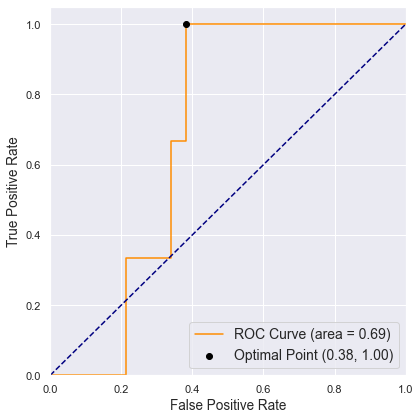

In [ ]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print('optimal idx :', optimal_idx)
print('optimal threshold :', optimal_threshold)
print('tpr optimal idx:', tpr[optimal_idx])
print('fpr optimal idx:', fpr[optimal_idx])

sns.set(rc={"figure.figsize":(6, 6)})

plt.plot(fpr, tpr, color='darkorange',
         label='ROC Curve (area = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.scatter([fpr[optimal_idx]], [tpr[optimal_idx]], color="black", zorder=5,
         label='Optimal Point (%0.2f, %0.2f)' % (fpr[optimal_idx], tpr[optimal_idx]))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate', fontsize=13.5)
plt.ylabel('True Positive Rate', fontsize=13.5)
plt.legend(loc="lower right", fontsize=14)

plt.tight_layout()
#plt.savefig('ROC Curve')
plt.show()

In [ ]:
y_pred = (LR_classifier.predict_proba(X_test_ONE)[:,1] >= optimal_threshold).astype(bool)

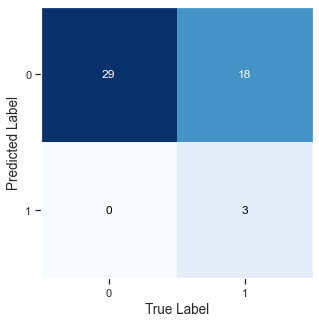

In [ ]:
sns.set(rc={"figure.figsize":(5, 5)})

c_matrix = confusion_matrix(y_test_ONE, y_pred)
plot_confusion_matrix(c_matrix)

plt.xlabel('True Label', fontsize=13.5)
plt.ylabel('Predicted Label', fontsize=13.5)

#plt.savefig('Confusion Matrix')
plt.show()

In [ ]:

print('Accuracy     Balanced Accuracy     Precision     Recall     F1-score')
print('%6.2f' % accuracy_score(y_test_ONE,y_pred), '%16.2f' % balanced_accuracy_score(y_test_ONE,y_pred), '%17.2f' % precision_score(y_test_ONE,y_pred), '%12.2f' % recall_score(y_test_ONE,y_pred), '%11.2f' % f1_score(y_test_ONE,y_pred))
print()
print(' AUROC     Opt Threshold')
print( '%5.2f' % auc_roc, '%14.2f' % optimal_threshold)

Accuracy     Balanced Accuracy     Precision     Recall     F1-score
  0.64             0.81              0.14         1.00        0.25

 AUROC     Opt Threshold
 0.69           0.12
